## Отчёт о выполнении дипломной работы на тему:
# **Анализ показателей тралового лова водных биологических ресурсов в Охотском море в 2019-2020 промысловом году (поиск инсайтов, оценка расходования рыбных ресурсов)**     

## Профессия: Аналитик данных с нуля до middle, DAU-25
## Еремеев С.И.

![](https://fdlx.com/wp-content/uploads/velikobritaniya-vyxodit-iz-mezhdunarodnogo-dogovora-po-rybolovstvu.jpg)

In [1]:
import numpy as np
import pandas as pd
from pandas.core.common import flatten
import re
from geopy.distance import geodesic as GD
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy import stats
from sklearn.preprocessing import StandardScaler
import matplotlib
from statsmodels.stats.multicomp import pairwise_tukeyhsd

matplotlib.style.use("ggplot")

%load_ext lab_black
rcParams["figure.figsize"] = 15, 9

# **Введение**

## Предметом настоящей работы является иследование наличия и степени искажений, допускаемых пользователями одной из ведомственных систем монтиринга рыболовства, при представлении данных оперативной промысловой отчётности. Методика исследования основывается на предположении, что при осуществлении добычи водных биологических ресурсов с использованием идентичных судов в однородном в промысловом отношении районе отклонения видовых и обёмных показателей уловов не должны иметь существенных отличий.  
    
## **Цель работы**   
    
## Прогнозирование видовых и объёмных показателей уловов водных биоресурсов при осуществлении тралового лова в акватории Охотского моря в 2019-2020 промысловом году и статистическая оценка результатов прогноза.   
    
## **Задачи, направленные на достижение цели**
    
### 1. Подготовка данных оперативной промысловой отчётности о результатах добычи тралящими орудиями лова в акватории Охотского моря, представленной капитанами добывающих судов в период с 1 ноября 2019 г. по 31 октября 2020 г.;   
### 2. Классификация судов с целью ответа на вопрос: какие суда следует рассматривать как идентичные?;
### 3. Кластеризация судов по пространственному признаку в целях отнесения их к однородным в промысловоми отношении районам;
### 4. Статистический анализ видовых и объёмных показателей вылова;
### 5. Прогнозирование видовых и объёмных показателей уловов, статистическая оценка результатов прогноза;
### 6. Формулирование выводов.
    
    
## **Определение круга стейкхолдеров исследования**

> ### [Стейкхолдеры](https://pro.rbc.ru/demo/61c350ab9a79470ff7014d87) — это заинтересованные стороны: люди, группы или организации, которые могут влиять или которые могут воспринимать себя подвергнутыми влиянию решения, операции или результата проекта, программы или портфеля. Это могут быть инвесторы, различные команды в организации, клиенты, поставщики, производители и регулирующие органы — все, кого негативно или позитивно затрагивает проект.

## Исходя из приведённого определения, к кругу стейкхолдеров данного исследования следует отнести:
### 1. Научно-исследовательские учреждения рыбного хозяйства и океанографии;
### 2. Органы исполнительной власти Российской Федерации, уполномоченные осуществлять нормативное регулирование и государственный контроль в области рыболовства и сохранения водных биологических ресурсов;
### 3. Пользователей водными биологическими ресурсами (юридических лиц или индивидуальных предпринимателей);
### 4. Капитанов судов рыборпромыслового флота.
***

# **1. Подготовка данных**

## **1.1. Загрузка данных о результатах промысловых операций (усилий)**
## Применительно к целям настоящей работы под промысловой операцией (промысловым усилием) понимается одно траление.
### *Состав данных:*
### - `id_ves` - уникальный идетификатор судна;
### - `date` - дата выполнения промысловой операции ("промысловые сутки");
### - `id_oper` - уникальный идентификатор используемого орудия лова (групповой, "родительский");
### - `oper_quantity` - количество промысловых операций, выполненых в течение промысловых суток;
### - `oper_time` - суммарное время выполнения промысловых операций;
### - `catch_depth` - средняя глубина движения трала при выполнении промысловой операции (глубина траления, "горизинт траления");
### - `catch_volume` - суммарный вылов по всем объектам за промысловые сутки;
### - `id_oper_full` - уникальный идентификатор используемого орудия лова (индивидуальный).

In [3]:
# загрузка данные о промысловых опeрациях и применение фильтра по дате в соответстви с исследуемым периодом
df_operation = pd.read_csv(
    "/home/sk27/learning/graduation_project/data/operation.csv",
    sep=";",
    encoding="cp1251",
)
df_operation = df_operation.replace(",", ".", regex=True).apply(
    pd.to_numeric, errors="ignore"
)
df_operation["date"] = df_operation["date"].astype("datetime64[ns]")
df_operation = df_operation[
    (df_operation["date"] > "2019-10-31") & (df_operation["date"] < "2020-11-01")
]
df_operation

,id_ves,date,id_oper,oper_quantity,oper_time,catch_depth,catch_volume,id_oper_full
1076878,10021,2020-05-24,11,1,2.0,420.0,34.24,389
1849972,10421,2020-02-01,930,4,14.0,400.0,3.31,930
1850457,10608,2020-05-01,995,15,14.7,340.0,18.46,995
1850845,11533,2020-07-01,610,3,17.9,550.0,100.86,610
1851565,11244,2019-11-01,20,13,19.7,190.0,20.70,52
...,...,...,...,...,...,...,...,...
2026680,13496,2020-05-12,12,1,7.0,200.0,0.00,615
2027330,46241,2020-10-28,12,2,2.0,155.0,0.00,644
2027331,12365,2020-08-12,26,2,2.0,25.0,1.08,187
2028549,11165,2020-05-01,92,1,1.0,5.0,0.00,342


In [4]:
df_operation.info()  # контроль качества данных

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88076 entries, 1076878 to 2028879
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id_ves         88076 non-null  int64         
 1   date           88076 non-null  datetime64[ns]
 2   id_oper        88076 non-null  int64         
 3   oper_quantity  88076 non-null  int64         
 4   oper_time      88076 non-null  float64       
 5   catch_depth    88044 non-null  float64       
 6   catch_volume   88074 non-null  float64       
 7   id_oper_full   88076 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(4)
memory usage: 6.0 MB


### Формат данных верный. Частично отсутствуют не критичные для проведения исследования данные о горизонте траления и суммарном вылове.

## **1.2. Загрузка справочника судов и применение фильтра на поля в целях использования только тех данных, которые актуальны для проводимого исследования**
### *Состав данных (здесь и далее описываются данные, описание которых не приводилось ранее):*
### - `id_type_ves` - уникальный идентификатор конструктивного типа (далее - тип, конструктивный тип) судна;
### - `length` - длина судна (м);
### - `width` - ширина судна (м);
### - `total_volume` - полное водоизмещение (тонны);
### - `max_velocity` - максимальная скорость (узлы);
### - `engine_power` - мощность главной энергетической установки судна (далее - ГЭУ).

In [5]:
# загрузка данных и применение фильтров
df_ves = pd.read_csv(
    "/home/sk27/learning/graduation_project/data/ves.csv", sep=";", encoding="cp1251"
)
df_ves = df_ves.drop_duplicates(subset="id_ves", keep="last")  # Надо пояснить (!)
df_ves = df_ves[
    [
        "id_ves",
        "id_type_ves",
        "length",
        "width",
        "total_volume",
        "max_velocity",
        "engine_power",
    ]
]
df_ves = df_ves.reset_index(drop=True)
df_ves = df_ves.replace(",", ".", regex=True).apply(pd.to_numeric, errors="ignore")

In [6]:
df_ves.info()  # контроль качества данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7135 entries, 0 to 7134
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id_ves        7135 non-null   int64  
 1   id_type_ves   7135 non-null   int64  
 2   length        7110 non-null   float64
 3   width         6600 non-null   float64
 4   total_volume  6324 non-null   float64
 5   max_velocity  6350 non-null   float64
 6   engine_power  6157 non-null   float64
dtypes: float64(5), int64(2)
memory usage: 390.3 KB


### Формат данных верный. Частично отсутствуют необходимые для проведения исследования данные о мощности ГЭУ.

## **1.3. Обогащение данных о промысловых операциях сведениями о технических характеристиках судов**

In [7]:
# присоединение к данным о промысловых операциях справочника судов
df_operation_ves = df_operation.merge(
    df_ves, left_on="id_ves", right_on="id_ves", how="left"
)

In [8]:
df_operation_ves

,id_ves,date,id_oper,oper_quantity,oper_time,catch_depth,catch_volume,id_oper_full,id_type_ves,length,width,total_volume,max_velocity,engine_power
0,10021,2020-05-24,11,1,2.0,420.0,34.24,389,116,96.70,16.0,4407.0,16.1,5304.0
1,10421,2020-02-01,930,4,14.0,400.0,3.31,930,146,48.50,13.2,1338.0,14.0,2205.0
2,10608,2020-05-01,995,15,14.7,340.0,18.46,995,518,57.00,9.4,741.0,12.0,1324.0
3,11533,2020-07-01,610,3,17.9,550.0,100.86,610,116,103.70,16.0,4457.0,16.1,5152.0
4,11244,2019-11-01,20,13,19.7,190.0,20.70,52,186,45.54,11.5,1315.0,12.3,1440.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88071,13496,2020-05-12,12,1,7.0,200.0,0.00,615,179,48.10,11.0,1086.0,12.5,2250.0
88072,46241,2020-10-28,12,2,2.0,155.0,0.00,644,164,37.87,11.0,708.0,15.0,1838.0
88073,12365,2020-08-12,26,2,2.0,25.0,1.08,187,519,18.40,4.2,31.0,8.0,345.0
88074,11165,2020-05-01,92,1,1.0,5.0,0.00,342,205,30.14,7.0,172.0,9.0,224.0


In [9]:
df_operation_ves.info()  # контроль качества данных

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88076 entries, 0 to 88075
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id_ves         88076 non-null  int64         
 1   date           88076 non-null  datetime64[ns]
 2   id_oper        88076 non-null  int64         
 3   oper_quantity  88076 non-null  int64         
 4   oper_time      88076 non-null  float64       
 5   catch_depth    88044 non-null  float64       
 6   catch_volume   88074 non-null  float64       
 7   id_oper_full   88076 non-null  int64         
 8   id_type_ves    88076 non-null  int64         
 9   length         88076 non-null  float64       
 10  width          87847 non-null  float64       
 11  total_volume   87784 non-null  float64       
 12  max_velocity   87645 non-null  float64       
 13  engine_power   87369 non-null  float64       
dtypes: datetime64[ns](1), float64(8), int64(5)
memory usage: 10.1 MB


## Полученные данные содержат сведения об осуществлении всех промысловых операций в охватываемый исследованием период во всех промысловых районах Дальневосточного рыбохозяйственного бассйена, т.е. имеющиеся данные избыточны. Прежде чем восстанавливать пропуски информации, необходимой для проведения исследования, целесообразно исключить из данных неактуальные сведения.
## Будут удалены:
### - данные о добыче вне акватории Охотского моря;
### - данные о вылове ловушками. Добыча ловушками имеет специфические особенности и для исследования этой добычи необходимы алгоритмы, не входящие в инструментарий настоящей работы.

## **1.4. Загрузка справочника орудий лова и создание списка идентификаторов орудий лова, относящихся к ловушкам**

In [10]:
# загрузка справочника орудий лова
df_oper = pd.read_csv(
    "/home/sk27/learning/graduation_project/data/oper.csv",
    sep=";",
    encoding="cp1251",
    index_col=0,
).apply(pd.to_numeric, errors="ignore")
df_oper = df_oper.apply(pd.to_numeric, errors="ignore")
# создание списка кодов ловушечных орудий лова. Можно, конечно, было бы использовать иерархию орудий, но при том же прогнозируемом результате применённый подход более простой.
df_snare = df_oper[df_oper["oper"].str.contains("ловуш")].reset_index()
snare_list = df_snare["id_oper"].to_list()

## **1.5. Удаление данных о добыче ловушками**

In [11]:
# промысловые операции, выполненные траловыми орудиями лова в период с 1 ноября 2019 г. по 31 октября 2020 г. (включительно) во всех (!) районах
df_trawl = df_operation_ves[~df_operation_ves.id_oper.isin(snare_list)].reset_index(
    drop=True
)
df_trawl

,id_ves,date,id_oper,oper_quantity,oper_time,catch_depth,catch_volume,id_oper_full,id_type_ves,length,width,total_volume,max_velocity,engine_power
0,10021,2020-05-24,11,1,2.0,420.0,34.24,389,116,96.70,16.0,4407.0,16.1,5304.0
1,10421,2020-02-01,930,4,14.0,400.0,3.31,930,146,48.50,13.2,1338.0,14.0,2205.0
2,11533,2020-07-01,610,3,17.9,550.0,100.86,610,116,103.70,16.0,4457.0,16.1,5152.0
3,11244,2019-11-01,20,13,19.7,190.0,20.70,52,186,45.54,11.5,1315.0,12.3,1440.0
4,11158,2019-11-01,26,7,3.5,100.0,15.29,793,153,50.30,9.8,774.0,12.0,852.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65075,13496,2020-05-12,12,1,7.0,200.0,0.00,615,179,48.10,11.0,1086.0,12.5,2250.0
65076,46241,2020-10-28,12,2,2.0,155.0,0.00,644,164,37.87,11.0,708.0,15.0,1838.0
65077,12365,2020-08-12,26,2,2.0,25.0,1.08,187,519,18.40,4.2,31.0,8.0,345.0
65078,11165,2020-05-01,92,1,1.0,5.0,0.00,342,205,30.14,7.0,172.0,9.0,224.0


In [12]:
df_trawl.info()  # контроль качества данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65080 entries, 0 to 65079
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id_ves         65080 non-null  int64         
 1   date           65080 non-null  datetime64[ns]
 2   id_oper        65080 non-null  int64         
 3   oper_quantity  65080 non-null  int64         
 4   oper_time      65080 non-null  float64       
 5   catch_depth    65048 non-null  float64       
 6   catch_volume   65079 non-null  float64       
 7   id_oper_full   65080 non-null  int64         
 8   id_type_ves    65080 non-null  int64         
 9   length         65080 non-null  float64       
 10  width          64851 non-null  float64       
 11  total_volume   64806 non-null  float64       
 12  max_velocity   64649 non-null  float64       
 13  engine_power   64422 non-null  float64       
dtypes: datetime64[ns](1), float64(8), int64(5)
memory usage: 7.0 MB


### 1.5.1. Поиск и исследование дубликатов записей. В течение промысловых суток судно, в приницпе, может использоваться более чем с одним орудием лова. В это случае в паре "код судна - дата" возникли бы дубликаты, что может усложнить дальнейшую работу, в частности объединение данных.

In [13]:
df_trawl[df_trawl.duplicated(["id_ves", "date"])]

,id_ves,date,id_oper,oper_quantity,oper_time,catch_depth,catch_volume,id_oper_full,id_type_ves,length,width,total_volume,max_velocity,engine_power


### Данные качественные, дубликаты не обнаружены. В течение любых промысловых суток каждое судно использовалось не более чем с одним орудием лова.
***

## В полученных данных отсутствуют сведения о горизонте траления (36 записей) и о мощности ГЭУ (226 записей). При этом отсутствие сведний о мощности ГЭУ критично, поскольку этот показатель напрямую влияет на производительность добычи и должен быть учтен при классификации судов. **Восстановление указанной информации будет осуществлено по мере формирования необходимого набора данных**.
## Информация о суммарном вылове для проведления исследования не требуется и её восстановление не целесообразно.

In [14]:
# суда с неизвестным значением мощности ГЭУ
df_trawl[df_trawl.engine_power.isna()].info()
# для восстановления данных необходимы длина судна, водоизмещение

<class 'pandas.core.frame.DataFrame'>
Int64Index: 658 entries, 75 to 65056
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id_ves         658 non-null    int64         
 1   date           658 non-null    datetime64[ns]
 2   id_oper        658 non-null    int64         
 3   oper_quantity  658 non-null    int64         
 4   oper_time      658 non-null    float64       
 5   catch_depth    658 non-null    float64       
 6   catch_volume   658 non-null    float64       
 7   id_oper_full   658 non-null    int64         
 8   id_type_ves    658 non-null    int64         
 9   length         658 non-null    float64       
 10  width          429 non-null    float64       
 11  total_volume   429 non-null    float64       
 12  max_velocity   429 non-null    float64       
 13  engine_power   0 non-null      float64       
dtypes: datetime64[ns](1), float64(8), int64(5)
memory usage: 77.1 KB


In [15]:
# идентификаторы таких судов
df_trawl[df_trawl.engine_power.isna()].groupby("id_ves").count().index

Int64Index([11107, 11108, 20125, 20508, 43185, 45150, 45247, 45486, 45490,
            46366],
           dtype='int64', name='id_ves')

In [16]:
# промысловые операции с неизвестным горизонтом траления
df_trawl[df_trawl.catch_depth.isna()].info()
# для восстановления данных необходимы координаты, мощность ГЭУ

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32 entries, 50873 to 63621
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id_ves         32 non-null     int64         
 1   date           32 non-null     datetime64[ns]
 2   id_oper        32 non-null     int64         
 3   oper_quantity  32 non-null     int64         
 4   oper_time      32 non-null     float64       
 5   catch_depth    0 non-null      float64       
 6   catch_volume   32 non-null     float64       
 7   id_oper_full   32 non-null     int64         
 8   id_type_ves    32 non-null     int64         
 9   length         32 non-null     float64       
 10  width          32 non-null     float64       
 11  total_volume   32 non-null     float64       
 12  max_velocity   32 non-null     float64       
 13  engine_power   32 non-null     float64       
dtypes: datetime64[ns](1), float64(8), int64(5)
memory usage: 3.8 KB


## **1.6. Удаление данных о добыче вне акватории Охотского моря**
### 1.6.1. Загрузка данных о вылове в разрезе объектов рыболовства и применение необходимых фильтров.
### *Состав данных:*
### - `id_region` - уникальный идентификатор промыслового района;
### - `id_fish` - уникальный идентификатор объекта добычи (рыболовства);
### - `catch_volume` - вылов данного объекта в разрезе судна и промысловых суток (тонны);
### - `id_regime` - код режима рыболовства.

In [17]:
# загрузка данных
df_catch = pd.read_csv(
    "/home/sk27/learning/graduation_project/data/catch.csv", sep=";", encoding="cp1252"
)
df_catch = df_catch.replace(",", ".", regex=True).apply(pd.to_numeric, errors="ignore")
df_catch["date"] = df_catch["date"].astype("datetime64[ns]")
df_catch = df_catch.drop(["catch_volume_total", "permit", "id_own"], axis=1)
df_catch = df_catch[
    (df_catch["date"] > "2019-10-31") & (df_catch["date"] < "2020-11-01")
].reset_index(drop=True)
df_catch

,id_ves,date,id_region,id_fish,catch_volume,id_regime
0,15059,2020-05-24,261,847,5.810,61
1,10987,2020-05-24,261,847,2.910,1
2,10021,2020-05-24,267,888,34.240,1
3,10459,2020-05-24,273,294,0.570,1
4,12026,2020-05-24,278,861,0.680,1
...,...,...,...,...,...,...
137750,13949,2020-05-22,265,451,6.210,12
137751,13949,2020-05-22,265,677,0.210,97
137752,11178,2020-07-22,274,403,1.640,1
137753,11178,2020-07-22,274,451,7.660,1


### 1.6.2. Исключение сведений о вылове вне акватории Охотского моря.
### К зоне Охотского моря отнесены районы с кодами 272, 273, 274, 275:

![](https://drive.google.com/uc?export=view&id=1lSdLgbdYSJzSr2ghlm2lxSJ_f9cqoRqu)

In [18]:
# применение фильтра
df_catch_okhsee = df_catch[df_catch.id_region.isin([272, 273, 274, 275])].reset_index(
    drop=True
)
df_catch_okhsee

,id_ves,date,id_region,id_fish,catch_volume,id_regime
0,10459,2020-05-24,273,294,0.570,1
1,13046,2020-05-01,275,294,0.840,1
2,10608,2020-05-01,274,847,18.460,61
3,27445,2020-07-01,274,847,11.410,61
4,11533,2020-07-01,272,400,100.860,1
...,...,...,...,...,...,...
45247,11818,2020-10-12,274,400,9.270,1
45248,10083,2020-02-12,272,400,95.400,1
45249,11178,2020-07-22,274,403,1.640,1
45250,11178,2020-07-22,274,451,7.660,1


In [19]:
df_catch_okhsee.info()  # контроль качества данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45252 entries, 0 to 45251
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id_ves        45252 non-null  int64         
 1   date          45252 non-null  datetime64[ns]
 2   id_region     45252 non-null  int64         
 3   id_fish       45252 non-null  int64         
 4   catch_volume  45252 non-null  float64       
 5   id_regime     45252 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(4)
memory usage: 2.1 MB


### 1.6.3. Поиск и исследование дубликатов записей. В данном случае наличие дубликтов свидетельствует о том, что в течение одних суток в улове присутствует более одного объекта. Это совершенно нормальная ситуация, данные не требуют обработки.

In [20]:
df_catch_okhsee[df_catch_okhsee.duplicated(["id_ves", "date"])]

,id_ves,date,id_region,id_fish,catch_volume,id_regime
7,11244,2019-11-01,272,144,0.090,97
12,11768,2019-11-01,272,403,0.470,1
15,13494,2019-11-01,272,112,0.700,1
17,11819,2019-11-01,272,451,37.500,1
18,11819,2019-11-01,272,677,5.120,97
...,...,...,...,...,...,...
45245,11110,2020-09-12,272,677,6.900,97
45247,11818,2020-10-12,274,400,9.270,1
45249,11178,2020-07-22,274,403,1.640,1
45250,11178,2020-07-22,274,451,7.660,1


## **1.7. Объединение данных о вылове и промысловых операциях**
> ### К таблице `df_trawl`, содержащей данные о промысловых операциях (одна запись для каждого судна в течение суток по всем районам лова) левым джойном присоединена по полям `id_ves` и `date` таблица `df_catch_okhsee`, где для каждой пары `id_ves-date` может быть несколько записей, количество которых соответствует количеству видов в улове, при этом вылов отражён только по районам Охотского моря.
### Получен набор данных, в котором:
### - записи из `df_trawl` продублированы для повторяющихся строк в таблице `df_catch_okhsee`;
### - записи из `df_trawl`, не относящиеся к Охотскому морю, дополнены строками с пустыми значениями, которые затем удалены.

In [21]:
# соединение наборов данных
df_result = df_trawl.merge(
    df_catch_okhsee,
    left_on=(["id_ves", "date"]),
    right_on=(["id_ves", "date"]),
    how="left",
)

In [22]:
# применение фильтров и оформление таблицы
df_trawl_okhsee = df_result[~df_result.id_region.isna()].reset_index(drop=True)
df_trawl_okhsee.rename(
    columns={
        "catch_volume_x": "catch_volume_total",
        "catch_volume_y": "catch_volume_fish",
    },
    inplace=True,
)

In [23]:
df_trawl_okhsee

,id_ves,date,id_oper,oper_quantity,oper_time,catch_depth,catch_volume_total,id_oper_full,id_type_ves,length,width,total_volume,max_velocity,engine_power,id_region,id_fish,catch_volume_fish,id_regime
0,11533,2020-07-01,610,3,17.9,550.0,100.86,610,116,103.70,16.0,4457.0,16.1,5152.0,272.0,400.0,100.86,1.0
1,11244,2019-11-01,20,13,19.7,190.0,20.70,52,186,45.54,11.5,1315.0,12.3,1440.0,272.0,292.0,20.60,1.0
2,11244,2019-11-01,20,13,19.7,190.0,20.70,52,186,45.54,11.5,1315.0,12.3,1440.0,272.0,144.0,0.09,97.0
3,11767,2019-11-01,12,3,12.0,250.0,100.38,617,167,57.50,13.0,1944.0,14.5,2460.0,272.0,400.0,100.38,1.0
4,11731,2019-11-01,20,12,21.0,190.0,22.08,52,186,45.54,11.5,1315.0,12.3,1060.0,272.0,292.0,22.08,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33679,17056,2020-10-12,16,2,3.0,82.0,1.70,343,179,24.56,7.0,168.0,10.0,339.0,272.0,451.0,1.50,1.0
33680,17056,2020-10-12,16,2,3.0,82.0,1.70,343,179,24.56,7.0,168.0,10.0,339.0,272.0,400.0,0.20,1.0
33681,12411,2020-10-12,12,2,17.9,481.0,41.04,968,127,93.50,15.6,2951.0,16.0,3345.0,272.0,400.0,41.04,1.0
33682,10412,2020-10-12,12,2,7.7,200.0,155.70,565,170,48.10,10.5,738.0,10.0,970.0,273.0,204.0,155.70,1.0


In [24]:
df_trawl_okhsee.info()  # контроль качества данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33684 entries, 0 to 33683
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   id_ves              33684 non-null  int64         
 1   date                33684 non-null  datetime64[ns]
 2   id_oper             33684 non-null  int64         
 3   oper_quantity       33684 non-null  int64         
 4   oper_time           33684 non-null  float64       
 5   catch_depth         33648 non-null  float64       
 6   catch_volume_total  33684 non-null  float64       
 7   id_oper_full        33684 non-null  int64         
 8   id_type_ves         33684 non-null  int64         
 9   length              33684 non-null  float64       
 10  width               33461 non-null  float64       
 11  total_volume        33461 non-null  float64       
 12  max_velocity        33135 non-null  float64       
 13  engine_power        33457 non-null  float64   

### Потери данных нет, формат данных верный. Частично отсутствующие данные подлежат восстановлению в ходе исследования.

## **1.8. Присоединение данных о местоположении судов**
### 1.8.1. Загрузка данных о местоположении судов.
### *Состав данных:*
### - `latitude` - географическая широта учреднённой позиции судна за промысловые сутки;
### - `longitude` - географическая долгота учреднённой позиции судна за промысловые сутки.

In [25]:
# загрузка данных о географических координатах усреднённых позиций судов
df_pos = pd.read_csv("/home/sk27/learning/graduation_project/data/pos.csv", sep=";")
df_pos = df_pos.replace(",", ".", regex=True).apply(pd.to_numeric, errors="ignore")
df_pos["date"] = df_pos["date"].astype("datetime64[ns]")
df_pos.drop(["id_inf", "datetime"], axis=1, inplace=True)
df_pos

,id_ves,date,latitude,longitude
0,45998,1971-03-10,42.46,134.48
1,44710,1981-01-21,43.45,146.86
2,46978,1981-01-10,43.43,135.70
3,45993,1981-02-10,42.51,134.40
4,45266,1991-01-10,42.73,135.51
...,...,...,...,...
3978767,46155,2022-10-22,43.10,131.91
3978768,10473,2022-10-22,43.55,146.16
3978769,15702,2022-10-22,55.86,161.11
3978770,46362,2022-10-22,35.10,129.05


In [26]:
df_pos.info()  # контроль качества данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3978772 entries, 0 to 3978771
Data columns (total 4 columns):
 #   Column     Dtype         
---  ------     -----         
 0   id_ves     int64         
 1   date       datetime64[ns]
 2   latitude   float64       
 3   longitude  float64       
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 121.4 MB


### Данные полные и качественные, формат данных верный.

### 1.8.2. Для гарантированного исключения потери данных, использовано внешнее соединение и к полученному набору применены фильтры по районам и датам.

In [27]:
# соединение внешним джойном
df_trawl_okhsee_pos = pd.merge(
    df_pos,
    df_trawl_okhsee,
    on=["id_ves", "date"],
    how="outer",
)

In [28]:
df_trawl_okhsee_pos

,id_ves,date,latitude,longitude,id_oper,oper_quantity,oper_time,catch_depth,catch_volume_total,id_oper_full,id_type_ves,length,width,total_volume,max_velocity,engine_power,id_region,id_fish,catch_volume_fish,id_regime
0,45998,1971-03-10,42.46,134.48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,44710,1981-01-21,43.45,146.86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,46978,1981-01-10,43.43,135.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,45993,1981-02-10,42.51,134.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,45266,1991-01-10,42.73,135.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3990661,12161,2020-01-05,NaN,NaN,78.0,2.0,2.0,170.0,12.40,78.0,206.0,30.19,7.0,168.0,10.0,224.0,272.0,400.0,1.70,12.0
3990662,12161,2020-01-05,NaN,NaN,78.0,2.0,2.0,170.0,12.40,78.0,206.0,30.19,7.0,168.0,10.0,224.0,272.0,403.0,4.00,12.0
3990663,12161,2020-01-05,NaN,NaN,78.0,2.0,2.0,170.0,12.40,78.0,206.0,30.19,7.0,168.0,10.0,224.0,272.0,451.0,0.10,12.0
3990664,12161,2020-01-05,NaN,NaN,78.0,2.0,2.0,170.0,12.40,78.0,206.0,30.19,7.0,168.0,10.0,224.0,272.0,677.0,0.10,97.0


In [29]:
# применение фильтров
df_trawl_okhsee_pos = df_trawl_okhsee_pos[
    (df_trawl_okhsee_pos["date"] > "2019-10-31")
    & (df_trawl_okhsee_pos["date"] < "2020-11-01")
    & (df_trawl_okhsee_pos["id_region"].isin([272, 273, 274, 275]))
].reset_index(drop=True)

In [30]:
df_trawl_okhsee_pos

,id_ves,date,latitude,longitude,id_oper,oper_quantity,oper_time,catch_depth,catch_volume_total,id_oper_full,id_type_ves,length,width,total_volume,max_velocity,engine_power,id_region,id_fish,catch_volume_fish,id_regime
0,11244,2019-11-01,52.86,154.83,20.0,13.0,19.7,190.0,20.70,52.0,186.0,45.54,11.5,1315.0,12.3,1440.0,272.0,292.0,20.60,1.0
1,11244,2019-11-01,52.86,154.83,20.0,13.0,19.7,190.0,20.70,52.0,186.0,45.54,11.5,1315.0,12.3,1440.0,272.0,144.0,0.09,97.0
2,11767,2019-11-01,51.75,155.60,12.0,3.0,12.0,250.0,100.38,617.0,167.0,57.50,13.0,1944.0,14.5,2460.0,272.0,400.0,100.38,1.0
3,11731,2019-11-01,52.30,155.01,20.0,12.0,21.0,190.0,22.08,52.0,186.0,45.54,11.5,1315.0,12.3,1060.0,272.0,292.0,22.08,1.0
4,11768,2019-11-01,52.46,155.96,16.0,3.0,3.0,83.0,66.48,513.0,171.0,39.52,9.3,448.0,10.4,589.0,272.0,451.0,66.01,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33681,12161,2020-01-05,NaN,NaN,78.0,2.0,2.0,170.0,12.40,78.0,206.0,30.19,7.0,168.0,10.0,224.0,272.0,400.0,1.70,12.0
33682,12161,2020-01-05,NaN,NaN,78.0,2.0,2.0,170.0,12.40,78.0,206.0,30.19,7.0,168.0,10.0,224.0,272.0,403.0,4.00,12.0
33683,12161,2020-01-05,NaN,NaN,78.0,2.0,2.0,170.0,12.40,78.0,206.0,30.19,7.0,168.0,10.0,224.0,272.0,451.0,0.10,12.0
33684,12161,2020-01-05,NaN,NaN,78.0,2.0,2.0,170.0,12.40,78.0,206.0,30.19,7.0,168.0,10.0,224.0,272.0,677.0,0.10,97.0


In [31]:
df_trawl_okhsee_pos.info()  # контроль качества данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33686 entries, 0 to 33685
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   id_ves              33686 non-null  int64         
 1   date                33686 non-null  datetime64[ns]
 2   latitude            32695 non-null  float64       
 3   longitude           32695 non-null  float64       
 4   id_oper             33686 non-null  float64       
 5   oper_quantity       33686 non-null  float64       
 6   oper_time           33686 non-null  float64       
 7   catch_depth         33650 non-null  float64       
 8   catch_volume_total  33686 non-null  float64       
 9   id_oper_full        33686 non-null  float64       
 10  id_type_ves         33686 non-null  float64       
 11  length              33686 non-null  float64       
 12  width               33463 non-null  float64       
 13  total_volume        33463 non-null  float64   

### Формат данных корректный. Присутствуют пропуски координат, требуется восстановление данных о местоположении отдельных судов.

***
## **1.9. Восстановление информации о местоположении судов**  
### Данные восстановлены исходя из предположения, что в те сутки, когда информация о местоположении судов отсутстовала, эти суда находились в той же усреднённой точке, где и большинство судов в том же промысловом районе. Это предположение совершенно обосновано с учётом того, что суда находятся там, где образуется промысловое скопление объектов лова.
### В целях реализации способа для каждых суток и каждого района определено медианное значение широты и долготы, которые приняты за координаты усреднённой точки местоположения судов в районе.

In [32]:
# медианные значения широты и долготы
df_median_pos = (
    df_trawl_okhsee_pos.groupby(["id_region", "date"])
    .median()[["latitude", "longitude"]]
    .reset_index()
)
df_median_pos

,id_region,date,latitude,longitude
0,272.0,2019-11-01,51.63,155.03
1,272.0,2019-11-02,51.88,155.00
2,272.0,2019-11-03,52.35,155.33
3,272.0,2019-11-04,51.83,155.48
4,272.0,2019-11-05,52.43,156.01
...,...,...,...,...
1372,275.0,2020-10-27,52.97,144.24
1373,275.0,2020-10-28,52.23,144.10
1374,275.0,2020-10-29,55.31,143.60
1375,275.0,2020-10-30,55.28,143.63


In [33]:
# замена отсутствующих данных усреднёнными координатами

# создание пустого набора данных для накопления результата
df_fishing = pd.DataFrame()
# для каждой строки исходного набора данных поля latitude и longitude проверяются на пустое значение
for index, row in df_trawl_okhsee_pos.iterrows():
    # в случае, если значение пустое, значения в соответствующих полях заменяются значениями из набора данных df_median_pos
    # для соотвествующего промыслового района и даты
    try:
        # обработка исключений предусмотрена для предотвращения сбоев
        if math.isnan(row[2]) and math.isnan(row[3]):
            row[2] = df_median_pos[
                (df_median_pos.id_region == row[16]) & (df_median_pos.date == row[1])
            ].latitude.values[0]
            row[3] = df_median_pos[
                (df_median_pos.id_region == row[16]) & (df_median_pos.date == row[1])
            ].longitude.values[0]
        else:
            pass
    except:
        print("trouble")
    # формирование результатирующего набора данных
    df_fishing = pd.concat([df_fishing, pd.DataFrame([row])])

In [35]:
df_fishing

,id_ves,date,latitude,longitude,id_oper,oper_quantity,oper_time,catch_depth,catch_volume_total,id_oper_full,id_type_ves,length,width,total_volume,max_velocity,engine_power,id_region,id_fish,catch_volume_fish,id_regime
0,11244,2019-11-01,52.86,154.83,20.0,13.0,19.7,190.0,20.70,52.0,186.0,45.54,11.5,1315.0,12.3,1440.0,272.0,292.0,20.60,1.0
1,11244,2019-11-01,52.86,154.83,20.0,13.0,19.7,190.0,20.70,52.0,186.0,45.54,11.5,1315.0,12.3,1440.0,272.0,144.0,0.09,97.0
2,11767,2019-11-01,51.75,155.60,12.0,3.0,12.0,250.0,100.38,617.0,167.0,57.50,13.0,1944.0,14.5,2460.0,272.0,400.0,100.38,1.0
3,11731,2019-11-01,52.30,155.01,20.0,12.0,21.0,190.0,22.08,52.0,186.0,45.54,11.5,1315.0,12.3,1060.0,272.0,292.0,22.08,1.0
4,11768,2019-11-01,52.46,155.96,16.0,3.0,3.0,83.0,66.48,513.0,171.0,39.52,9.3,448.0,10.4,589.0,272.0,451.0,66.01,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33681,12161,2020-01-05,51.68,154.93,78.0,2.0,2.0,170.0,12.40,78.0,206.0,30.19,7.0,168.0,10.0,224.0,272.0,400.0,1.70,12.0
33682,12161,2020-01-05,51.68,154.93,78.0,2.0,2.0,170.0,12.40,78.0,206.0,30.19,7.0,168.0,10.0,224.0,272.0,403.0,4.00,12.0
33683,12161,2020-01-05,51.68,154.93,78.0,2.0,2.0,170.0,12.40,78.0,206.0,30.19,7.0,168.0,10.0,224.0,272.0,451.0,0.10,12.0
33684,12161,2020-01-05,51.68,154.93,78.0,2.0,2.0,170.0,12.40,78.0,206.0,30.19,7.0,168.0,10.0,224.0,272.0,677.0,0.10,97.0


In [36]:
df_fishing.info()  # контроль качества данных

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33686 entries, 0 to 33685
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   id_ves              33686 non-null  int64         
 1   date                33686 non-null  datetime64[ns]
 2   latitude            33686 non-null  float64       
 3   longitude           33686 non-null  float64       
 4   id_oper             33686 non-null  float64       
 5   oper_quantity       33686 non-null  float64       
 6   oper_time           33686 non-null  float64       
 7   catch_depth         33650 non-null  float64       
 8   catch_volume_total  33686 non-null  float64       
 9   id_oper_full        33686 non-null  float64       
 10  id_type_ves         33686 non-null  float64       
 11  length              33686 non-null  float64       
 12  width               33463 non-null  float64       
 13  total_volume        33463 non-null  float64   

### Данные о местоположении судов восстановлены, пропусков широты и долготы нет. Формат данных корректный.

### 1.9.1. Поиск и исследование дубликатов записей. Обнаружено 12 дублирующихся записей, которые, предположительно, представляют собой повторы актуальных данных.

In [37]:
# проверка дубликатов записей
df_fishing[df_fishing.duplicated()]

,id_ves,date,latitude,longitude,id_oper,oper_quantity,oper_time,catch_depth,catch_volume_total,id_oper_full,id_type_ves,length,width,total_volume,max_velocity,engine_power,id_region,id_fish,catch_volume_fish,id_regime
12074,11411,2020-02-26,54.11,154.96,572.0,2.0,2.40,158.0,56.81,572.0,171.0,44.80,9.3,455.0,11.4,588.0,274.0,403.0,0.25,97.0
13700,11107,2020-07-03,51.28,155.98,513.0,4.0,4.80,131.0,58.80,513.0,171.0,0.00,NaN,NaN,NaN,NaN,272.0,112.0,0.30,97.0
15718,15060,2020-03-22,54.31,151.06,596.0,6.0,15.80,600.0,2.53,596.0,518.0,56.41,8.8,769.0,10.0,768.0,273.0,880.0,0.01,97.0
18174,46175,2020-06-04,53.20,155.58,341.0,2.0,2.40,61.0,30.00,341.0,179.0,31.50,7.6,242.0,10.5,407.0,272.0,677.0,1.00,97.0
18439,15060,2020-07-04,54.41,150.90,596.0,7.0,19.30,600.0,3.90,596.0,518.0,56.41,8.8,769.0,10.0,768.0,273.0,880.0,0.03,97.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24733,10996,2020-06-19,54.30,151.49,20.0,6.0,21.17,552.0,1.90,890.0,141.0,58.00,9.1,498.0,13.0,1103.0,273.0,880.0,0.01,97.0
24890,10996,2020-06-21,54.26,153.79,20.0,5.0,17.17,522.0,12.12,890.0,141.0,58.00,9.1,498.0,13.0,1103.0,274.0,880.0,0.01,97.0
27387,13446,2020-02-08,57.08,156.83,16.0,3.0,3.00,29.0,15.39,354.0,505.0,20.87,6.0,65.0,9.0,140.0,274.0,400.0,0.14,97.0
28274,12150,2020-08-19,50.30,155.96,17.0,6.0,2.50,30.0,3.24,811.0,518.0,54.80,8.7,498.0,11.4,983.0,272.0,252.0,0.01,18.0


In [38]:
df_fishing[df_fishing.duplicated()].info()  # контроль качества данных дубликатов

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12 entries, 12074 to 33345
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   id_ves              12 non-null     int64         
 1   date                12 non-null     datetime64[ns]
 2   latitude            12 non-null     float64       
 3   longitude           12 non-null     float64       
 4   id_oper             12 non-null     float64       
 5   oper_quantity       12 non-null     float64       
 6   oper_time           12 non-null     float64       
 7   catch_depth         12 non-null     float64       
 8   catch_volume_total  12 non-null     float64       
 9   id_oper_full        12 non-null     float64       
 10  id_type_ves         12 non-null     float64       
 11  length              12 non-null     float64       
 12  width               11 non-null     float64       
 13  total_volume        11 non-null     float64  

### Формат данных верный, пропусков нет.

In [39]:
# пример проверки записи
df_fishing[(df_fishing.id_ves == 11107) & (df_fishing.date == "2020-07-03")]

,id_ves,date,latitude,longitude,id_oper,oper_quantity,oper_time,catch_depth,catch_volume_total,id_oper_full,id_type_ves,length,width,total_volume,max_velocity,engine_power,id_region,id_fish,catch_volume_fish,id_regime
13695,11107,2020-07-03,51.28,155.98,513.0,4.0,4.8,131.0,58.8,513.0,171.0,0.0,NaN,NaN,NaN,NaN,272.0,400.0,30.2,1.0
13696,11107,2020-07-03,51.28,155.98,513.0,4.0,4.8,131.0,58.8,513.0,171.0,0.0,NaN,NaN,NaN,NaN,272.0,292.0,1.5,12.0
13697,11107,2020-07-03,51.28,155.98,513.0,4.0,4.8,131.0,58.8,513.0,171.0,0.0,NaN,NaN,NaN,NaN,272.0,403.0,20.0,12.0
13698,11107,2020-07-03,51.28,155.98,513.0,4.0,4.8,131.0,58.8,513.0,171.0,0.0,NaN,NaN,NaN,NaN,272.0,112.0,0.3,97.0
13699,11107,2020-07-03,51.28,155.98,513.0,4.0,4.8,131.0,58.8,513.0,171.0,0.0,NaN,NaN,NaN,NaN,272.0,677.0,5.5,97.0
13700,11107,2020-07-03,51.28,155.98,513.0,4.0,4.8,131.0,58.8,513.0,171.0,0.0,NaN,NaN,NaN,NaN,272.0,112.0,0.3,97.0
13701,11107,2020-07-03,51.28,155.98,513.0,4.0,4.8,131.0,58.8,513.0,171.0,0.0,NaN,NaN,NaN,NaN,272.0,677.0,1.0,97.0


### 12 записей исследованы вручную. Установлено, что записи действительно представляют собой технические дубликаты строк и могут быть удалены.

In [40]:
# удаление дубликатов
df_fishing = df_fishing.drop_duplicates(keep="first").reset_index(drop=True)

In [41]:
# данные без дубликатов
df_fishing

,id_ves,date,latitude,longitude,id_oper,oper_quantity,oper_time,catch_depth,catch_volume_total,id_oper_full,id_type_ves,length,width,total_volume,max_velocity,engine_power,id_region,id_fish,catch_volume_fish,id_regime
0,11244,2019-11-01,52.86,154.83,20.0,13.0,19.7,190.0,20.70,52.0,186.0,45.54,11.5,1315.0,12.3,1440.0,272.0,292.0,20.60,1.0
1,11244,2019-11-01,52.86,154.83,20.0,13.0,19.7,190.0,20.70,52.0,186.0,45.54,11.5,1315.0,12.3,1440.0,272.0,144.0,0.09,97.0
2,11767,2019-11-01,51.75,155.60,12.0,3.0,12.0,250.0,100.38,617.0,167.0,57.50,13.0,1944.0,14.5,2460.0,272.0,400.0,100.38,1.0
3,11731,2019-11-01,52.30,155.01,20.0,12.0,21.0,190.0,22.08,52.0,186.0,45.54,11.5,1315.0,12.3,1060.0,272.0,292.0,22.08,1.0
4,11768,2019-11-01,52.46,155.96,16.0,3.0,3.0,83.0,66.48,513.0,171.0,39.52,9.3,448.0,10.4,589.0,272.0,451.0,66.01,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33669,12161,2020-01-05,51.68,154.93,78.0,2.0,2.0,170.0,12.40,78.0,206.0,30.19,7.0,168.0,10.0,224.0,272.0,400.0,1.70,12.0
33670,12161,2020-01-05,51.68,154.93,78.0,2.0,2.0,170.0,12.40,78.0,206.0,30.19,7.0,168.0,10.0,224.0,272.0,403.0,4.00,12.0
33671,12161,2020-01-05,51.68,154.93,78.0,2.0,2.0,170.0,12.40,78.0,206.0,30.19,7.0,168.0,10.0,224.0,272.0,451.0,0.10,12.0
33672,12161,2020-01-05,51.68,154.93,78.0,2.0,2.0,170.0,12.40,78.0,206.0,30.19,7.0,168.0,10.0,224.0,272.0,677.0,0.10,97.0


In [42]:
df_fishing.info()  # контроль качества данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33674 entries, 0 to 33673
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   id_ves              33674 non-null  int64         
 1   date                33674 non-null  datetime64[ns]
 2   latitude            33674 non-null  float64       
 3   longitude           33674 non-null  float64       
 4   id_oper             33674 non-null  float64       
 5   oper_quantity       33674 non-null  float64       
 6   oper_time           33674 non-null  float64       
 7   catch_depth         33638 non-null  float64       
 8   catch_volume_total  33674 non-null  float64       
 9   id_oper_full        33674 non-null  float64       
 10  id_type_ves         33674 non-null  float64       
 11  length              33674 non-null  float64       
 12  width               33452 non-null  float64       
 13  total_volume        33452 non-null  float64   

### Данные качественные.

## **1.10. Восстановление информации о горизонте траления и о мощности ГЭУ** 
> ### Следует принять во внимание, что количество проблемных записей не означает равное количество проблемных судов, а вот равное количество проблемных промыловых операций - означает.

### 1.10.1. Восстановление данных о мощности ГЭУ.

In [43]:
# записи с отсутствующим значением мощности ГЭУ
df_nopower = df_fishing[df_fishing.engine_power.isna()]

In [44]:
df_nopower

,id_ves,date,latitude,longitude,id_oper,oper_quantity,oper_time,catch_depth,catch_volume_total,id_oper_full,id_type_ves,length,width,total_volume,max_velocity,engine_power,id_region,id_fish,catch_volume_fish,id_regime
477,20508,2019-11-02,51.58,154.50,12.0,3.0,22.3,502.0,35.30,968.0,120.0,94.0,15.92,2831.62,16.0,NaN,272.0,400.0,35.30,1.0
485,45150,2019-11-02,51.56,155.43,12.0,2.0,13.0,455.0,60.02,932.0,513.0,0.0,NaN,NaN,NaN,NaN,272.0,400.0,60.02,1.0
649,20508,2019-12-02,51.71,154.50,12.0,3.0,22.9,460.0,66.18,968.0,120.0,94.0,15.92,2831.62,16.0,NaN,272.0,400.0,66.18,1.0
656,45150,2019-12-02,51.61,155.88,12.0,2.0,15.2,417.0,75.00,932.0,513.0,0.0,NaN,NaN,NaN,NaN,272.0,400.0,75.00,1.0
885,20508,2019-11-03,51.66,154.51,968.0,3.0,20.8,420.0,47.64,968.0,120.0,94.0,15.92,2831.62,16.0,NaN,272.0,400.0,47.64,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33188,11107,2020-01-02,52.25,155.65,353.0,4.0,4.8,200.0,48.60,353.0,171.0,0.0,NaN,NaN,NaN,NaN,272.0,403.0,1.00,12.0
33189,11107,2020-01-02,52.25,155.65,353.0,4.0,4.8,200.0,48.60,353.0,171.0,0.0,NaN,NaN,NaN,NaN,272.0,451.0,1.50,12.0
33358,11107,2020-02-27,51.50,154.91,513.0,4.0,3.4,47.0,35.00,513.0,171.0,0.0,NaN,NaN,NaN,NaN,272.0,403.0,3.00,12.0
33359,11107,2020-02-27,51.50,154.91,513.0,4.0,3.4,47.0,35.00,513.0,171.0,0.0,NaN,NaN,NaN,NaN,272.0,451.0,1.50,12.0


In [45]:
# количество судов
df_nopower.id_ves.nunique()

3

### Идентификаторы судов с отсутствующей информацией о мощности ГЭУ: "11107", "20508" и "45150".

In [46]:
set(df_nopower.id_ves)

{11107, 20508, 45150}

In [47]:
# информация о судах
df_ves[df_ves.id_ves.isin(set(df_nopower.id_ves))]

,id_ves,id_type_ves,length,width,total_volume,max_velocity,engine_power
1958,45150,513,0.0,NaN,NaN,NaN,NaN
2949,20508,120,94.0,15.92,2831.62,16.0,NaN
4606,11107,171,0.0,NaN,NaN,NaN,NaN


### Исследование технических характеристик судов и выбор оптимального способа восстановления информации о мощности ГЭУ.

### а) для судов "45150" и "11107" сведения о технических харектеристиках отсутствуют полностью. В этом случае наиболее приемлемым способом получения информации о мощности ГЭУ будет изучение значения этой характеристики у судов аналогичного типа.

In [48]:
# меры центральной тенденции для мощности ГЭУ судов типа "513"
df_ves[df_ves.id_type_ves == 513].agg({"engine_power": ["mean", "median"]})

,engine_power
mean,3370.448276
median,3235.000000


In [49]:
# меры центральной тенденции для мощности ГЭУ судов типа "171"
df_ves[df_ves.id_type_ves == 171].agg({"engine_power": ["mean", "median"]})

,engine_power
mean,591.40625
median,589.00000


### - для обоих типов судов средее значение мощности ГЭУ близко к медианному значению. Целесообразно присвоить показателю `engine_power` для судов "45150" и "11107" медианное значение данной харектеристики судов соответсвующего типа.

In [50]:
df_fishing.loc[df_fishing.id_ves == 45150, ["engine_power"]] = 3235
df_fishing.loc[df_fishing.id_ves == 11107, ["engine_power"]] = 589

### б) для восстановления значения мощности ГЭУ судна "20508" целесообразно применить линейную регрессию, используя в качестве потенциальных предикторов значения типа судна, длины, ширины, макисмальной скорости и полного водоизмещения, поскольку все перчисленные характеристики суднов технически взаимосвязаны по своей природе.

In [51]:
# замена произведена. Остаточные данные о судне 20508
df_nopower = df_fishing[df_fishing.engine_power.isna()]
df_nopower

,id_ves,date,latitude,longitude,id_oper,oper_quantity,oper_time,catch_depth,catch_volume_total,id_oper_full,id_type_ves,length,width,total_volume,max_velocity,engine_power,id_region,id_fish,catch_volume_fish,id_regime
477,20508,2019-11-02,51.58,154.50,12.0,3.0,22.3,502.0,35.30,968.0,120.0,94.0,15.92,2831.62,16.0,NaN,272.0,400.0,35.30,1.0
649,20508,2019-12-02,51.71,154.50,12.0,3.0,22.9,460.0,66.18,968.0,120.0,94.0,15.92,2831.62,16.0,NaN,272.0,400.0,66.18,1.0
885,20508,2019-11-03,51.66,154.51,968.0,3.0,20.8,420.0,47.64,968.0,120.0,94.0,15.92,2831.62,16.0,NaN,272.0,400.0,47.64,1.0
1054,20508,2019-12-03,51.71,154.43,968.0,3.0,23.1,425.0,56.06,968.0,120.0,94.0,15.92,2831.62,16.0,NaN,272.0,400.0,56.06,1.0


### - численная оценка величины линейной взаимосвязи между потенциальными предикторами и мощностью ГЭУ.

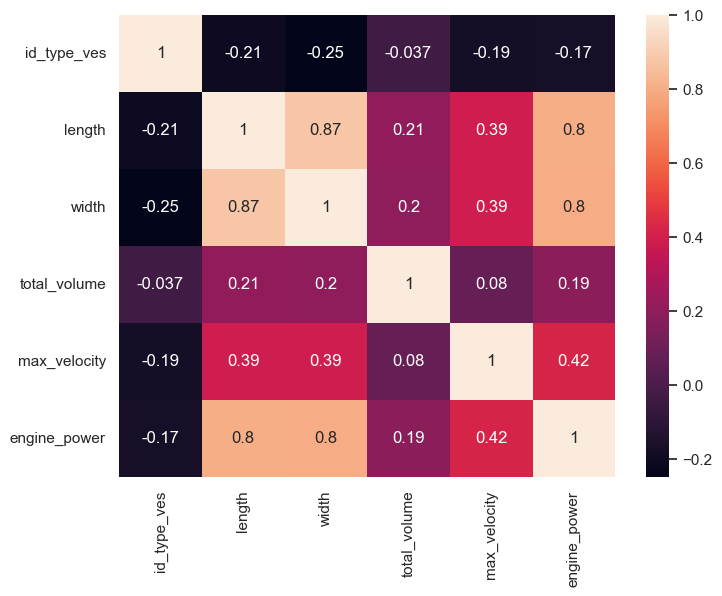

In [52]:
# корреляционная матрица
cols = [
    "id_type_ves",
    "length",
    "width",
    "total_volume",
    "max_velocity",
    "engine_power",
]
sns.set(rc={"figure.figsize": (8, 6)})
hm = sns.heatmap(df_ves[cols].corr(), cbar=True, annot=True)

### - значения коэффициента линейной корреляции позволяют сделать вывод, что в качестве предикторов для построения модели линейной регрессии целесообразно использовать длину судна (`length`), ширину судна (`width`) и максимальную скорость (`max_velocity`). Полное водоизмещение, вопреки ожиданиям, находится с исследуемым показателем в довольно слабой линейной взаимосвязи.

In [53]:
# удадление строк с пустыми значениями для обучения модели
df_ves_model = df_ves[~df_ves.isna().any(1)]

In [54]:
# построение и обучение модель линейной регрессии
X, y = df_ves_model[["length", "width", "max_velocity"]], df_ves_model["engine_power"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=27
)
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [55]:
# оценка качества модели (RMSE)
print(
    f"Среднеквадратичная ошибка:\n- для обучающей выборки {math.sqrt(mean_squared_error(y_train, model.predict(X_train)))}\n- для тестовой выборки {math.sqrt(mean_squared_error(y_test, model.predict(X_test)))}"
)
print(
    f"Отноншение значений: {round(abs(1-(math.sqrt(mean_squared_error(y_test, model.predict(X_test))))/(math.sqrt(mean_squared_error(y_train, model.predict(X_train)))))*100, 2)} %."
)

Среднеквадратичная ошибка:
- для обучающей выборки 810.9331732799496
- для тестовой выборки 796.9131698238408
Отноншение значений: 1.73 %.


### Модель отвечает предъявляемым требованиям. 
### - применение модели для прогнозирования величины мощности ГЭУ судна "20508".

In [56]:
params = pd.DataFrame([{"length": 94.0, "width": 15.92, "max_velocity": 16.0}])
print(
    f"Прогнозируемое значение мощности ГЭУ для судна 20508:  {round(model.predict(params)[0], 1)} кВт."
)

Прогнозируемое значение мощности ГЭУ для судна 20508:  3105.6 кВт.


#### а) сравнение со средним значением мощности ГЭУ для судов аналогичного типа:

In [57]:
# меры центральной тенденции для мощности ГЭУ судов типа "120"
df_ves[df_ves.id_type_ves == 120].agg({"engine_power": ["mean", "median"]})

,engine_power
mean,3323.0
median,3824.0


#### б) сравнение со средним значением мощности ГЭУ для судов аналогичной длины:

In [58]:
# меры центральной тенденции мощности ГЭУ для судов длиной 94 метра
df_ves[df_ves.length == 94].agg({"engine_power": ["mean", "median"]})

,engine_power
mean,2454.5
median,2641.5


#### в) сравнение со средним значением мощности ГЭУ для судов с аналогичной максимальной скоростью:

In [59]:
# меры центральной тенденции мощности ГЭУ для судов, обладающих максимальной скоростью 16 узлов
df_ves[df_ves.max_velocity == 16].agg({"engine_power": ["mean", "median"]})

,engine_power
mean,4164.862745
median,4800.000000


### Таким образом, полученное значение достаточно правдоподобно и может быть использовано для исследования.

In [60]:
# замена отсутствующих данных о мощности ГЭУ для судна "20508"
df_fishing.loc[df_fishing.id_ves == 20508, ["engine_power"]] = round(
    model.predict(params)[0], 1
)

In [61]:
# данные с учётом восстановленных значений
df_fishing

,id_ves,date,latitude,longitude,id_oper,oper_quantity,oper_time,catch_depth,catch_volume_total,id_oper_full,id_type_ves,length,width,total_volume,max_velocity,engine_power,id_region,id_fish,catch_volume_fish,id_regime
0,11244,2019-11-01,52.86,154.83,20.0,13.0,19.7,190.0,20.70,52.0,186.0,45.54,11.5,1315.0,12.3,1440.0,272.0,292.0,20.60,1.0
1,11244,2019-11-01,52.86,154.83,20.0,13.0,19.7,190.0,20.70,52.0,186.0,45.54,11.5,1315.0,12.3,1440.0,272.0,144.0,0.09,97.0
2,11767,2019-11-01,51.75,155.60,12.0,3.0,12.0,250.0,100.38,617.0,167.0,57.50,13.0,1944.0,14.5,2460.0,272.0,400.0,100.38,1.0
3,11731,2019-11-01,52.30,155.01,20.0,12.0,21.0,190.0,22.08,52.0,186.0,45.54,11.5,1315.0,12.3,1060.0,272.0,292.0,22.08,1.0
4,11768,2019-11-01,52.46,155.96,16.0,3.0,3.0,83.0,66.48,513.0,171.0,39.52,9.3,448.0,10.4,589.0,272.0,451.0,66.01,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33669,12161,2020-01-05,51.68,154.93,78.0,2.0,2.0,170.0,12.40,78.0,206.0,30.19,7.0,168.0,10.0,224.0,272.0,400.0,1.70,12.0
33670,12161,2020-01-05,51.68,154.93,78.0,2.0,2.0,170.0,12.40,78.0,206.0,30.19,7.0,168.0,10.0,224.0,272.0,403.0,4.00,12.0
33671,12161,2020-01-05,51.68,154.93,78.0,2.0,2.0,170.0,12.40,78.0,206.0,30.19,7.0,168.0,10.0,224.0,272.0,451.0,0.10,12.0
33672,12161,2020-01-05,51.68,154.93,78.0,2.0,2.0,170.0,12.40,78.0,206.0,30.19,7.0,168.0,10.0,224.0,272.0,677.0,0.10,97.0


In [62]:
# проверка отсутствия пропусков мощности ГЭУ
df_nopower = df_fishing[df_fishing.engine_power.isna()]
df_nopower

,id_ves,date,latitude,longitude,id_oper,oper_quantity,oper_time,catch_depth,catch_volume_total,id_oper_full,id_type_ves,length,width,total_volume,max_velocity,engine_power,id_region,id_fish,catch_volume_fish,id_regime


In [63]:
df_fishing.info()  # проверка качества данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33674 entries, 0 to 33673
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   id_ves              33674 non-null  int64         
 1   date                33674 non-null  datetime64[ns]
 2   latitude            33674 non-null  float64       
 3   longitude           33674 non-null  float64       
 4   id_oper             33674 non-null  float64       
 5   oper_quantity       33674 non-null  float64       
 6   oper_time           33674 non-null  float64       
 7   catch_depth         33638 non-null  float64       
 8   catch_volume_total  33674 non-null  float64       
 9   id_oper_full        33674 non-null  float64       
 10  id_type_ves         33674 non-null  float64       
 11  length              33674 non-null  float64       
 12  width               33452 non-null  float64       
 13  total_volume        33452 non-null  float64   

### Данные качественные, информация о мощности ГЭУ восстановлена.

### 1.10.2. Восстановление информации о горизонте траления
### - при восстановлении указанной информации целесообразно сопоставить данные о величине горизонта траления судов, использовавшихся с аналогичным орудием лова в районе нахождения исследуемых судов в те же промысловые сутки. Исходя из того, что всеми судами при этом облавливается одно промысловое скопление, горизонты траления должны быть близки или совпадать.

In [64]:
# записи с отсутствием данных о величине горизонта траления
df_nocatch_depth = df_fishing[df_fishing.catch_depth.isna()]
df_nocatch_depth

,id_ves,date,latitude,longitude,id_oper,oper_quantity,oper_time,catch_depth,catch_volume_total,id_oper_full,id_type_ves,length,width,total_volume,max_velocity,engine_power,id_region,id_fish,catch_volume_fish,id_regime
30985,10650,2020-10-13,47.91,148.05,99.0,2.0,3.3,NaN,0.020,775.0,318.0,62.2,13.8,2062.0,12.0,1764.0,275.0,249.0,0.006,3.0
30986,10650,2020-10-13,47.91,148.05,99.0,2.0,3.3,NaN,0.020,775.0,318.0,62.2,13.8,2062.0,12.0,1764.0,275.0,400.0,0.002,3.0
30987,10650,2020-10-13,47.91,148.05,99.0,2.0,3.3,NaN,0.020,775.0,318.0,62.2,13.8,2062.0,12.0,1764.0,275.0,558.0,0.010,3.0
31016,10650,2020-10-14,50.00,150.35,99.0,2.0,4.2,NaN,0.002,775.0,318.0,62.2,13.8,2062.0,12.0,1764.0,275.0,249.0,0.002,3.0
31052,10650,2020-10-15,50.73,150.13,99.0,2.0,3.3,NaN,0.040,775.0,318.0,62.2,13.8,2062.0,12.0,1764.0,275.0,249.0,0.030,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31419,10650,2020-10-25,46.98,145.66,99.0,2.0,4.2,NaN,0.070,775.0,318.0,62.2,13.8,2062.0,12.0,1764.0,275.0,400.0,0.003,3.0
31420,10650,2020-10-25,46.98,145.66,99.0,2.0,4.2,NaN,0.070,775.0,318.0,62.2,13.8,2062.0,12.0,1764.0,275.0,558.0,0.020,3.0
31443,10650,2020-10-26,45.83,142.56,99.0,3.0,4.9,NaN,0.070,775.0,318.0,62.2,13.8,2062.0,12.0,1764.0,275.0,249.0,0.030,3.0
31444,10650,2020-10-26,45.83,142.56,99.0,3.0,4.9,NaN,0.070,775.0,318.0,62.2,13.8,2062.0,12.0,1764.0,275.0,558.0,0.040,3.0


In [65]:
# количество судов, для которых отсутствует информация о горизонте траления
df_nocatch_depth.id_ves.nunique()

2

### Суда, для которых частично отсутствуют данные о горизонтах траления, имеют коды "10650" и "17683".

### а) судно "10650":

In [66]:
# судно использовалось в районе с границами
pd.concat(
    [
        df_nocatch_depth[df_nocatch_depth.id_ves == 10650].agg(
            {"latitude": ["min", "max"]}
        ),
        df_nocatch_depth[df_nocatch_depth.id_ves == 10650].agg(
            {"longitude": ["min", "max"]}
        ),
    ],
    axis=1,
)

,latitude,longitude
min,45.83,142.56
max,53.50,150.35


In [67]:
# в период времени
df_nocatch_depth[df_nocatch_depth.id_ves == 10650].agg({"date": ["min", "max"]})

,date
min,2020-10-13
max,2020-10-26


In [68]:
# с орудием лова
print(*set(df_nocatch_depth[df_nocatch_depth.id_ves == 10650].id_oper))

99.0


### - суда, использовавшиеся для добычи орудием "99" в том же районе в период с 13 по 26 октября 2020 г.

In [69]:
# применение условий (фильтров)
df_1 = df_fishing.loc[
    (df_fishing.date >= "2020-10-13")
    & (df_fishing.date <= "2020-10-26")
    & (df_fishing.latitude >= 45.83)
    & (df_fishing.latitude <= 53.50)
    & (df_fishing.longitude >= 142.56)
    & (df_fishing.longitude <= 150.35)
    & (df_fishing.id_oper == 99)
    & (df_fishing.id_ves != 10650)
]

In [70]:
df_1

,id_ves,date,latitude,longitude,id_oper,oper_quantity,oper_time,catch_depth,catch_volume_total,id_oper_full,id_type_ves,length,width,total_volume,max_velocity,engine_power,id_region,id_fish,catch_volume_fish,id_regime
31421,10644,2020-10-25,50.91,144.96,99.0,2.0,3.4,20.0,0.01,775.0,318.0,62.2,13.8,2062.0,10.5,1764.0,275.0,249.0,0.01,3.0
31446,10644,2020-10-26,47.26,144.63,99.0,3.0,4.7,20.0,0.03,775.0,318.0,62.2,13.8,2062.0,10.5,1764.0,275.0,249.0,0.03,3.0


### - помимо судна "10650" в рассматриваемом районе использовалось судно "10644", для которого величина горизионта траления составляла 20 метров.   

In [71]:
# суда, использовавшиеся в указанном районе в данный период без органичения орудий лова:
df_2 = df_fishing.loc[
    (df_fishing.date >= "2020-10-13")
    & (df_fishing.date <= "2020-10-26")
    & (df_fishing.latitude >= 45.83)
    & (df_fishing.latitude <= 53.50)
    & (df_fishing.longitude >= 142.56)
    & (df_fishing.longitude <= 150.35)
    & (df_fishing.id_ves != 10650)
]
pd.DataFrame(df_2.groupby("id_oper").catch_depth.mean())

,catch_depth
id_oper,
12.0,127.00
17.0,916.25
99.0,20.00


### Величина горизонта травления используемых орудий лова резко отличается:   
### - для орудия лова "12" составляет 127 метров;   
### - для орудия лова "17" составляет 916.25 метра;   
### - для орудия лова "99" (аналогичного используемому на судне "10650") 20 метров.   
### Указанная разница может быть объяснена исключительно особенностями добычи соответсвующими орудиями лова, следовательно для оценки наиболее вероятной величины горизонта траления судна "10650"целесообразно использовать только данные о применении орудия "99".

In [72]:
# восстановление данных о горизонте траления судном 10650
dt = [
    "2020-10-13",
    "2020-10-14",
    "2020-10-15",
    "2020-10-16",
    "2020-10-17",
    "2020-10-18",
    "2020-10-19",
    "2020-10-20",
    "2020-10-21",
    "2020-10-22",
    "2020-10-23",
    "2020-10-24",
    "2020-10-25",
    "2020-10-26",
]
df_fishing.loc[
    (df_fishing.id_ves == 10650) & (df_fishing.date.isin(dt)), ["catch_depth"]
] = 20
df_fishing.loc[(df_fishing.id_ves == 10650) & (df_fishing.date.isin(dt))]

,id_ves,date,latitude,longitude,id_oper,oper_quantity,oper_time,catch_depth,catch_volume_total,id_oper_full,id_type_ves,length,width,total_volume,max_velocity,engine_power,id_region,id_fish,catch_volume_fish,id_regime
30985,10650,2020-10-13,47.91,148.05,99.0,2.0,3.3,20.0,0.020,775.0,318.0,62.2,13.8,2062.0,12.0,1764.0,275.0,249.0,0.006,3.0
30986,10650,2020-10-13,47.91,148.05,99.0,2.0,3.3,20.0,0.020,775.0,318.0,62.2,13.8,2062.0,12.0,1764.0,275.0,400.0,0.002,3.0
30987,10650,2020-10-13,47.91,148.05,99.0,2.0,3.3,20.0,0.020,775.0,318.0,62.2,13.8,2062.0,12.0,1764.0,275.0,558.0,0.010,3.0
31016,10650,2020-10-14,50.00,150.35,99.0,2.0,4.2,20.0,0.002,775.0,318.0,62.2,13.8,2062.0,12.0,1764.0,275.0,249.0,0.002,3.0
31052,10650,2020-10-15,50.73,150.13,99.0,2.0,3.3,20.0,0.040,775.0,318.0,62.2,13.8,2062.0,12.0,1764.0,275.0,249.0,0.030,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31418,10650,2020-10-25,46.98,145.66,99.0,2.0,4.2,20.0,0.070,775.0,318.0,62.2,13.8,2062.0,12.0,1764.0,275.0,249.0,0.050,3.0
31419,10650,2020-10-25,46.98,145.66,99.0,2.0,4.2,20.0,0.070,775.0,318.0,62.2,13.8,2062.0,12.0,1764.0,275.0,400.0,0.003,3.0
31420,10650,2020-10-25,46.98,145.66,99.0,2.0,4.2,20.0,0.070,775.0,318.0,62.2,13.8,2062.0,12.0,1764.0,275.0,558.0,0.020,3.0
31443,10650,2020-10-26,45.83,142.56,99.0,3.0,4.9,20.0,0.070,775.0,318.0,62.2,13.8,2062.0,12.0,1764.0,275.0,249.0,0.030,3.0


### б) судно "17683":

In [73]:
df_nocatch_depth.loc[df_nocatch_depth.id_ves == 17683]

,id_ves,date,latitude,longitude,id_oper,oper_quantity,oper_time,catch_depth,catch_volume_total,id_oper_full,id_type_ves,length,width,total_volume,max_velocity,engine_power,id_region,id_fish,catch_volume_fish,id_regime
31524,17683,2020-10-29,56.71,145.65,12.0,2.0,4.5,NaN,99.43,102.0,116.0,96.7,16.0,4407.0,16.1,5146.0,273.0,400.0,99.43,1.0


### - имеется единственная запись, что не позволяет установить границы района, в котром могла осуществляться добыча судами с аналогичным орудием лова. По аналогии с ранее исследованным судном "10650" принято значение размаха по широте и долготе 8 градусов.

In [74]:
# применение условий (фильтров) и определение мер центральной тенденции для судов в районе
df_3 = df_fishing.loc[
    (df_fishing.date == "2020-10-29")
    & (df_fishing.latitude >= 52.71)
    & (df_fishing.latitude <= 60.71)
    & (df_fishing.longitude >= 141.65)
    & (df_fishing.longitude <= 149.65)
    & (df_fishing.id_ves != 17683)
    & (df_fishing.id_oper == 12)
]
df_3.agg({"catch_depth": ["max", "min", "mean", "median"]})

,catch_depth
max,366.0
min,150.0
mean,278.0
median,280.5


### На основании анализа результатов использования орудия лова "12" в указанном районе, значению `catch_depth` для судна "17683" присвоено среднее значение 278.

In [75]:
# присвоение данных
df_fishing.loc[
    (df_fishing.id_ves == 17683) & (df_fishing.date == "2020-10-29"), ["catch_depth"]
] = 278
df_fishing.loc[(df_fishing.id_ves == 17683) & (df_fishing.date == "2020-10-29")]

,id_ves,date,latitude,longitude,id_oper,oper_quantity,oper_time,catch_depth,catch_volume_total,id_oper_full,id_type_ves,length,width,total_volume,max_velocity,engine_power,id_region,id_fish,catch_volume_fish,id_regime
31524,17683,2020-10-29,56.71,145.65,12.0,2.0,4.5,278.0,99.43,102.0,116.0,96.7,16.0,4407.0,16.1,5146.0,273.0,400.0,99.43,1.0


In [76]:
df_fishing.info()  # контроль качества данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33674 entries, 0 to 33673
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   id_ves              33674 non-null  int64         
 1   date                33674 non-null  datetime64[ns]
 2   latitude            33674 non-null  float64       
 3   longitude           33674 non-null  float64       
 4   id_oper             33674 non-null  float64       
 5   oper_quantity       33674 non-null  float64       
 6   oper_time           33674 non-null  float64       
 7   catch_depth         33674 non-null  float64       
 8   catch_volume_total  33674 non-null  float64       
 9   id_oper_full        33674 non-null  float64       
 10  id_type_ves         33674 non-null  float64       
 11  length              33674 non-null  float64       
 12  width               33452 non-null  float64       
 13  total_volume        33452 non-null  float64   

### Данные восстановлены, формат верный.

### 10.1.3. Поиск и исследование дубликатов записей

In [77]:
df_fishing.loc[df_fishing.duplicated()]

,id_ves,date,latitude,longitude,id_oper,oper_quantity,oper_time,catch_depth,catch_volume_total,id_oper_full,id_type_ves,length,width,total_volume,max_velocity,engine_power,id_region,id_fish,catch_volume_fish,id_regime


### Дубликаты отсутствуют.   


## Исходные данные для проведения исследования сформированы. Частичное отсутствие информации о ширине, полном водоизмещении и максимальной скорости отдельных судов для продолжения исследования значения не имеет, соответствующие атрибуты могут быть удалены.
***

# **2. Классификация судов**

In [78]:
# удаление неактуальных данных
df_fishing_class = df_fishing.drop(
    [
        "catch_volume_total",
        "length",
        "width",
        "total_volume",
        "max_velocity",
        "id_oper_full",
        "oper_time",
    ],
    axis=1,
)

# набор данных не содержит пустых значений, что позволяет преобразовать формат данных так, как им и надлежит быть по их внутренней логике
df_fishing_class = df_fishing_class.astype(
    {
        "id_oper": "int",
        "oper_quantity": "int",
        "id_type_ves": "int",
        "id_region": "int",
        "id_fish": "int",
        "id_regime": "int",
    }
)

In [79]:
df_fishing_class.info()  # контроль качества данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33674 entries, 0 to 33673
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id_ves             33674 non-null  int64         
 1   date               33674 non-null  datetime64[ns]
 2   latitude           33674 non-null  float64       
 3   longitude          33674 non-null  float64       
 4   id_oper            33674 non-null  int64         
 5   oper_quantity      33674 non-null  int64         
 6   catch_depth        33674 non-null  float64       
 7   id_type_ves        33674 non-null  int64         
 8   engine_power       33674 non-null  float64       
 9   id_region          33674 non-null  int64         
 10  id_fish            33674 non-null  int64         
 11  catch_volume_fish  33674 non-null  float64       
 12  id_regime          33674 non-null  int64         
dtypes: datetime64[ns](1), float64(5), int64(7)
memory usage: 3.3 

### Данные полные и качественные, формат корректный.

In [80]:
# исходные данные для классификации судов
df_fishing_class

,id_ves,date,latitude,longitude,id_oper,oper_quantity,catch_depth,id_type_ves,engine_power,id_region,id_fish,catch_volume_fish,id_regime
0,11244,2019-11-01,52.86,154.83,20,13,190.0,186,1440.0,272,292,20.60,1
1,11244,2019-11-01,52.86,154.83,20,13,190.0,186,1440.0,272,144,0.09,97
2,11767,2019-11-01,51.75,155.60,12,3,250.0,167,2460.0,272,400,100.38,1
3,11731,2019-11-01,52.30,155.01,20,12,190.0,186,1060.0,272,292,22.08,1
4,11768,2019-11-01,52.46,155.96,16,3,83.0,171,589.0,272,451,66.01,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
33669,12161,2020-01-05,51.68,154.93,78,2,170.0,206,224.0,272,400,1.70,12
33670,12161,2020-01-05,51.68,154.93,78,2,170.0,206,224.0,272,403,4.00,12
33671,12161,2020-01-05,51.68,154.93,78,2,170.0,206,224.0,272,451,0.10,12
33672,12161,2020-01-05,51.68,154.93,78,2,170.0,206,224.0,272,677,0.10,97


## Целью классификации судов является объединение их в группы, однородные по производительности вылова. Производительность вылова, очевидно, прямо пропорциональна мощности ГЭУ, поскольку этот показатель характеризует способность судна перемещать тралящее орудие лова. Вторым признаком классификации является конструктивный тип судна, который характеризует, главным образом, возможность перерабатывать и хранить уловы и продукцию на судне, что потенциально может ограничивать макимальную производительность вылова. Таким образом, классификацию судов целесообразно осуществить по двум параметрам, после чего результаты классификации по каждому параметру объединить.

In [81]:
# коды конструктивных типов судов
df_fishing_class.id_type_ves.unique()

array([ 186,  167,  171,  146,  168,  136,  116,  206,  120,  112,  128,
        170,  153,  141,  115,  485,  208,  241,  287,  513,  148,  248,
        127,  164,  205,  518,  179,  182,  166,  294,  601,  151,  505,
        508,  502,  190,  318,  501,  192,  296, 1058,  303,  147,  152,
        298,  519,  196, 1022])

## **2.1. Классификация судов по конструктивному типу** 
## С целью классификации проведено исследование возможности того, что некоторые из типов судов могут представлять собой подтипы одного типа (например, разные проекты судов внутри одного типа), не имеющих существенных отличий в производительности вылова, с последующим присвоением судам кода родительского типа.
### 2.1.1. Загрузка справочника типов судов
### *Состав данных*:
### - `type_ves_full` - полное наименование родительского типа судна.

In [82]:
# загрузка справочника судов
df_type_ves = pd.read_csv(
    "/home/sk27/learning/graduation_project/data/type_ves.csv",
    sep=";",
    encoding="cp1251",
).apply(pd.to_numeric, errors="ignore")
df_type_ves

,id_type_ves,type_ves,type_ves_full
0,0,не определен,NaN
1,1,Добывающие,NaN
2,2,Обрабатывающие,NaN
3,3,Приемно-транспортные,NaN
4,4,Вспомогательные,NaN
...,...,...,...
477,248,МРКТ несерийн.,NaN
478,1044,МРКТ,Морозильный рыболовный консервный траулер
479,529,МРБ пр. 902-Т,NaN
480,11,Для коммерческого мониторинга Иридиум,NaN


### 2.1.2. Для исключения избыточно подробной типизации объединены в группы типы судов, в названии которых содержится аббревиатрура родительского типа судна. Принадлежность к группе типов судов обозначена кодом, имеющим наибольшее абсолютное значение внутри группы:

In [83]:
# родительские типы судов
df_type_ves[pd.notna(df_type_ves.type_ves_full)]

,id_type_ves,type_ves,type_ves_full
182,293,МЯ,Малый ярусолов
373,1011,РТКС,Рыболовный траулер консервный(супер)
374,1012,РТМКС,Рыболовный траулер морозильно-консервный(супер)
375,1014,РТМС,Рыболовный траулер морозильный(супер)
376,1015,РКТС,Рыболовно-крилевый траулер(супер)
...,...,...,...
466,1154,МмТК,Маломерный траулер-катамаран
467,1155,МмТБ,Маломерный тунцеловный бот
468,1156,МмТБНР,Маломерный траловый бот нерефрижераторный
470,1157,МКРТМ,Малый креветко-рыболовный траулер рефрижераторный


### - формирование словаря, в котором ключами являются коды родительского типа судна, а значениями - списки кодов типов судов, относящихся к родительскому типу.

In [84]:
# формирование списка кодов родительских типов судов
type_dict = {}
type_dict_num = {}
for index, row in df_type_ves.iterrows():
    if pd.notna(row["type_ves_full"]):
        type_dict[row.type_ves] = [row.id_type_ves]

# формирование словаря, где ключом является аббривеатура родительского типа, а значениями - списки кодов, относящихся к родительскому типу
for index, row in df_type_ves.iterrows():
    for key, value in type_dict.items():
        if key in row.type_ves.split():
            type_dict[key] = [value] + [row.id_type_ves]

# "сглаживание" списков и замена строковых ключей словаря на код родительского типа
for key, value in type_dict.items():
    list_type = list(flatten(value))
    key = max(list_type)
    type_dict_num[key] = list_type

In [85]:
# словарь соответствия типов судов
type_dict_num

{1064: [1064, 293, 1064],
 1011: [1011, 111, 1011],
 1012: [1012, 112, 182, 1012],
 1014: [1014, 113, 114, 127, 1014],
 1015: [1015, 115, 1015],
 1020: [1020, 1020, 526],
 1021: [1021, 138, 601, 1021],
 1022: [1022,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  128,
  136,
  137,
  513,
  1022],
 1023: [1023, 185, 1023],
 1024: [1024, 129, 130, 287, 1024],
 1025: [1025, 139, 140, 1025],
 1026: [1026, 131, 188, 1026],
 1027: [1027, 132, 1027],
 1029: [1029, 134, 1029],
 1031: [1031, 150, 1031, 241],
 1032: [1032, 141, 142, 143, 186, 1032],
 1033: [1033,
  144,
  600,
  145,
  146,
  152,
  153,
  154,
  155,
  156,
  167,
  168,
  184,
  1033,
  294],
 1034: [1034, 147, 158, 1034],
 1035: [1035, 148, 149, 159, 162, 1035],
 1036: [1036, 518, 1036],
 1037: [1037, 151, 157, 160, 161, 1037],
 1038: [1038, 165, 1038],
 1055: [1055, 174, 202, 209, 519, 1039, 1055, 243, 289],
 1040: [1040, 164, 170, 171, 1040],
 1041: [1041, 175, 1041],
 1042: [1042, 176, 291, 

In [86]:
# вспомогательная функция
def type_rep(row):
    """функция обеспечивает замену кода конструктивного типа судна на код родительского типа судна"""
    for key, value in type_dict_num.items():
        if row in value:
            return key

In [87]:
# замена кодов типа судна
df_fishing_class.insert(1, "type_ves", df_fishing_class["id_type_ves"].apply(type_rep))

In [88]:
df_fishing_class.info()  # контроль качества данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33674 entries, 0 to 33673
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id_ves             33674 non-null  int64         
 1   type_ves           33393 non-null  float64       
 2   date               33674 non-null  datetime64[ns]
 3   latitude           33674 non-null  float64       
 4   longitude          33674 non-null  float64       
 5   id_oper            33674 non-null  int64         
 6   oper_quantity      33674 non-null  int64         
 7   catch_depth        33674 non-null  float64       
 8   id_type_ves        33674 non-null  int64         
 9   engine_power       33674 non-null  float64       
 10  id_region          33674 non-null  int64         
 11  id_fish            33674 non-null  int64         
 12  catch_volume_fish  33674 non-null  float64       
 13  id_regime          33674 non-null  int64         
dtypes: dat

### В данных о типах судов присутствуют пропуски, в остальном данные качественные.

### 2.1.3. Устранение пропусков данных в типах судов.

In [89]:
# код типа судна, для которого не была произведена  замена кода типа на код родтельского типа
df_fishing_class[pd.isna(df_fishing_class.type_ves)]["id_type_ves"].unique()

array([208])

### Пустые значения получены для кода типа судна "208".

In [90]:
df_type_ves[df_type_ves.id_type_ves == 208]

,id_type_ves,type_ves,type_ves_full
108,208,СКТР несериный,NaN


In [91]:
df_type_ves[df_type_ves.type_ves == "СКТР"]

,id_type_ves,type_ves,type_ves_full


### - для типа судна "СКТР" отсутствует расшифровка аббривеатуры, по этой причине данные не были обработаны. Целесообразно провести замену на тип судна, наиболее близкие по мощности ГЭУ.

In [92]:
# среднее значение мощности ГЭУ для судов типа "208"
df_ves[df_ves.id_type_ves == 208]["engine_power"].mean().round(2)

1691.67

In [93]:
# средние значения мощности ГЭУ для идентифицированных судов
df_fishing_class.groupby("type_ves")["engine_power"].mean().round(2).sort_values()

type_ves
1151.0     124.65
1152.0     125.83
1153.0     134.16
1051.0     373.00
1058.0     441.69
1157.0     589.00
1049.0     589.00
1035.0     699.80
1036.0     794.05
1021.0     882.00
1034.0     882.00
1032.0     930.13
1040.0     992.75
1071.0    1013.75
1055.0    1029.00
1043.0    1143.33
1083.0    1746.92
1033.0    1784.06
1037.0    2040.94
1031.0    2355.00
1024.0    2984.70
1014.0    4419.69
1022.0    4694.80
1015.0    5152.00
1012.0    5526.53
1044.0    5920.00
1117.0    6560.00
Name: engine_power, dtype: float64

### - видно, что по средней мощности ГЭУ суда типа "208" наиболее соответствуют судам типа "1083". Осуществлена замена отсутствующих значений в атрибуте `type_ves` на 1083.

In [94]:
# замена
df_fishing_class = df_fishing_class.fillna(1083)

In [95]:
df_fishing_class.info()  # контроль качества данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33674 entries, 0 to 33673
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id_ves             33674 non-null  int64         
 1   type_ves           33674 non-null  float64       
 2   date               33674 non-null  datetime64[ns]
 3   latitude           33674 non-null  float64       
 4   longitude          33674 non-null  float64       
 5   id_oper            33674 non-null  int64         
 6   oper_quantity      33674 non-null  int64         
 7   catch_depth        33674 non-null  float64       
 8   id_type_ves        33674 non-null  int64         
 9   engine_power       33674 non-null  float64       
 10  id_region          33674 non-null  int64         
 11  id_fish            33674 non-null  int64         
 12  catch_volume_fish  33674 non-null  float64       
 13  id_regime          33674 non-null  int64         
dtypes: dat

In [96]:
# преобразование типа данных
df_fishing_class = df_fishing_class.astype({"type_ves": "int"})

## **2.2. Классфикация по мощности ГЭУ в разрезе типа судна**
### - данныую классификацию целесообразно выполнить на основнии всего диапазона значений мощностей ГЭУ, разделив этот диапазон на 4 поддиапазона в соответствии с основными процентилями.

In [97]:
# значение соответствующих процентилей
level_25 = df_fishing_class["engine_power"].quantile(q=0.25, interpolation="linear")
level_50 = df_fishing_class["engine_power"].quantile(q=0.5, interpolation="linear")
level_75 = df_fishing_class["engine_power"].quantile(q=0.75, interpolation="linear")
print(level_25, level_50, level_75)


# вспомогательная функция
def power_class(engine_power):
    """функция возвращает класс мощности ГЭУ исходя из абсолютного значения мощности:
    - ниже 25 процентиля ("низкая"), присваивается код 3;
    - ниже 50 процентиля ("средняя"), присваивается код 2;
    - ниже 75 процентиля ("высокая"), присваивается код 1;
    - не ниже 75 процентиля ("сверхвысокая"), присваивается код 0.
    """
    if engine_power < level_25:
        return 3
    elif engine_power < level_50:
        return 2
    elif engine_power < level_75:
        return 1
    else:
        return 0

600.0 970.0 3200.0


In [98]:
# присвоение судам класса мощности ГЭУ
df_fishing_class["power_class"] = df_fishing_class["engine_power"].apply(power_class)

In [99]:
df_fishing_class.info()  # контроль качества данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33674 entries, 0 to 33673
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id_ves             33674 non-null  int64         
 1   type_ves           33674 non-null  int64         
 2   date               33674 non-null  datetime64[ns]
 3   latitude           33674 non-null  float64       
 4   longitude          33674 non-null  float64       
 5   id_oper            33674 non-null  int64         
 6   oper_quantity      33674 non-null  int64         
 7   catch_depth        33674 non-null  float64       
 8   id_type_ves        33674 non-null  int64         
 9   engine_power       33674 non-null  float64       
 10  id_region          33674 non-null  int64         
 11  id_fish            33674 non-null  int64         
 12  catch_volume_fish  33674 non-null  float64       
 13  id_regime          33674 non-null  int64         
 14  power_

## **2.3. Для завершения классификции судов каждому судну присваивается синтетический локальный класс, определяемый путём строкового сложения кода типа судна, кода класса мощности ГЭУ и кода орудия лова**

In [100]:
# изменение типа данных
df_fishing_class = df_fishing_class.astype(
    {
        "type_ves": "str",
        "power_class": "str",
        "id_oper": "str",
    }
)

# формирование кода синтетического класса и дополнение исходных данных
df_fishing_class.insert(
    1,
    "local_class_ves",
    df_fishing_class["type_ves"]
    + df_fishing_class["power_class"]
    + df_fishing_class["id_oper"],
)

# обратное преобразование типа данных
df_fishing_class = df_fishing_class.astype(
    {
        "local_class_ves": "int",
        "type_ves": "int",
        "power_class": "int",
        "id_oper": "int",
    }
)

In [101]:
# результат обработки информации
df_fishing_class

,id_ves,local_class_ves,type_ves,date,latitude,longitude,id_oper,oper_quantity,catch_depth,id_type_ves,engine_power,id_region,id_fish,catch_volume_fish,id_regime,power_class
0,11244,1032120,1032,2019-11-01,52.86,154.83,20,13,190.0,186,1440.0,272,292,20.60,1,1
1,11244,1032120,1032,2019-11-01,52.86,154.83,20,13,190.0,186,1440.0,272,144,0.09,97,1
2,11767,1033112,1033,2019-11-01,51.75,155.60,12,3,250.0,167,2460.0,272,400,100.38,1,1
3,11731,1032120,1032,2019-11-01,52.30,155.01,20,12,190.0,186,1060.0,272,292,22.08,1,1
4,11768,1040316,1040,2019-11-01,52.46,155.96,16,3,83.0,171,589.0,272,451,66.01,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33669,12161,1058378,1058,2020-01-05,51.68,154.93,78,2,170.0,206,224.0,272,400,1.70,12,3
33670,12161,1058378,1058,2020-01-05,51.68,154.93,78,2,170.0,206,224.0,272,403,4.00,12,3
33671,12161,1058378,1058,2020-01-05,51.68,154.93,78,2,170.0,206,224.0,272,451,0.10,12,3
33672,12161,1058378,1058,2020-01-05,51.68,154.93,78,2,170.0,206,224.0,272,677,0.10,97,3


In [102]:
df_fishing_class.info()  # контроль качества данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33674 entries, 0 to 33673
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id_ves             33674 non-null  int64         
 1   local_class_ves    33674 non-null  int64         
 2   type_ves           33674 non-null  int64         
 3   date               33674 non-null  datetime64[ns]
 4   latitude           33674 non-null  float64       
 5   longitude          33674 non-null  float64       
 6   id_oper            33674 non-null  int64         
 7   oper_quantity      33674 non-null  int64         
 8   catch_depth        33674 non-null  float64       
 9   id_type_ves        33674 non-null  int64         
 10  engine_power       33674 non-null  float64       
 11  id_region          33674 non-null  int64         
 12  id_fish            33674 non-null  int64         
 13  catch_volume_fish  33674 non-null  float64       
 14  id_reg

### Данные полные и качественные.

In [103]:
# количество синтетических классов
len(df_fishing_class["local_class_ves"].unique())

227

## Классификация судов завершена. Произведено удаление неактуальных данных и переименование набора для решения задачи кластеризации судов.

In [104]:
df_fc = df_fishing_class.drop(
    ["type_ves", "id_oper", "id_type_ves", "engine_power", "power_class"], axis=1
)

In [105]:
df_fc

,id_ves,local_class_ves,date,latitude,longitude,oper_quantity,catch_depth,id_region,id_fish,catch_volume_fish,id_regime
0,11244,1032120,2019-11-01,52.86,154.83,13,190.0,272,292,20.60,1
1,11244,1032120,2019-11-01,52.86,154.83,13,190.0,272,144,0.09,97
2,11767,1033112,2019-11-01,51.75,155.60,3,250.0,272,400,100.38,1
3,11731,1032120,2019-11-01,52.30,155.01,12,190.0,272,292,22.08,1
4,11768,1040316,2019-11-01,52.46,155.96,3,83.0,272,451,66.01,1
...,...,...,...,...,...,...,...,...,...,...,...
33669,12161,1058378,2020-01-05,51.68,154.93,2,170.0,272,400,1.70,12
33670,12161,1058378,2020-01-05,51.68,154.93,2,170.0,272,403,4.00,12
33671,12161,1058378,2020-01-05,51.68,154.93,2,170.0,272,451,0.10,12
33672,12161,1058378,2020-01-05,51.68,154.93,2,170.0,272,677,0.10,97


# **3. Кластеризация судов**

## - в целях сравнения видовых и объёмных показателей уловов, суда одного локального класса в разрезе промысловых суток необходимо объединить в кластеры по принципу расстояния между усреднёнными позициями судов в эти промысловые сутки. Для определения величины расстояния между судами одного локального класса, при непревышении которого эти суда должны быть отнесены к одному кластеру, следует руководствоваться требованиями Правил рыболовства для Дальневосточного рыбохозяйственного бассейна (утверждены приказом Минсельхоза России от 6 мая 2022 г. № 285). В частности, из смысла норм, установленных п.п. 38.4, 40, 43.1, 47 Правил следует, что промысловые скопления водных биоресурсов рассматриваются как однородные в радиусе 5 морских миль (длина 1 морской мили для указанных целей составляет 1,852 км) от конкретной точки.     
## - таким образом, задача кластеризации состоит в объединении в кластеры судов одного локального класса в разрезе кадждых промыловых суток так, чтобы расстояние между каждой парой судов внутри кластера не превышало 5 морских миль (9.26 километров).

In [106]:
# формирование списка дат промыслового года
date_list = sorted(list(set(df_fc["date"])))

In [107]:
# создание пусого набора данных для хранения общих результатов
df_result = pd.DataFrame()
for date in date_list:
    # создание пустого набора данных для хранения результатов в разрезе текущей даты
    df_dt = pd.DataFrame()
    # получение списка уникальных значений локального класса для данных промысловых суток
    local_class_ves_list = list(
        df_fc[df_fc["date"] == date]["local_class_ves"].unique()
    )
    # формирование набора данных для указанных суток и локального класса, взятого из сформированного списка
    for local_class in local_class_ves_list:
        df_local = df_fc[
            (df_fc["date"] == date) & ((df_fc["local_class_ves"] == local_class))
        ].reset_index(drop=True)
        # группировка полученных данных по коду судна и присвоение полученным группам номеров, которые становятся кодом кластера
        # на этом этапе каждое судно относится к отдельному кластеру
        df_local["cluster"] = df_local.groupby("id_ves")["id_ves"].ngroup()
        # соединение полученного набора данных с самим собой по принипу декартова произведения ("каждое с каждым")
        # вычисление расстояния в морских милях между точками в каждой паре
        df_cross = df_local.merge(df_local, how="cross")
        df_cross["dist"] = df_cross.apply(
            lambda row: GD(
                (row["latitude_x"], row["longitude_x"]),
                (row["latitude_y"], row["longitude_y"]),
            ).km
            / 1.852,
            axis=1,
        )
        # фильтрафия полученных данных, оставляя строки, в которых расстояние не более 5 морских миль и коды судов различаются,
        # удаление дубликатов записей
        df_cross = (
            df_cross[
                (df_cross["dist"] <= 5) & (df_cross["id_ves_x"] != df_cross["id_ves_y"])
            ][["date_x", "id_ves_x", "id_ves_y", "cluster_x", "cluster_y"]]
            .drop_duplicates()
            .reset_index(drop=True)
        )
        # создание словря, в котором каждому следующему коду судна сопоставляется код кластера
        # судна, находящегося от него на расстоянии не более 5 морских миль, если это судно уже
        # встречалось, иначе код кластера не изменяется
        cluster_dict = {}
        for index, row in df_cross.iterrows():
            if index == 0:
                cluster_dict[row["id_ves_x"]] = row["cluster_x"]
                cluster_dict[row["id_ves_y"]] = row["cluster_x"]
            else:
                if (
                    row["id_ves_x"] in cluster_dict.keys()
                    and row["id_ves_y"] not in cluster_dict.keys()
                ):
                    cluster_dict[row["id_ves_y"]] = row["cluster_x"]
                elif row["id_ves_x"] not in cluster_dict.keys():
                    cluster_dict[row["id_ves_x"]] = row["cluster_x"]
                    cluster_dict[row["id_ves_y"]] = row["cluster_x"]
                else:
                    pass
        # изменение значения кодов кластеров в первоначальном наборе данных для текущих суток и локального класса
        for key, value in cluster_dict.items():
            df_local["cluster"].where(
                ~(df_local["id_ves"] == key), other=value, inplace=True
            )
        # соединение полученных данных с результатами в разрезе текущей даты
        df_dt = pd.concat([df_dt, df_local])
    # соединение данные за текущую дату с общим набором данных
    df_result = pd.concat([df_result, df_dt]).reset_index(drop=True)

### - для удобства дальнейшей обработки данные объединены таким образом, чтобы каждый кластер идентифицировался уникальным кодом и добавлены данные о вылове в расчёте на одну промысловую операцию.

In [108]:
# добавление полных данных о кластере
df_result = df_result.astype(
    {
        "local_class_ves": "str",
        "date": "str",
        "cluster": "str",
    }
)
df_result.insert(
    1,
    "cluster_full",
    df_result["date"] + "_" + df_result["local_class_ves"] + "_" + df_result["cluster"],
)
df_result = df_result.astype(
    {
        "local_class_ves": "int",
        "date": "datetime64[ns]",
        "cluster": "int",
    }
)
# добавление информации о вылове в расчёте на одну промысловую операцию (траление)
df_result.insert(
    11,
    "catch_volume_fish_per_oper",
    (df_result["catch_volume_fish"] / df_result["oper_quantity"]).round(2),
)

In [109]:
df_result

,id_ves,cluster_full,local_class_ves,date,latitude,longitude,oper_quantity,catch_depth,id_region,id_fish,catch_volume_fish,catch_volume_fish_per_oper,id_regime,cluster
0,11244,2019-11-01_1032120_1,1032120,2019-11-01,52.86,154.83,13,190.0,272,292,20.60,1.58,1,1
1,11244,2019-11-01_1032120_1,1032120,2019-11-01,52.86,154.83,13,190.0,272,144,0.09,0.01,97,1
2,11731,2019-11-01_1032120_3,1032120,2019-11-01,52.30,155.01,12,190.0,272,292,22.08,1.84,1,3
3,11245,2019-11-01_1032120_2,1032120,2019-11-01,52.45,155.01,15,190.0,272,292,15.01,1.00,1,2
4,11245,2019-11-01_1032120_2,1032120,2019-11-01,52.45,155.01,15,190.0,272,144,0.19,0.01,97,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33669,12040,2020-10-31_1058317_0,1058317,2020-10-31,46.68,144.00,4,900.0,275,880,0.21,0.05,1,0
33670,22177,2020-10-31_1058112_0,1058112,2020-10-31,54.36,148.58,1,180.0,273,204,227.43,227.43,41,0
33671,22177,2020-10-31_1058112_0,1058112,2020-10-31,54.36,148.58,1,180.0,273,400,468.86,468.86,41,0
33672,12295,2020-10-31_1036320_0,1036320,2020-10-31,56.43,138.16,5,51.0,273,292,5.31,1.06,1,0


In [110]:
# подсчёт числа уникальных кластеров
n = df_result["cluster_full"].unique().shape[0]
print(f"Количество уникальных кластеров: {n}")

Количество уникальных кластеров: 19646


## Кластеризация завершена. Результаты вылова объединены в 19646 уникальных кластеров, удовлетворяющих следующим условиям:
### - кластер включает в себя суда идентичной производительности по вылову на каждую промысловую операцию;
### - кластер объединяет суда, в течение промыловых суток использовавшиеся для вылова в однородном в промысловом отношении районе.
## Таким образом, в пределах каждого кластера видовые показатели уловов должны быть полностью идентичны, а объёмные показатели не должны иметь различий выше статистической погрешности.
### Данные сохранены на жёсткий диск.

In [111]:
df_result.to_csv(
    "/home/sk27/learning/graduation_project/data/catch_cluster_full.csv", sep=";"
)

In [112]:
# вспомогательная ячейка: загрузка данных, чтобы не выполнять весь notebook
df_result = pd.read_csv(
    "/home/sk27/learning/graduation_project/data/catch_cluster_full.csv",
    sep=";",
    index_col=[0],
)

# **4. Статистический анализ видовых и объёмных показателей вылова**

## **4.1. Оценочное исследование полученных данных на примере 3 ноября 2019 г.**

In [113]:
df_test = df_result[df_result["date"] == "2019-11-03"]

In [114]:
df_test

,id_ves,cluster_full,local_class_ves,date,latitude,longitude,oper_quantity,catch_depth,id_region,id_fish,catch_volume_fish,catch_volume_fish_per_oper,id_regime,cluster
400,10518,2019-11-03_1022012_3,1022012,2019-11-03,54.61,153.40,3,460.0,273,400,399.24,133.08,1,3
401,13080,2019-11-03_1022012_18,1022012,2019-11-03,55.48,148.75,2,440.0,273,400,154.45,77.22,1,18
402,13102,2019-11-03_1022012_18,1022012,2019-11-03,55.43,148.71,1,460.0,273,400,26.46,26.46,1,18
403,46363,2019-11-03_1022012_24,1022012,2019-11-03,55.48,150.90,3,420.0,273,400,77.81,25.94,1,24
404,11200,2019-11-03_1022012_6,1022012,2019-11-03,54.45,153.33,3,440.0,273,400,171.39,57.13,1,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,20508,2019-11-03_10221968_0,10221968,2019-11-03,51.66,154.51,3,420.0,272,400,47.64,15.88,1,0
607,20601,2019-11-03_10220970_0,10220970,2019-11-03,54.55,153.41,3,450.0,274,400,70.01,23.34,1,0
608,20601,2019-11-03_10220970_0,10220970,2019-11-03,54.55,153.41,3,450.0,273,400,71.54,23.85,1,0
609,30108,2019-11-03_10220647_0,10220647,2019-11-03,54.36,153.35,3,340.0,273,400,159.25,53.08,1,0


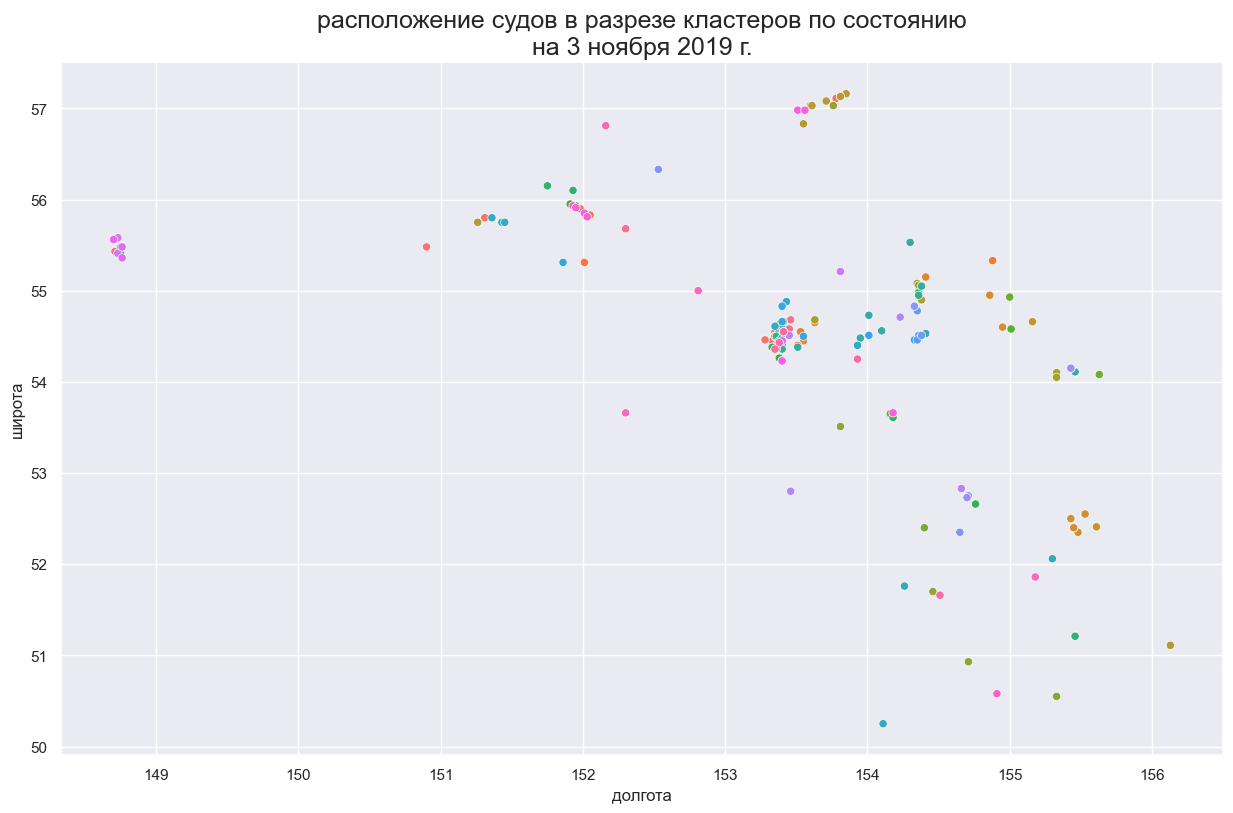

In [115]:
# визуализация данных о расположении судов
rcParams["figure.figsize"] = 15, 9
fig, ax = plt.subplots()
sns.scatterplot(
    ax=ax,
    data=df_test,
    x="longitude",
    y="latitude",
    hue="cluster_full",
    legend=False,
)
ax.set_xlabel(
    "долгота",
    size=12,
)
ax.set_ylabel("широта", size=12)
ax.set_title(
    "расположение судов в разрезе кластеров по состоянию\nна 3 ноября 2019 г.",
    size=18,
)
plt.show()

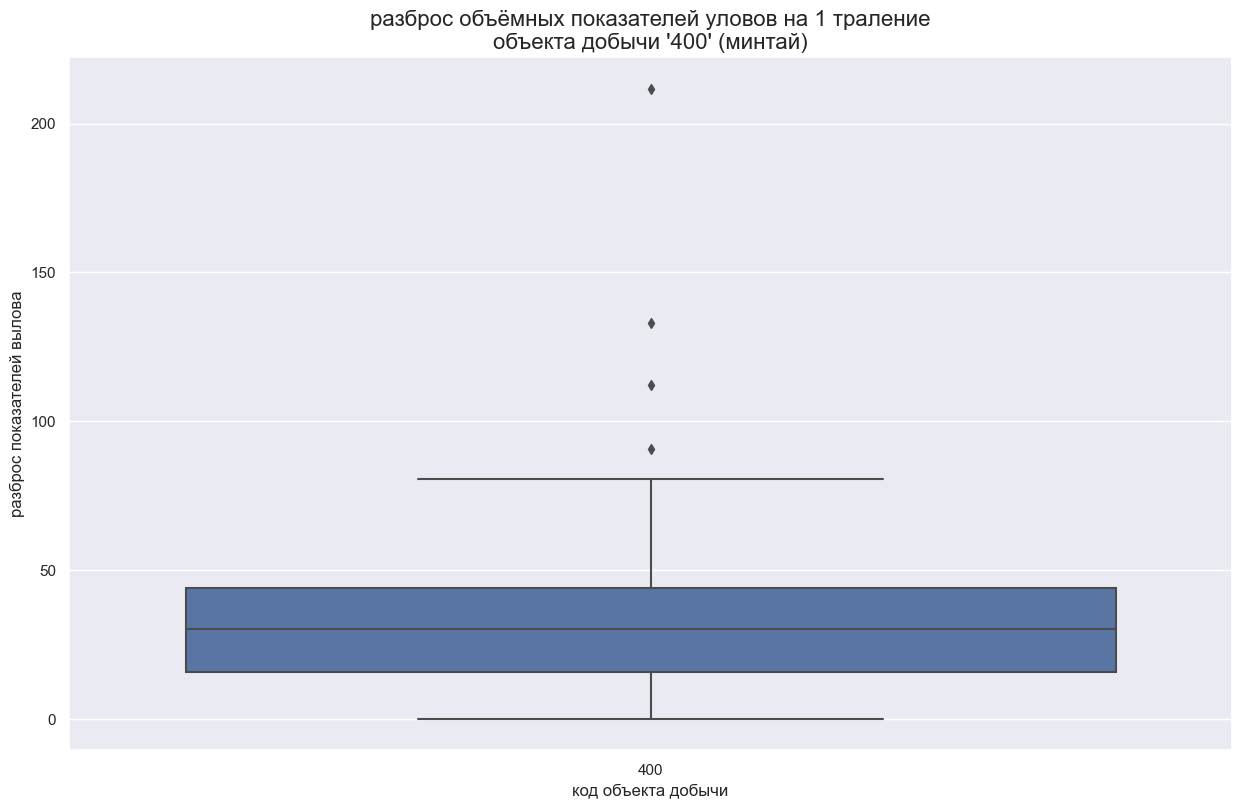

In [116]:
# визуализация разброса данных
rcParams["figure.figsize"] = 15, 9
ax = sns.boxplot(
    data=df_test[df_test["id_fish"] == 400], x="id_fish", y="catch_volume_fish_per_oper"
)
ax.set_xlabel(
    "код объекта добычи",
    size=12,
)
ax.set_ylabel("разброс показателей вылова", size=12)
ax.set_title(
    "разброс объёмных показателей уловов на 1 траление\nобъекта добычи '400' (минтай)",
    size=16,
)
plt.show()

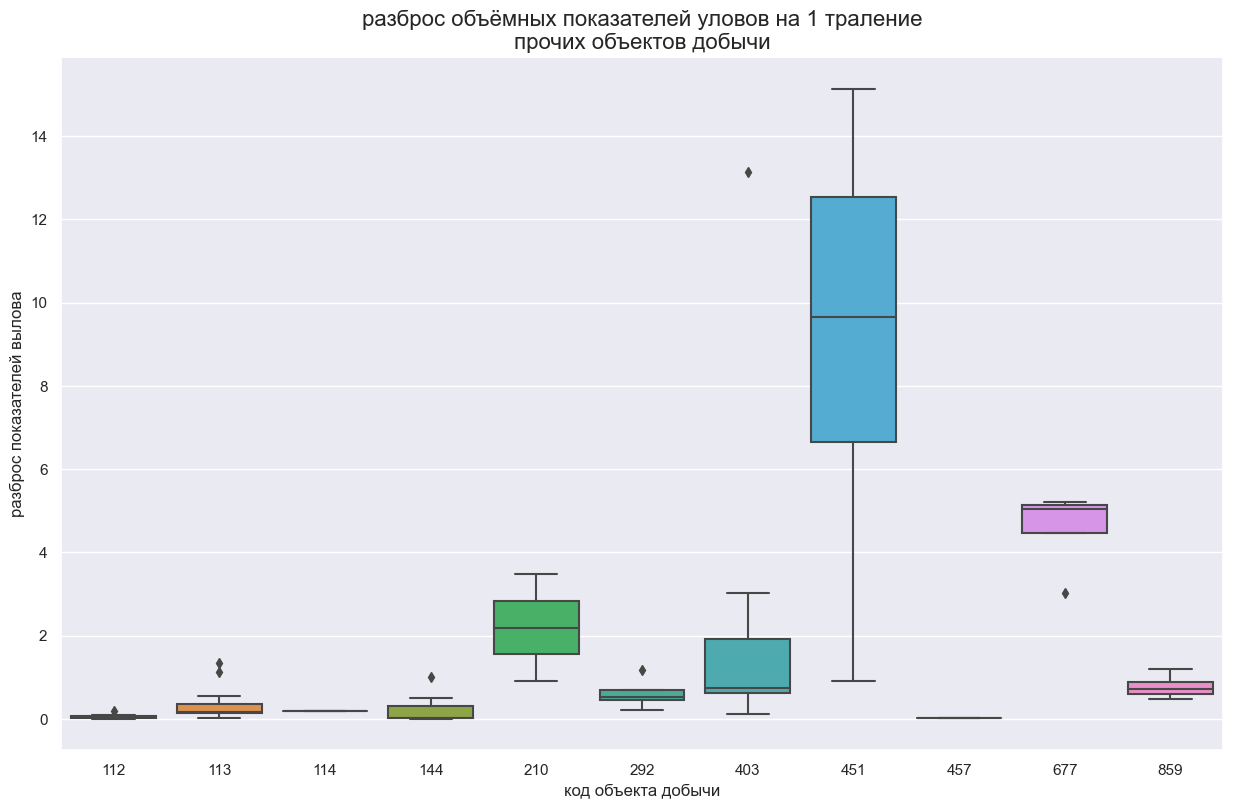

In [117]:
# визуализация разброса данных
rcParams["figure.figsize"] = 15, 9
ax = sns.boxplot(
    data=df_test[~(df_test["id_fish"] == 400)],
    x="id_fish",
    y="catch_volume_fish_per_oper",
)
ax.set_xlabel(
    "код объекта добычи",
    size=12,
)
ax.set_ylabel("разброс показателей вылова", size=12)
ax.set_title(
    "разброс объёмных показателей уловов на 1 траление\nпрочих объектов добычи",
    size=16,
)
plt.show()

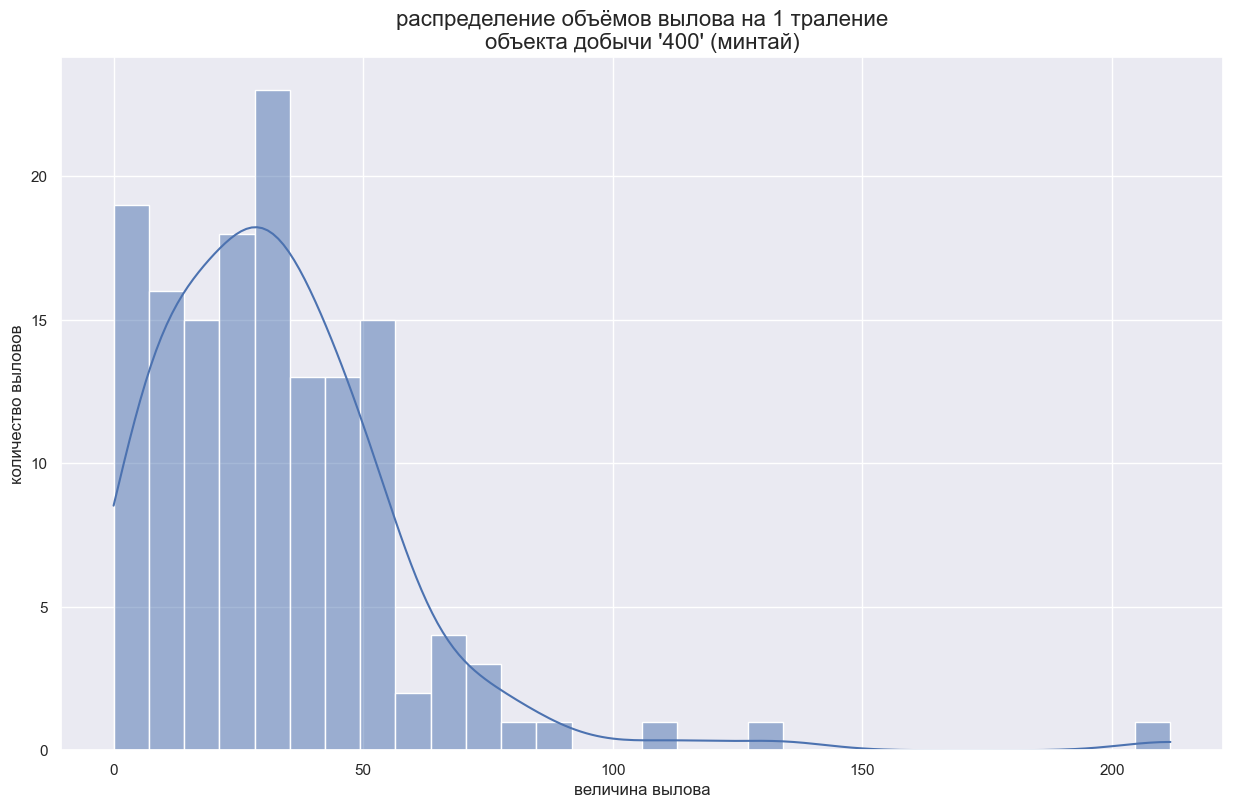

In [118]:
# визуализация распределения данных
rcParams["figure.figsize"] = 15, 9
ax = sns.histplot(
    data=df_test[df_test["id_fish"] == 400]["catch_volume_fish_per_oper"],
    kde=True,
    bins=30,
)
ax.set_xlabel(
    "величина вылова",
    size=12,
)
ax.set_ylabel("количество выловов", size=12)
ax.set_title(
    "распределение объёмов вылова на 1 траление\nобъекта добычи '400' (минтай)",
    size=16,
)
plt.show()

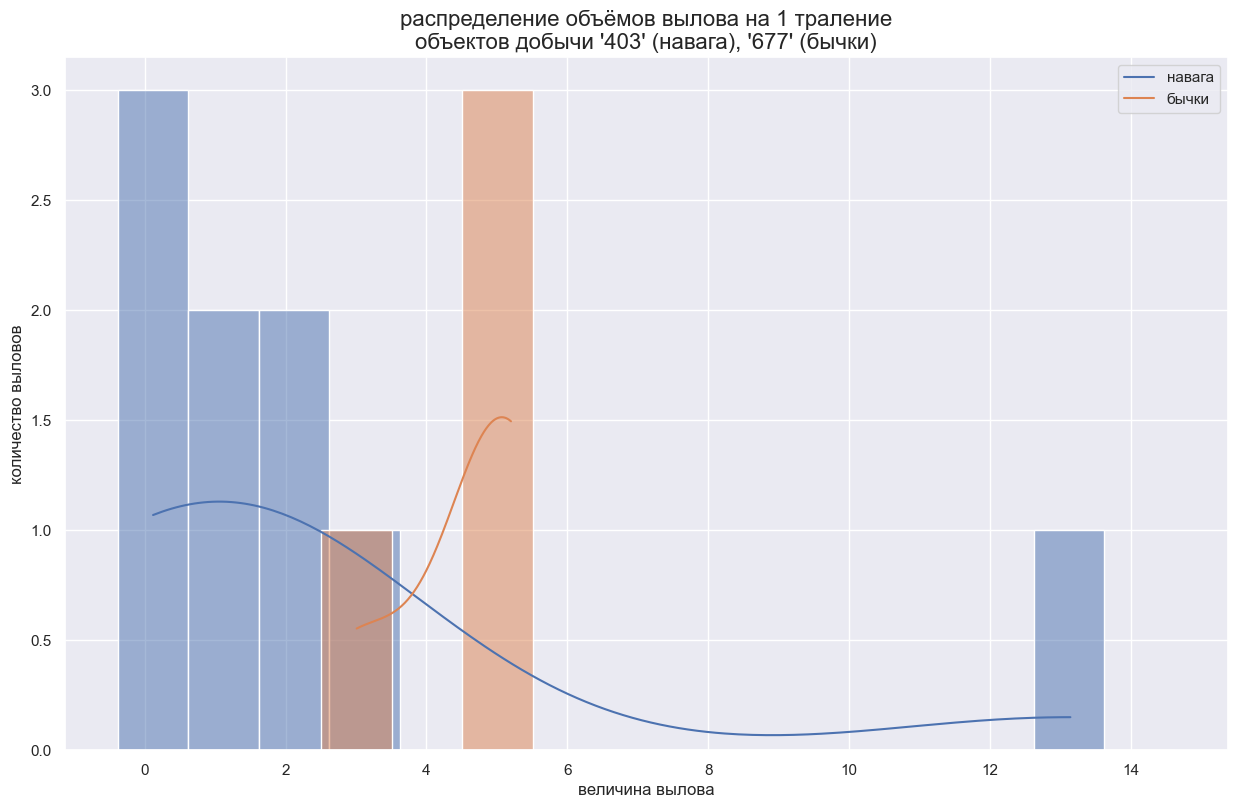

In [119]:
# визуализация распределения данных
rcParams["figure.figsize"] = 15, 9
for id_fish in [403, 677]:
    ax = sns.histplot(
        df_test[df_test["id_fish"] == id_fish]["catch_volume_fish_per_oper"],
        bins=10,
        kde=True,
        discrete=(True, False),
    )
ax.set_xlabel(
    "величина вылова",
    size=12,
)
ax.set_ylabel("количество выловов", size=12)
ax.set_title(
    "распределение объёмов вылова на 1 траление\nобъектов добычи '403' (навага), '677' (бычки)",
    size=16,
)
ax.legend(["навага", "бычки"])
plt.show()

### - оценка распределения объёмов полученных кластеров.

In [120]:
pd.DataFrame(
    df_result.groupby("cluster_full")["id_ves"]
    .count()
    .agg(["min", "max", "mean", "median"])
).rename({"id_ves": "value"}, axis=1)

,value
min,1.000000
max,26.000000
mean,1.714038
median,1.000000


### - кластеры объединяют от 1 до 26 записей, среднее значение записей в 1 кластере 1.7, медианное значение 1.

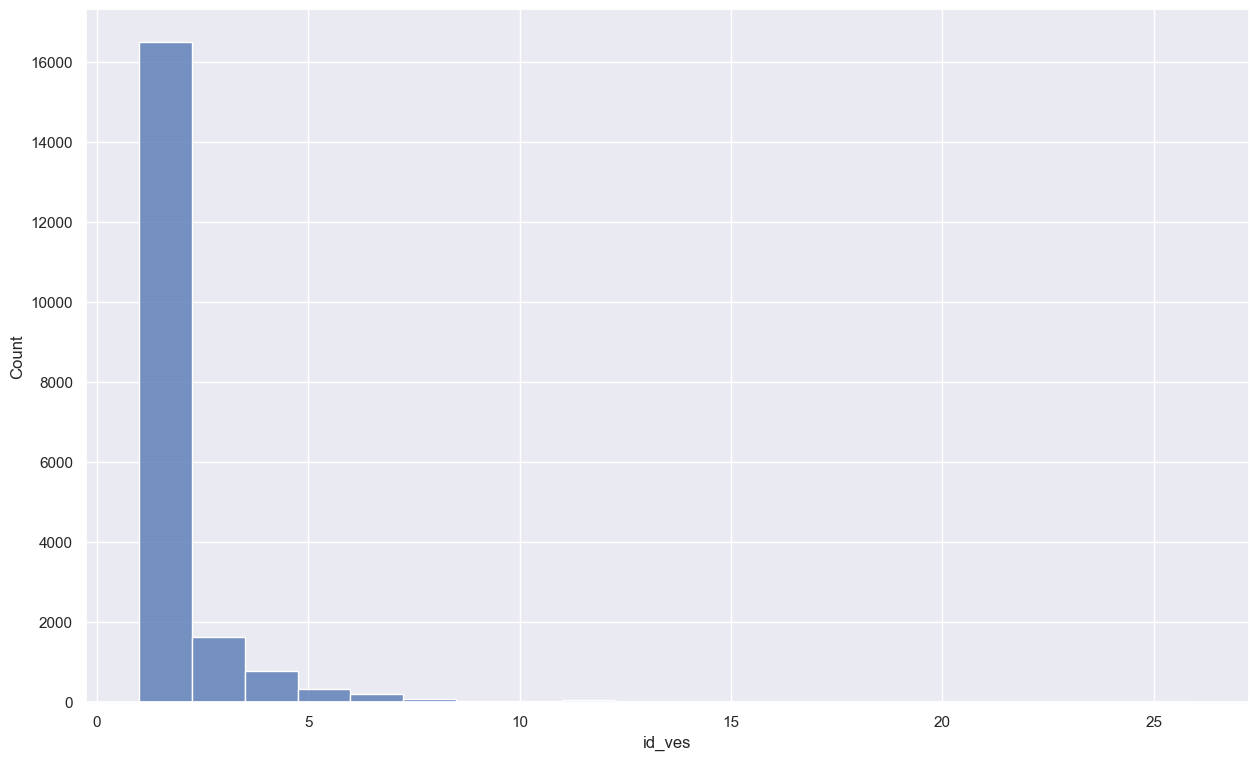

In [121]:
# визуализация распределения объёмов кластеров
rcParams["figure.figsize"] = 15, 9
sns.histplot(
    data=df_result.groupby("cluster_full")["id_ves"].count(), kde=False, bins=20
)
plt.show()

## **4.2. Оценочное исследование кластера, объединяющего максмальное число записей**

In [122]:
# код кластера
df_result.groupby("cluster_full")["id_ves"].count().sort_values(ascending=False).head(1)

cluster_full
2020-04-18_1152316_1    26
Name: id_ves, dtype: int64

In [123]:
# фильрация данных
df_test = df_result[df_result["cluster_full"] == "2020-04-18_1152316_1"].reset_index(
    drop=True
)

In [124]:
df_test.head()

,id_ves,cluster_full,local_class_ves,date,latitude,longitude,oper_quantity,catch_depth,id_region,id_fish,catch_volume_fish,catch_volume_fish_per_oper,id_regime,cluster
0,13543,2020-04-18_1152316_1,1152316,2020-04-18,51.50,156.48,1,60.0,272,451,9.50,9.50,12,1
1,13543,2020-04-18_1152316_1,1152316,2020-04-18,51.50,156.48,1,60.0,272,400,1.50,1.50,12,1
2,13543,2020-04-18_1152316_1,1152316,2020-04-18,51.50,156.48,1,60.0,272,403,0.10,0.10,12,1
3,13543,2020-04-18_1152316_1,1152316,2020-04-18,51.50,156.48,1,60.0,272,292,0.16,0.16,97,1
4,13544,2020-04-18_1152316_1,1152316,2020-04-18,51.51,156.41,1,70.0,272,451,8.50,8.50,12,1


In [127]:
# значение основных статистик
df_test.describe()

,id_ves,local_class_ves,latitude,longitude,oper_quantity,catch_depth,id_region,id_fish,catch_volume_fish,catch_volume_fish_per_oper,id_regime,cluster
count,26.000000,26.0,26.000000,26.000000,26.000000,26.000000,26.0,26.000000,26.000000,26.000000,26.000000,26.0
mean,15029.230769,1152316.0,51.487692,156.460000,1.384615,78.923077,272.0,383.038462,4.944615,3.443077,28.346154,1.0
std,1827.279558,0.0,0.012102,0.023664,0.496139,40.692921,0.0,65.325328,6.848363,4.311675,34.163070,0.0
min,13543.000000,1152316.0,51.480000,156.410000,1.000000,46.000000,272.0,292.000000,0.100000,0.100000,12.000000,1.0
25%,13544.000000,1152316.0,51.480000,156.460000,1.000000,53.000000,272.0,292.000000,0.200000,0.160000,12.000000,1.0
50%,13712.000000,1152316.0,51.480000,156.460000,1.000000,60.000000,272.0,401.500000,1.000000,0.600000,12.000000,1.0
75%,17070.000000,1152316.0,51.500000,156.480000,2.000000,70.000000,272.0,451.000000,8.325000,7.725000,12.000000,1.0
max,17607.000000,1152316.0,51.510000,156.480000,2.000000,168.000000,272.0,451.000000,21.000000,12.700000,97.000000,1.0


In [128]:
df_test.info()  # контроль качества данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id_ves                      26 non-null     int64  
 1   cluster_full                26 non-null     object 
 2   local_class_ves             26 non-null     int64  
 3   date                        26 non-null     object 
 4   latitude                    26 non-null     float64
 5   longitude                   26 non-null     float64
 6   oper_quantity               26 non-null     int64  
 7   catch_depth                 26 non-null     float64
 8   id_region                   26 non-null     int64  
 9   id_fish                     26 non-null     int64  
 10  catch_volume_fish           26 non-null     float64
 11  catch_volume_fish_per_oper  26 non-null     float64
 12  id_regime                   26 non-null     int64  
 13  cluster                     26 non-nu

In [129]:
# уникальные коды судов, принадлежащих кластеру
df_test["id_ves"].unique()

array([13543, 13544, 13678, 13712, 13713, 17070, 17071, 17607])

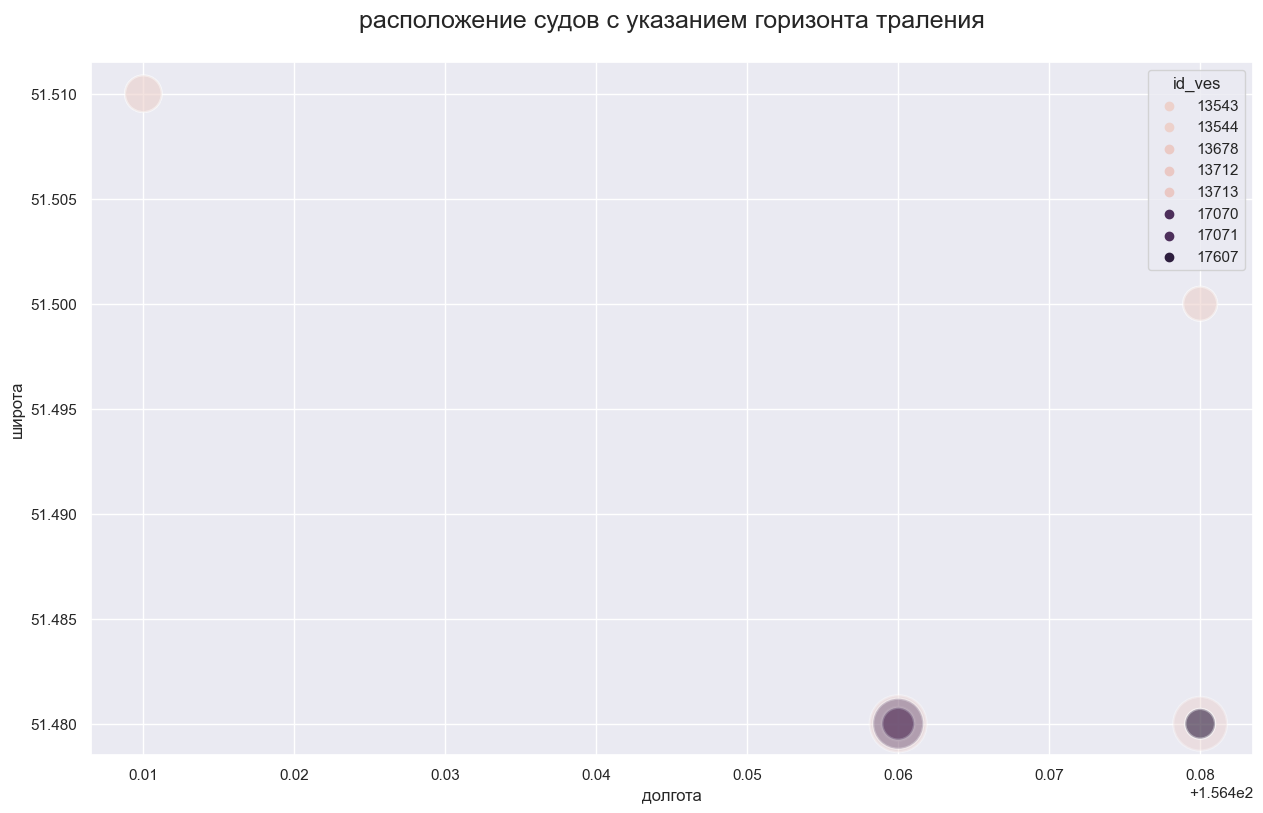

In [130]:
# визуализация данных о расположении судов
rcParams["figure.figsize"] = 15, 9
fig, ax = plt.subplots()
sns.scatterplot(
    ax=ax,
    data=df_test,
    x="longitude",
    y="latitude",
    s=df_test["catch_depth"] * 10,
    hue="id_ves",
    legend="full",
    alpha=0.2,
)
ax.set_xlabel(
    "долгота",
    size=12,
)
ax.set_ylabel("широта", size=12)
ax.set_title(
    "расположение судов с указанием горизонта траления\n",
    size=18,
)
plt.show()

### - визуализация не информативна: капитаны судов при представлении оперативной промысловой отчётности указали близкие значения средних позиций.   




### 4.2.1. Формирование сводных таблиц, сопоставляющих судам вылов на одно промысловое усилие в разрезе объектов добычи и исследование взаимосвязи показателей улова.

In [131]:
# сводная таблица, показывающая вылов на одно судно за одно промысловое усилие в разрезе объектов добычи
df_pvt = (
    df_test.pivot_table(
        index="id_ves",
        columns="id_fish",
        values="catch_volume_fish_per_oper",
        aggfunc="sum",
    )
    .reset_index()
    .fillna(0)
)
df_pvt

id_fish,id_ves,292,400,403,451
0,13543,0.16,1.5,0.1,9.50
1,13544,0.16,5.5,0.1,8.50
2,13678,0.24,0.6,0.2,12.70
3,13712,8.50,0.0,0.0,0.60
4,13713,10.25,0.0,0.0,0.40
5,17070,0.12,3.2,0.1,7.80
6,17071,10.50,0.0,0.0,0.25
7,17607,0.14,0.8,0.1,7.50


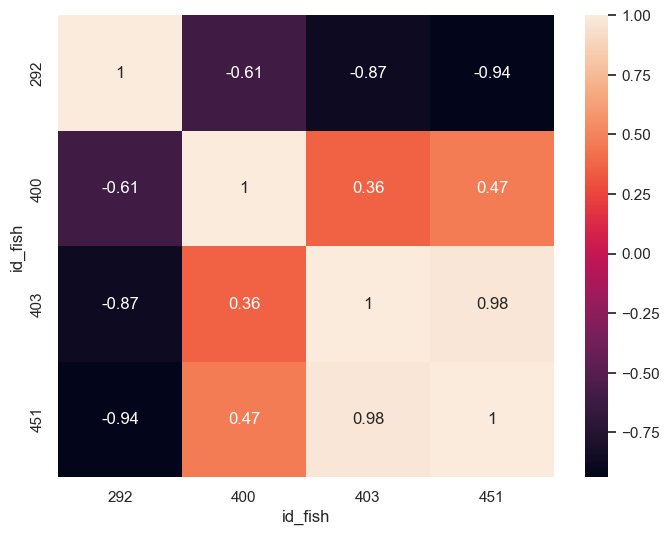

In [132]:
# корреляционная матрица взаимосвязи показателей уловов на 1 промысловое усилие
cols = [
    292,
    400,
    403,
    451,
]
sns.set(rc={"figure.figsize": (8, 6)})
hm = sns.heatmap(df_pvt[cols].corr(), cbar=True, annot=True)

### - прослеживается выраженная линейная зависимость между наборами объёмных показателей уловов. Наименее значительная корреляция отмечается между уловами объекта "400" (минтай) и обьектами "403" (навага), "451" (камбалы дальневосточные).

### 4.2.2. Исследование объективных причин выявленной зависимости.   
### а) сравнение средней глубины (горизонта) траления:

In [133]:
# средняя глубина траления
pd.DataFrame(
    df_test[
        (df_test["id_fish"] == 400)
        | (df_test["id_fish"] == 403)
        | (df_test["id_fish"] == 451)
    ]
    .groupby("id_fish")["catch_depth"]
    .mean()
)

,catch_depth
id_fish,
400,57.800
403,57.800
451,92.125


### - видно, что средняя глубина траления для добычи митная и наваги полностью совпадает, тем не менее корреляция между объёмными показателями вылова этих объектов наиболее низкая.
### - добавлена инфоормация о режиме рыболовства.

In [134]:
# код режима рыболовства
pd.DataFrame(
    df_test[
        (df_test["id_fish"] == 400)
        | (df_test["id_fish"] == 403)
        | (df_test["id_fish"] == 451)
    ]
    .groupby(["id_fish", "id_regime"])["catch_depth"]
    .mean()
)

,,catch_depth
id_fish,id_regime,
400,12,57.800
403,12,57.800
451,12,92.125


### - во всех случаях осуществлялось прибрежное рыболовство (код режима "12"). Таким образом, можно сделать вывод, что предсталенная информация об уловах не соответствует действительности и объёмные показатели вылова минтая (данные о вылове наваги и камбал хорошо коррелируют меджду собой) намеренно искажены. Несколько выходя за рамки данного исследования, скажем, что это, вероятнее всего, так и есть: предприятию в этот преиод не выгодно отражать высокий вылов минтая, поскольку специализированный промысел этого объекта запрещён.   


### б) исследование взаимосвязи между уловами различных судов.

In [135]:
# сводная таблица, показывающая вылов на одно судно за одно промысловое усилие в разрезе объектов добычи (те же данные, другая структура таблицы)
df_pvt_ves = (
    df_test.pivot_table(
        index="id_fish",
        columns="id_ves",
        values="catch_volume_fish_per_oper",
        aggfunc="sum",
    )
    .reset_index()
    .fillna(0)
)
df_pvt_ves

id_ves,id_fish,13543,13544,13678,13712,13713,17070,17071,17607
0,292,0.16,0.16,0.24,8.5,10.25,0.12,10.50,0.14
1,400,1.50,5.50,0.60,0.0,0.00,3.20,0.00,0.80
2,403,0.10,0.10,0.20,0.0,0.00,0.10,0.00,0.10
3,451,9.50,8.50,12.70,0.6,0.40,7.80,0.25,7.50


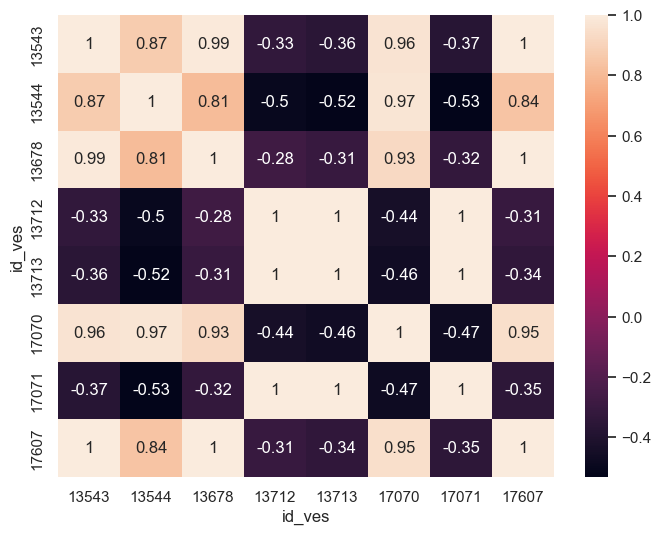

In [136]:
# корреляционная матрица взаимосвязи уловов в разрезе судов
cols = [
    13543,
    13544,
    13678,
    13712,
    13713,
    17070,
    17071,
    17607,
]
sns.set(rc={"figure.figsize": (8, 6)})
hm = sns.heatmap(df_pvt_ves[cols].corr(), cbar=True, annot=True)

### - наибольший интерес в данном случае представляет отрицательная корреляция, которой, исходя из логики процесса, наблюдаться не должно: и, тем не менее, капитаны судов "13712", "13713", "17071" действуют "наоборот" и добывают меньше там, где другие больше. Это повод изучить деятельность указаных судов подробнее.

## Таким образом, по результатам статистического анализа видовых и объёмных показателей вылова можно сделать вывод, что **полученные данные могут быть эффективно использованы для оценки деятельности с использованием отдельных судов, прогнозировании объемных и видовых показателей уловов в разрезе добывающего судна**.
***

# **5. Прогнозирование видовых и объёмных показателей вылова**

## **5.1. Прогнозирование видовых и объёмных показалелей уловов** основано на следующих принципах (*алгоритм 1*):
### - исходя из применённой методики классификации и кластеризации судов, суда в пределах одного кластера должны иметь однородные видовые показатели уловов, при этом различия в объёмных показателях должны быть незначительными;
### - рыбохозяйственные предприятия не заинтересованы в завышении документируемых объёмов добычи по отношению к фактическим;
### - в том случае, когда в оперативной промысловой отчётности каждого судна в кластере отсутствует вывов любого объекта, вылов которого отражён хотя бы одним судном из этого кластера, этот вылов судам добавляется. Для определения прогнозируемого объёма используется среднее значение объёма вылова теми судами, в отчётности которых такой вылов указан (т.е. по кластеру).
> ### Использование среднего значения не может привести к ошибке, поскольку набор объектов добычи формируется на основании фактических данных, таким образом для каждого объекта присутствует как минимум одно значение;
### - в том случае, если вылов всех присутствующих в рамках кластера объектов в отчётности судна отражён, *объёмные показатели этого вывова не изменяются, сколь низкими бы они ни были*.

In [137]:
# алгоритм 1

# формирование списка кластеров
cluster_list = list(set(df_result["cluster_full"]))

# пустой набор данных для хранения результатов прогноза вылова
df_catch_result = pd.DataFrame()


# для каждого кластера из списка

for cluster in cluster_list:
    # фильтрация данных
    df_test = df_result[df_result["cluster_full"] == cluster].reset_index(drop=True)
    # группировка данных для посторения сводной таблицы
    df_fish = pd.DataFrame(
        df_test.groupby(["id_ves", "id_region", "id_fish"])[
            "catch_volume_fish_per_oper"
        ].sum()
    ).reset_index()

    # в рамках кластера для каждого района добычи формируется прогноз видовых и объёмных показателей уловов

    # формирование списка районов добычи
    region_list = sorted(list(set(df_fish["id_region"])))
    # пустой набор данных для хранения результатов прогноза вылова по кластеру
    df_cluster_catch = pd.DataFrame()
    for region in region_list:
        # фильтрация
        df_fish_region = df_fish[df_fish["id_region"] == region]
        # формирование сводной таблицы
        df_fish_pivot = df_fish_region.pivot_table(
            index="id_ves",
            columns="id_fish",
            values="catch_volume_fish_per_oper",
            aggfunc="sum",
        ).reset_index()
        # заполнение пропусков в каждом столбце (вид объекта добычи) средним значением вылова по этому объекту, т.е. по столбцу
        for col in df_fish_pivot.columns:
            df_fish_pivot[col] = df_fish_pivot[col].fillna(df_fish_pivot[col].mean())
        # определение количества промысловых операций для каждого судна, объекта добычи и района
        df_oper_quantity = df_test[df_test["id_region"] == region]
        df_oper_quantity = df_oper_quantity.pivot_table(
            index="id_ves", columns="id_fish", values="oper_quantity"
        )
        df_oper_quantity = (
            pd.DataFrame(df_oper_quantity.max(axis=1))
            .reset_index()
            .rename({0: "oper_quantity"}, axis=1)
        )
        # соединение данных о прогнозируемом вылове с данными о количестве промысловых операций
        df_fish_pivot = pd.merge(
            df_fish_pivot, df_oper_quantity, left_on="id_ves", right_on="id_ves"
        )
        # увеличение прогнозируемого вылова в число раз, равное количеству промысловых операций
        df_fish_pivot = df_fish_pivot.apply(
            lambda row: row * row["oper_quantity"], axis=1
        )
        # удаление неактуальных данных
        df_fish_pivot = df_fish_pivot.drop(["id_ves", "oper_quantity"], axis=1)
        # получение суммарного прогнозируемого вылова в разрезе объектов добычи по району
        df_catch_region = pd.DataFrame(df_fish_pivot.T.sum(axis=1))
        # получение прогнозируемого вылова с учётом количества промысловых операций для района в рамках кластера
        df_catch_region.rename({0: region}, axis=1, inplace=True)
        # соединение полученного набора данных с прогнозом по кластеру
        if df_cluster_catch.empty:
            df_cluster_catch = df_catch_region.copy()
        else:
            df_cluster_catch = pd.merge(
                df_cluster_catch,
                df_catch_region,
                left_index=True,
                right_index=True,
                how="outer",
            )
        df_cluster_catch = df_cluster_catch.fillna(0).round(1)
        # преобразование структуры таблицы
        df_cluster_result = (
            pd.DataFrame(df_cluster_catch.unstack())
            .reset_index()
            .rename({"level_0": "id_region", "level_1": "id_fish", 0: "catch"}, axis=1)
        )
    df_catch_result = pd.concat([df_catch_result, df_cluster_result]).reset_index(
        drop=True
    )

## Формирование прогноза завершено. Сохранение данных.

In [138]:
# сохранение результатов прогноза на жёсткий диск
df_catch_result.to_csv(
    "/home/sk27/learning/graduation_project/data/catch_predict_full.csv", sep=";"
)

In [139]:
# вспомогательная ячейка: загрузка данных, чтобы не выполнять весь notebook
df_catch_result = pd.read_csv(
    "/home/sk27/learning/graduation_project/data/catch_predict_full.csv",
    sep=";",
    index_col=[0],
)

In [140]:
# прогноз видовых и объёмных показателей вылова
df_catch_result

,id_region,id_fish,catch
0,273,112,0.0
1,273,113,0.0
2,273,144,0.5
3,274,112,0.2
4,274,113,1.9
...,...,...,...
30414,273,400,174.4
30415,274,400,34.1
30416,273,400,28.0
30417,274,403,17.0


In [141]:
# формирование сводной таблицы по результатам прогноза видовых и объёмных показателей вылова
df_catch_predict = df_catch_result.pivot_table(
    index="id_fish", columns="id_region", values="catch", aggfunc="sum"
).fillna(0)

In [142]:
df_catch_predict.reset_index(inplace=True)

In [143]:
df_catch_predict.columns.name = ""

In [144]:
# сводные результаты прогноза
df_catch_predict

,id_fish,272,273,274,275
0,15,0.0,0.0,2.3,0.0
1,112,110.3,32.1,52.0,28.8
2,113,1263.5,3393.8,1262.0,676.0
3,114,36.0,2.7,0.0,30.6
4,144,583.3,1001.4,203.7,83.7
...,...,...,...,...,...
42,887,3.5,17.8,0.0,0.0
43,927,0.0,0.0,0.0,0.0
44,949,0.0,0.0,0.0,0.0
45,978,2.3,0.2,0.0,0.0


In [145]:
# добавление суммарного значения вылова в разрезе объекта добычи
df_catch_predict["total_predict"] = df_catch_predict[[272, 273, 274, 275]].sum(axis=1)

In [146]:
df_catch_predict

,id_fish,272,273,274,275,total_predict
0,15,0.0,0.0,2.3,0.0,2.3
1,112,110.3,32.1,52.0,28.8,223.2
2,113,1263.5,3393.8,1262.0,676.0,6595.3
3,114,36.0,2.7,0.0,30.6,69.3
4,144,583.3,1001.4,203.7,83.7,1872.1
...,...,...,...,...,...,...
42,887,3.5,17.8,0.0,0.0,21.3
43,927,0.0,0.0,0.0,0.0,0.0
44,949,0.0,0.0,0.0,0.0,0.0
45,978,2.3,0.2,0.0,0.0,2.5


## **5.1. Статистический анализ результатов прогноза**

In [147]:
# загрузка исходных данных о вылове
df_catch = pd.read_csv(
    "/home/sk27/learning/graduation_project/data/catch.csv", sep=";", encoding="cp1252"
)
df_catch = df_catch.replace(",", ".", regex=True).apply(pd.to_numeric, errors="ignore")
df_catch["date"] = df_catch["date"].astype("datetime64[ns]")
df_catch = df_catch.drop(["catch_volume_total", "permit", "id_own"], axis=1)
df_catch = df_catch[
    (df_catch["date"] > "2019-10-31") & (df_catch["date"] < "2020-11-01")
].reset_index(drop=True)

In [148]:
df_catch_okhsee = df_catch[df_catch.id_region.isin([272, 273, 274, 275])].reset_index(
    drop=True
)

# формирование сводной таблицы
df_catch_original = (
    df_catch_okhsee.pivot_table(
        index="id_fish", columns="id_region", values="catch_volume", aggfunc="sum"
    )
    .fillna(0)
    .round(1)
)

In [149]:
df_catch_original.reset_index(inplace=True)

In [150]:
df_catch_original.columns.name = ""

In [151]:
df_catch_original["total_original"] = df_catch_original[[272, 273, 274, 275]].sum(
    axis=1
)

### - сводные данные о вылове, отражённые в оперативной промысловой отчётности (исходные)/

In [152]:
df_catch_original

,id_fish,272,273,274,275,total_original
0,15,0.0,0.0,2.3,0.0,2.3
1,112,110.5,32.9,53.1,29.2,225.7
2,113,1263.0,3396.4,1262.1,669.5,6591.0
3,114,35.6,2.4,0.0,30.2,68.2
4,144,581.7,999.6,204.8,84.9,1871.0
...,...,...,...,...,...,...
44,888,0.0,0.0,0.0,2.2,2.2
45,927,0.0,5303.8,212.8,540.9,6057.5
46,949,0.0,0.2,0.0,0.0,0.2
47,978,2.4,0.0,0.1,0.1,2.6


### 5.1.1. Объединение данных прогноза с исходными данными и их сравнительное исследование

In [153]:
# соединение данных
df_catch_result = pd.merge(
    df_catch_original,
    df_catch_predict,
    left_on="id_fish",
    right_on="id_fish",
    how="outer",
).fillna(0)
df_catch_result = df_catch_result.rename(
    {
        "272_x": "272_o",
        "273_x": "273_o",
        "274_x": "274_o",
        "275_x": "275_o",
        "272_y": "272_p",
        "273_y": "273_p",
        "274_y": "274_p",
        "275_y": "275_p",
    },
    axis=1,
)

In [154]:
# ради наглядности добавлены данные о названиях объектов добычи
df_fish = pd.read_csv(
    "/home/sk27/learning/graduation_project/data/fish.csv", sep=";", encoding="cp1251"
)
df_catch_result = df_catch_result.merge(df_fish, on="id_fish", how="left")
df_catch_result.insert(1, "fish_", df_catch_result["fish"])
df_catch_result.drop("fish", axis=1, inplace=True)
df_catch_result.rename(columns={"fish_": "fish"}, inplace=True)

In [155]:
df_catch_result

,id_fish,fish,272_o,273_o,274_o,275_o,total_original,272_p,273_p,274_p,275_p,total_predict
0,15,палтусы,0.0,0.0,2.3,0.0,2.3,0.0,0.0,2.3,0.0,2.3
1,112,палтус белокорый,110.5,32.9,53.1,29.2,225.7,110.3,32.1,52.0,28.8,223.2
2,113,палтус черный (синекорый),1263.0,3396.4,1262.1,669.5,6591.0,1263.5,3393.8,1262.0,676.0,6595.3
3,114,палтус стрелозубый,35.6,2.4,0.0,30.2,68.2,36.0,2.7,0.0,30.6,69.3
4,144,скаты,581.7,999.6,204.8,84.9,1871.0,583.3,1001.4,203.7,83.7,1872.1
...,...,...,...,...,...,...,...,...,...,...,...,...
44,888,кальмар командорский,0.0,0.0,0.0,2.2,2.2,0.0,0.0,0.0,0.0,0.0
45,927,трубач,0.0,5303.8,212.8,540.9,6057.5,0.0,0.0,0.0,0.0,0.0
46,949,ламинарии,0.0,0.2,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0
47,978,ликоды,2.4,0.0,0.1,0.1,2.6,2.3,0.2,0.0,0.0,2.5


### - среди результатов прогноза присутствуют данные о добыче крабов и трубача. Крабы и трубач в промышленных масштабах добываются ловушками, деятельность с использованием которых была исключена из предмета данной работы. Вместе с тем, прилов крабов и трубача наблюдается и при траловом лове, в результате чего в итоговой таблице оказались, с одной стороны, полные данные о добыче крабов и трубача из оперативной промысловой отчётности, а, с другой стороны, результаты прогноза минимальной добычи, построенные на основании прилова крабов и трубача в ходе тралового лова. В результате данные существенно искажаются, из **прогноза данные по крабам и трубачу целесообразно исключить**.

In [156]:
# данные о вылове крабов
df_catch_result[df_catch_result["fish"].str.contains("краб")]

,id_fish,fish,272_o,273_o,274_o,275_o,total_original,272_p,273_p,274_p,275_p,total_predict
13,294,краб-стригун опилио,0.0,20817.9,163.4,2054.5,23035.8,0.0,7.8,0.0,0.4,8.2
32,839,краб волосатый четырехугольный,48.1,0.0,0.0,0.0,48.1,0.0,0.0,0.0,0.0,0.0
33,844,краб-стригун ангулятус,0.0,1152.9,0.0,2538.7,3691.6,0.0,0.0,0.0,0.0,0.0
34,847,краб синий,0.0,528.7,3451.5,153.5,4133.7,0.0,4.4,4.6,0.0,9.0
35,848,краб колючий,0.0,0.3,0.0,168.7,169.0,0.0,0.3,0.0,0.0,0.3
36,849,краб равношипый,0.0,1622.8,361.7,0.0,1984.5,0.0,1.4,0.0,0.0,1.4
37,853,краб-стригун бэрди,8.2,0.0,0.0,0.0,8.2,7.5,0.0,0.0,0.0,7.5
48,984,краб камчатский,2641.2,647.3,12005.1,0.0,15293.6,2.8,3.4,40.4,0.0,46.6


In [157]:
# удаление данных о прогнозе вылова крабов
crab_list = [df_catch_result[df_catch_result["fish"].str.contains("краб")].index]
df_catch_result = df_catch_result.drop(crab_list[0], axis=0).reset_index(drop=True)

In [158]:
# данные о вылове трубача
df_catch_result[df_catch_result["fish"].str.contains("труба")]

,id_fish,fish,272_o,273_o,274_o,275_o,total_original,272_p,273_p,274_p,275_p,total_predict
38,927,трубач,0.0,5303.8,212.8,540.9,6057.5,0.0,0.0,0.0,0.0,0.0


In [159]:
# удаление данных о вылове трубача
clam_list = [df_catch_result[df_catch_result["fish"].str.contains("труба")].index]
df_catch_result = df_catch_result.drop(clam_list[0], axis=0).reset_index(drop=True)

In [160]:
# окончательные данные прогноза
df_catch_result

,id_fish,fish,272_o,273_o,274_o,275_o,total_original,272_p,273_p,274_p,275_p,total_predict
0,15,палтусы,0.0,0.0,2.3,0.0,2.3,0.0,0.0,2.3,0.0,2.3
1,112,палтус белокорый,110.5,32.9,53.1,29.2,225.7,110.3,32.1,52.0,28.8,223.2
2,113,палтус черный (синекорый),1263.0,3396.4,1262.1,669.5,6591.0,1263.5,3393.8,1262.0,676.0,6595.3
3,114,палтус стрелозубый,35.6,2.4,0.0,30.2,68.2,36.0,2.7,0.0,30.6,69.3
4,144,скаты,581.7,999.6,204.8,84.9,1871.0,583.3,1001.4,203.7,83.7,1872.1
...,...,...,...,...,...,...,...,...,...,...,...,...
35,880,шипощек,0.2,14.8,0.7,123.7,139.4,0.1,6.2,0.5,123.1,129.9
36,887,кальмар тихоокеанский,3.5,17.8,0.0,0.0,21.3,3.5,17.8,0.0,0.0,21.3
37,888,кальмар командорский,0.0,0.0,0.0,2.2,2.2,0.0,0.0,0.0,0.0,0.0
38,949,ламинарии,0.0,0.2,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0


### - результат сопоставления общего объёмного показателя уловов:

In [161]:
total_balance = (
    df_catch_result["total_predict"].sum() - df_catch_result["total_original"].sum()
).round(2)
print(
    f"Превышение общей прогнозируемой массы улова над отражённой в отчётности составляет {total_balance} тонн."
)

Превышение общей прогнозируемой массы улова над отражённой в отчётности составляет 523.4 тонн.


### - оценка линейной корреляции Пирсона между оригинальными данным и результатами прогноза:

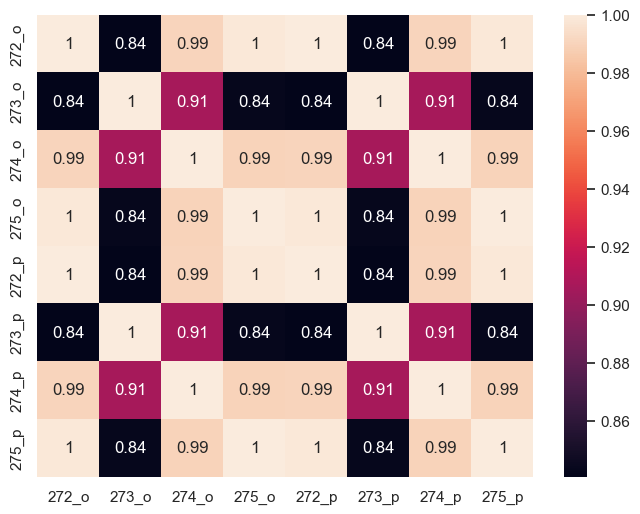

In [162]:
# линейная взаимосвязь между исходными и данными и прогнозом весьма высока
cols = [
    "272_o",
    "273_o",
    "274_o",
    "275_o",
    "272_p",
    "273_p",
    "274_p",
    "275_p",
]
sns.set(rc={"figure.figsize": (8, 6)})
hm = sns.heatmap(df_catch_result[cols].corr(), cbar=True, annot=True)

### Наличие значительной взаимосвязи между выборками указывает на то, что прогноз не имеет значимого "перекоса" в объёмных показателях вылова по сравнению с иходными данными.

In [163]:
# добавление сведений о расхождениях исходных данных и результатов прогноза
df_catch_result["balance"] = (
    df_catch_result["total_predict"] - df_catch_result["total_original"]
)
df_catch_result

,id_fish,fish,272_o,273_o,274_o,275_o,total_original,272_p,273_p,274_p,275_p,total_predict,balance
0,15,палтусы,0.0,0.0,2.3,0.0,2.3,0.0,0.0,2.3,0.0,2.3,0.0
1,112,палтус белокорый,110.5,32.9,53.1,29.2,225.7,110.3,32.1,52.0,28.8,223.2,-2.5
2,113,палтус черный (синекорый),1263.0,3396.4,1262.1,669.5,6591.0,1263.5,3393.8,1262.0,676.0,6595.3,4.3
3,114,палтус стрелозубый,35.6,2.4,0.0,30.2,68.2,36.0,2.7,0.0,30.6,69.3,1.1
4,144,скаты,581.7,999.6,204.8,84.9,1871.0,583.3,1001.4,203.7,83.7,1872.1,1.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
35,880,шипощек,0.2,14.8,0.7,123.7,139.4,0.1,6.2,0.5,123.1,129.9,-9.5
36,887,кальмар тихоокеанский,3.5,17.8,0.0,0.0,21.3,3.5,17.8,0.0,0.0,21.3,0.0
37,888,кальмар командорский,0.0,0.0,0.0,2.2,2.2,0.0,0.0,0.0,0.0,0.0,-2.2
38,949,ламинарии,0.0,0.2,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,-0.2


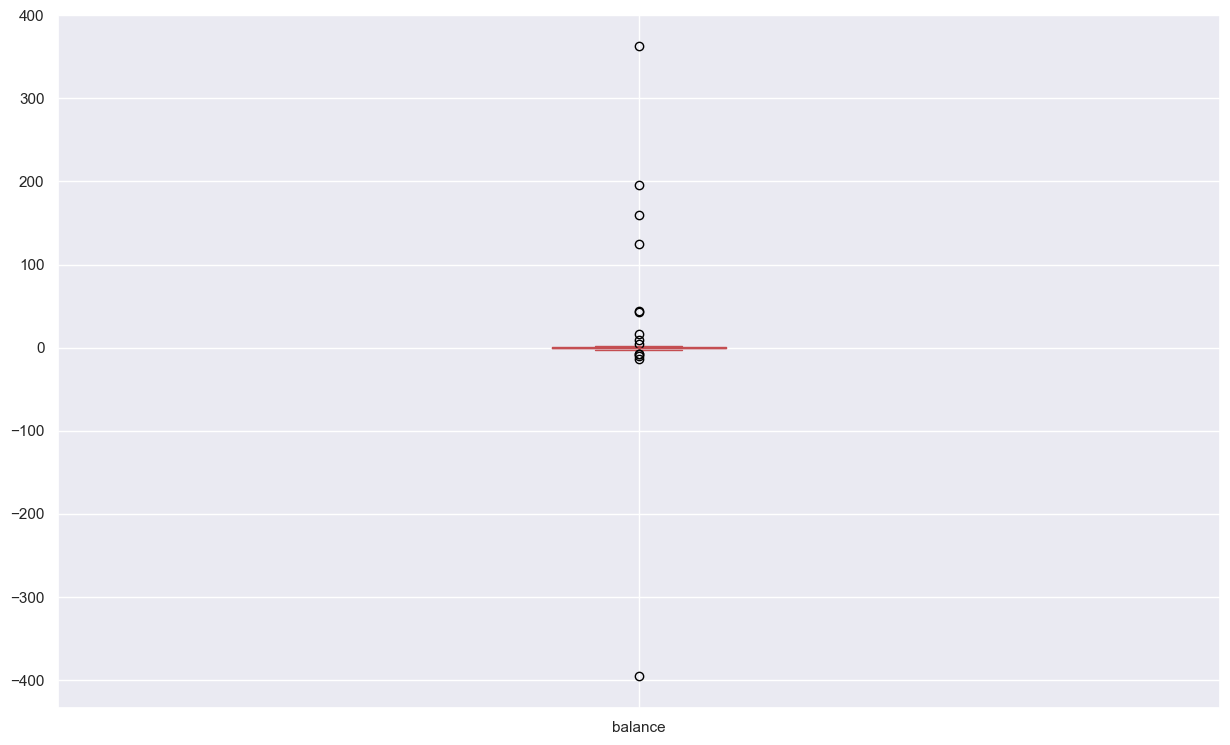

In [164]:
# визуализация разброса значений баланса
rcParams["figure.figsize"] = 15, 9
pd.DataFrame(df_catch_result["balance"]).boxplot(color="r")
plt.show()

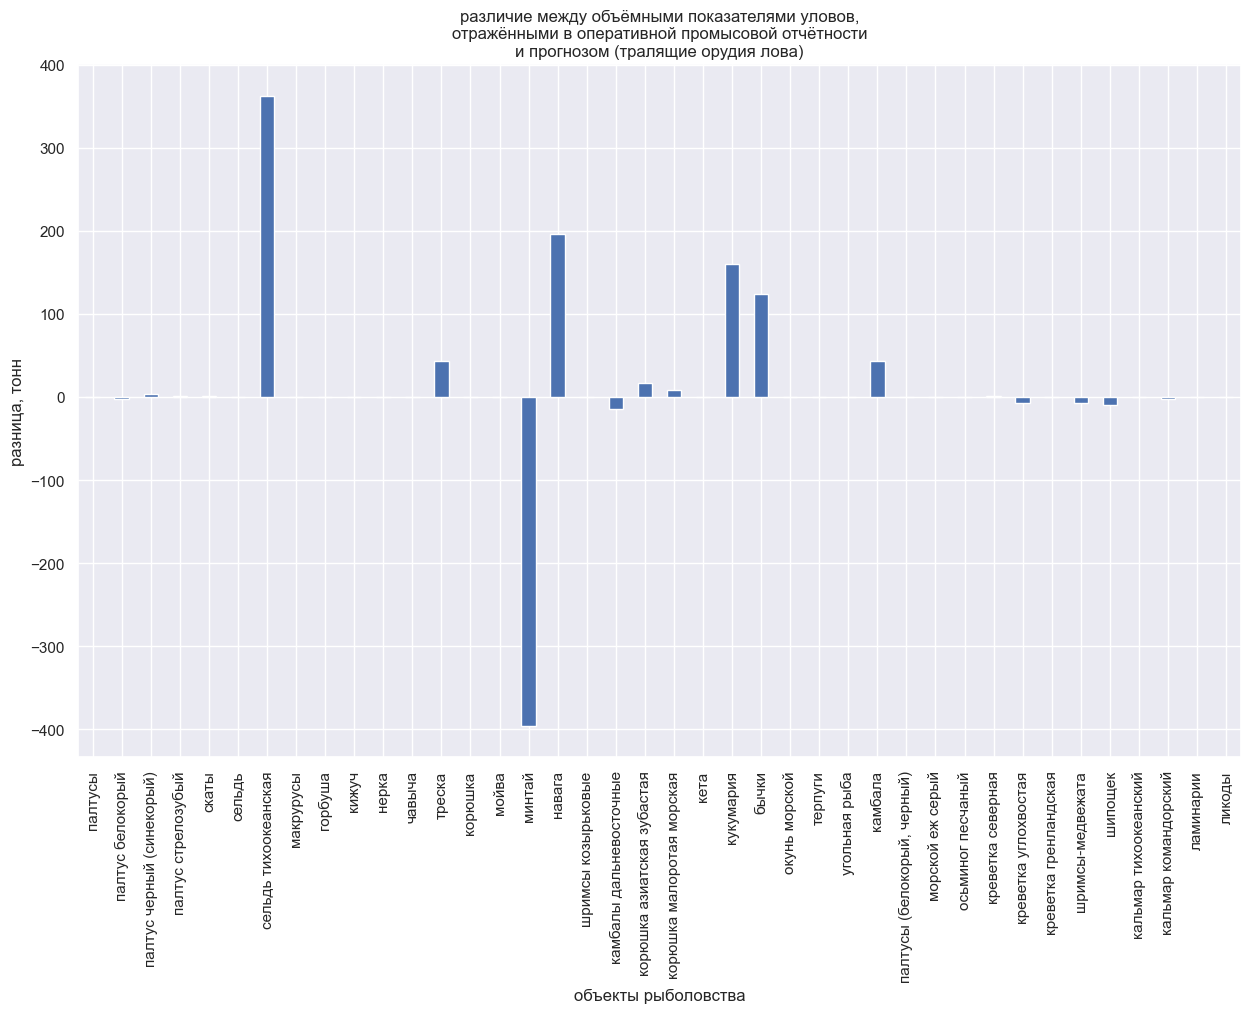

In [165]:
# различие между оригинальными данными и результатами прогноза
rcParams["figure.figsize"] = 15, 9
df_catch_result[["fish", "balance"]].plot(
    x="fish",
    kind="bar",
    title="различие между объёмными показателями уловов,\nотражёнными в оперативной промысовой отчётности\nи прогнозом (тралящие орудия лова)",
    xlabel="объекты рыболовства",
    ylabel="разница, тонн",
    stacked=True,
    legend=False,
)
plt.show()

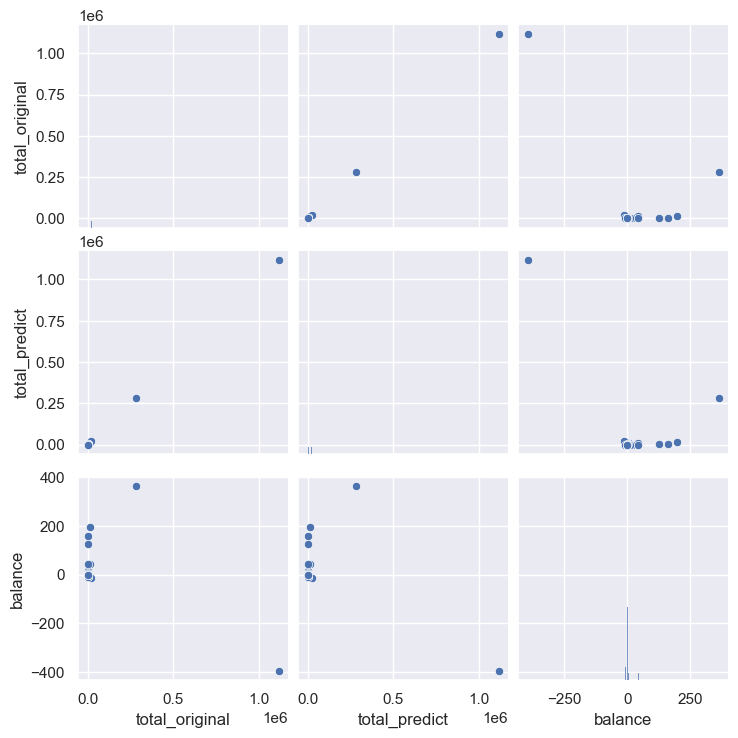

In [166]:
# взаимосвязь между основными показателями (которая, строго говоря, мало что характеризует)
rcParams["figure.figsize"] = 15, 9
sns.pairplot(df_catch_result[["total_original", "total_predict", "balance"]])
plt.show()

## - исследование на предмет пристутствия статистически значимых отличий между набором данных о результатах рыболовства, отражённых в оперативной промысловой отчётности и прогнозом, полученным с использованием выбранной методики.

### Проверка сведений о суммарном вылове на нормальность распределения. Поскольку данных немного, принято значение уровня статистической значимости равным **0.1**
### При определении уровня статистической значимости оценочно использованы данные [калькулятора размера выборки](https://www.questionstar.ru/statiy/calculator-razmera-viborki) для значений:
### - **допустимая погрешность - 10 %**;
### - уровень надёжности - 80 %;
### - размер генеральной совокупности - не известен;
### - доля признака в генеральной совокупности - не известна.
### При перечиленных уловиях вычисленный необходимый объём выборки - 41, что примерно соответствует имеющимся данным.

In [167]:
# проверка данных на нормальность распределения (критерий Шапиро-Уилка) для уровня значимости 0.1


def norm_test(data):
    """функция проверяет набор данных на нормальность распределения
    с использованием критерия Шапиро-Уилка"""
    stat, p = stats.shapiro(data)
    print("Statistics=%.3f, p-value=%.3f" % (stat, p))
    alpha = 0.1
    if p > alpha:
        print("Принять гипотезу о нормальности")
    else:
        print("Отклонить гипотезу о нормальности")

In [168]:
norm_test(df_catch_result["total_original"])

Statistics=0.209, p-value=0.000
Отклонить гипотезу о нормальности


In [169]:
norm_test(df_catch_result["total_predict"])

Statistics=0.209, p-value=0.000
Отклонить гипотезу о нормальности


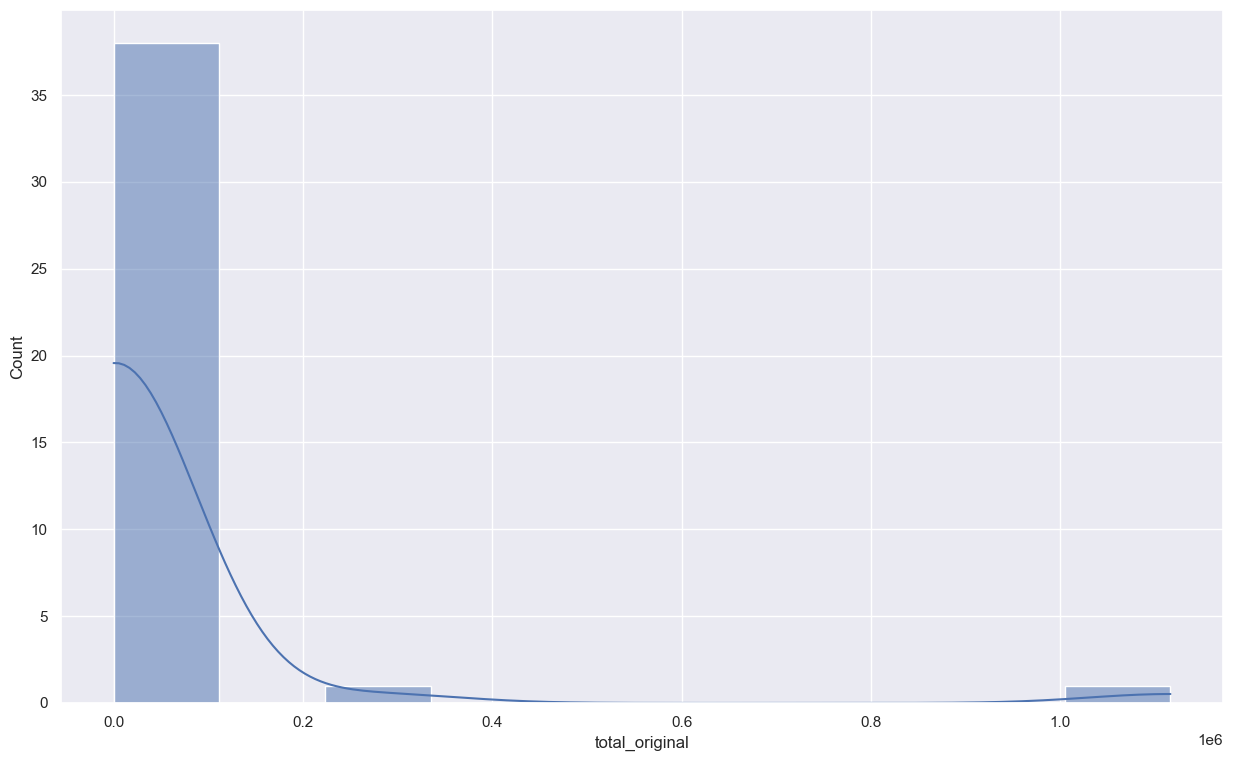

In [170]:
# визуализация распределения
rcParams["figure.figsize"] = 15, 9
sns.histplot(data=df_catch_result["total_original"], kde=True, bins=10)
plt.show()

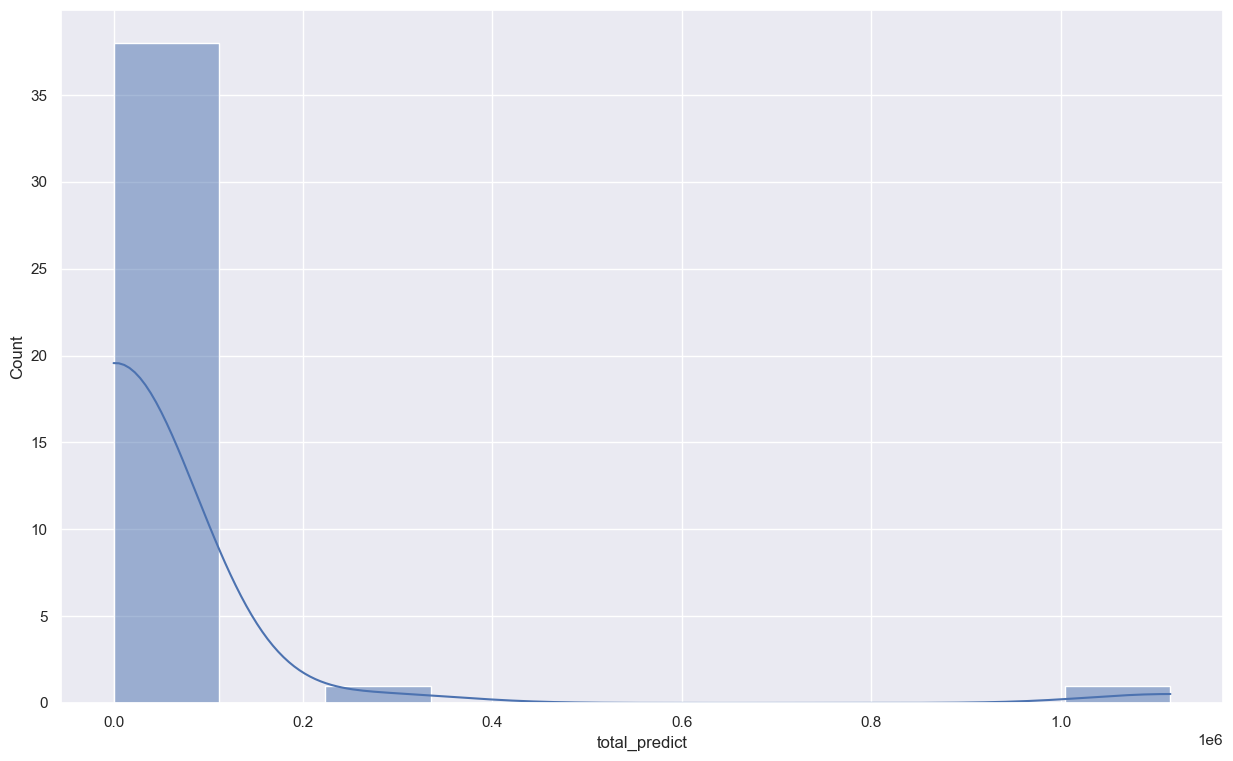

In [171]:
# визуализация построена на двух различных гистограммах, поскольку данные в выбранном масштабе совпадают практически полностью
rcParams["figure.figsize"] = 15, 9
sns.histplot(data=df_catch_result["total_predict"], kde=True, bins=10)
plt.show()

### - гистограммы также явно показывают, что распределение далеко от нормального и отделённо напоминает распределение Пуассона.   
### Для данных, распределение которых отличается от нормального, применим двусторонний (прогноз может быть как выше, так и ниже данных, отражённых в оперативной промысловой отчётности) непараметрический тест Манна-Уитни при уровне статистической значимости  alpha = 0.1 (*обоснование величины alpha приведено выше*):

In [172]:
stat, p = stats.mannwhitneyu(
    df_catch_result["total_predict"],
    df_catch_result["total_original"],
    alternative="two-sided",
)
print("statistic=%.3f, p-value=%.3f" % (stat, p))
alpha = 0.1
if p > alpha:
    print("Отличия статистически не значимы")
else:
    print("Отличия статистически значимы")

statistic=787.000, p-value=0.904
Отличия статистически не значимы


### Вероятность получить такие или ещё более экстремальные отклонения между оригинальными данным и результатами прогноза при предположении об отсутствии между ними значимых различий, составляет 0.9, что значительно выше выбранного уровня значимости.
## Необходимо приять нулевую гипотезу об **отсутствии статистически значимых различий между данными промысловой отчётности и результатами прогноза**.

***
## **5.2. Альтернативные методы прогнозирования величины улова и статистическое исследование результататов их применения**
## В исходный алгоритм внесены изменения метода прогнозирования объёмных показателей уловов:
### - **"мягкий" (soft) вариант**: при отсутствии у судна в пределах кластера вылова объекта, присутствующего у хотя бы одного судна в этом клаcтере, такому судну присваивается вылов этого объекта в количестве, равном не среднему, а **макимальному значению объёма вылова в кластере**;
### - **"жёсткий" (hard) вариант**: макимальное значение вылова сохраняется, всем прочим судам в кластере, независимо от наличия вылова, присваивается вылов, равный **макимальному значению объёма вылова в кластере** (код предусматривает возможность использования понижающего коэффициента).

In [173]:
# алгоритм 2 ("soft")

# формирование списка кластеров
cluster_list = list(set(df_result["cluster_full"]))

# пустой набор данных для хранения результатов прогноза вылова
df_catch_result_soft = pd.DataFrame()


# для каждого кластера из списка

for cluster in cluster_list:
    # фильтрация данных
    df_test = df_result[df_result["cluster_full"] == cluster].reset_index(drop=True)
    # группировка данных для посторения сводной таблицы
    df_fish = pd.DataFrame(
        df_test.groupby(["id_ves", "id_region", "id_fish"])[
            "catch_volume_fish_per_oper"
        ].sum()
    ).reset_index()

    # в рамках кластера для каждого района добычи формируется прогноз видовых и объёмных показателей уловов

    # формирование списка районов добычи
    region_list = sorted(list(set(df_fish["id_region"])))
    # пустой набор данных для хранения результатов прогноза вылова по кластеру
    df_cluster_catch_soft = pd.DataFrame()
    for region in region_list:
        # фильтрация
        df_fish_region = df_fish[df_fish["id_region"] == region]
        # формирование сводной таблицы
        df_fish_pivot = df_fish_region.pivot_table(
            index="id_ves",
            columns="id_fish",
            values="catch_volume_fish_per_oper",
            aggfunc="sum",
        ).reset_index()

        # заполнение пропусков в каждом столбце (вид объекта добычи) максимальным значением вылова по этому объекту, т.е. по столбцу
        for col in df_fish_pivot.columns:
            df_fish_pivot[col] = df_fish_pivot[col].fillna(df_fish_pivot[col].max())

        # определение количества промысловых операций для каждого судна, объекта добычи и района
        df_oper_quantity = df_test[df_test["id_region"] == region]
        df_oper_quantity = df_oper_quantity.pivot_table(
            index="id_ves", columns="id_fish", values="oper_quantity"
        )
        df_oper_quantity = (
            pd.DataFrame(df_oper_quantity.max(axis=1))
            .reset_index()
            .rename({0: "oper_quantity"}, axis=1)
        )
        # соединение данных о прогнозируемом вылове с данными о количестве промысловых операций
        df_fish_pivot = pd.merge(
            df_fish_pivot, df_oper_quantity, left_on="id_ves", right_on="id_ves"
        )
        # увеличение прогнозируемого вылова в число раз, равное количеству промысловых операций
        df_fish_pivot = df_fish_pivot.apply(
            lambda row: row * row["oper_quantity"], axis=1
        )
        # удаление неактуальных данных
        df_fish_pivot = df_fish_pivot.drop(["id_ves", "oper_quantity"], axis=1)
        # получение суммарного прогнозируемого вылова в разрезе объектов добычи по району
        df_catch_region = pd.DataFrame(df_fish_pivot.T.sum(axis=1))
        # получение прогнозируемого вылова с учётом количества промысловых операций для района в рамках кластера
        df_catch_region.rename({0: region}, axis=1, inplace=True)
        # соединение полученного набора данных с прогнозом по кластеру
        if df_cluster_catch_soft.empty:
            df_cluster_catch_soft = df_catch_region.copy()
        else:
            df_cluster_catch_soft = pd.merge(
                df_cluster_catch_soft,
                df_catch_region,
                left_index=True,
                right_index=True,
                how="outer",
            )
        df_cluster_catch_soft = df_cluster_catch_soft.fillna(0).round(1)
        # преобразование структуры таблицы
        df_cluster_result_soft = (
            pd.DataFrame(df_cluster_catch_soft.unstack())
            .reset_index()
            .rename({"level_0": "id_region", "level_1": "id_fish", 0: "catch"}, axis=1)
        )
    df_catch_result_soft = pd.concat(
        [df_catch_result_soft, df_cluster_result_soft]
    ).reset_index(drop=True)

In [174]:
df_catch_result_soft

,id_region,id_fish,catch
0,273,112,0.0
1,273,113,0.0
2,273,144,0.5
3,274,112,0.2
4,274,113,1.9
...,...,...,...
30414,273,400,174.4
30415,274,400,34.1
30416,273,400,28.0
30417,274,403,17.0


In [175]:
# алгоритм 3 ("hard")

# формирование списка кластеров
cluster_list = list(set(df_result["cluster_full"]))

# пустой набор данных для хранения результатов прогноза вылова
df_catch_result_hard = pd.DataFrame()


# для каждого кластера из списка

for cluster in cluster_list:
    # фильтрация данных
    df_test = df_result[df_result["cluster_full"] == cluster].reset_index(drop=True)
    # группировка данных для посторения сводной таблицы
    df_fish = pd.DataFrame(
        df_test.groupby(["id_ves", "id_region", "id_fish"])[
            "catch_volume_fish_per_oper"
        ].sum()
    ).reset_index()

    # в рамках кластера для каждого района добычи формируется прогноз видовых и объёмных показателей уловов

    # формирование списка районов добычи
    region_list = sorted(list(set(df_fish["id_region"])))
    # пустой набор данных для хранения результатов прогноза вылова по кластеру
    df_cluster_catch_hard = pd.DataFrame()
    for region in region_list:
        # фильтрация
        df_fish_region = df_fish[df_fish["id_region"] == region]
        # формирование сводной таблицы
        df_fish_pivot = df_fish_region.pivot_table(
            index="id_ves",
            columns="id_fish",
            values="catch_volume_fish_per_oper",
            aggfunc="sum",
        ).reset_index()

        # замена в каждом столбце (вид объекта добычи) всех значений (кроме максимального), максимальным значением вылова по этому объекту, т.е. по столбцу
        for col in df_fish_pivot.columns:
            fish_value_max = df_fish_pivot[col].max()
            df_fish_pivot.loc[df_fish_pivot[col] != fish_value_max, col] = (
                fish_value_max
                * 1  # предусматривается возможность использования понижающего коэффициента (возможно отдельная тема для исследования)
            )

        # определение количества промысловых операций для каждого судна, объекта добычи и района
        df_oper_quantity = df_test[df_test["id_region"] == region]
        df_oper_quantity = df_oper_quantity.pivot_table(
            index="id_ves", columns="id_fish", values="oper_quantity"
        )
        df_oper_quantity = (
            pd.DataFrame(df_oper_quantity.max(axis=1))
            .reset_index()
            .rename({0: "oper_quantity"}, axis=1)
        )

        # соединение данных о прогнозируемом вылове с данными о количестве промысловых операций
        df_fish_pivot = pd.merge(
            df_fish_pivot, df_oper_quantity, left_on="id_ves", right_on="id_ves"
        )
        # увеличение прогнозируемого вылова в число раз, равное количеству промысловых операций
        df_fish_pivot = df_fish_pivot.apply(
            lambda row: row * row["oper_quantity"], axis=1
        )
        # удаление неактуальных данных
        df_fish_pivot = df_fish_pivot.drop(["id_ves", "oper_quantity"], axis=1)
        # получение суммарного прогнозируемого вылова в разрезе объектов добычи по району
        df_catch_region = pd.DataFrame(df_fish_pivot.T.sum(axis=1))
        # получение прогнозируемого вылова с учётом количества промысловых операций для района в рамках кластера
        df_catch_region.rename({0: region}, axis=1, inplace=True)
        # соединение полученного набора данных с прогнозом по кластеру
        if df_cluster_catch_hard.empty:
            df_cluster_catch_hard = df_catch_region.copy()
        else:
            df_cluster_catch_hard = pd.merge(
                df_cluster_catch_hard,
                df_catch_region,
                left_index=True,
                right_index=True,
                how="outer",
            )
        df_cluster_catch_hard = df_cluster_catch_hard.fillna(0).round(1)
        # преобразование структуры таблицы
        df_cluster_result_hard = (
            pd.DataFrame(df_cluster_catch_hard.unstack())
            .reset_index()
            .rename({"level_0": "id_region", "level_1": "id_fish", 0: "catch"}, axis=1)
        )
    df_catch_result_hard = pd.concat(
        [df_catch_result_hard, df_cluster_result_hard]
    ).reset_index(drop=True)

#### *При использовании понижающего коэффициента, отличного от 0, код генерирует UserWarning, однако это ([ссылка](https://github.com/Pandas-dev/Pandas/issues/20998)) не существенно.*

In [176]:
df_catch_result_hard

,id_region,id_fish,catch
0,273,112,0.0
1,273,113,0.0
2,273,144,0.5
3,274,112,0.2
4,274,113,1.9
...,...,...,...
30414,273,400,174.4
30415,274,400,37.1
30416,273,400,28.0
30417,274,403,17.0


In [177]:
# сохранение результатов прогноза на жёсткий диск
df_catch_result_soft.to_csv(
    "/home/sk27/learning/graduation_project/data/catch_predict_full_soft.csv", sep=";"
)
df_catch_result_hard.to_csv(
    "/home/sk27/learning/graduation_project/data/catch_predict_full_hard.csv", sep=";"
)

In [178]:
# вспомогательная ячейка: загрузка данных, чтобы не выполнять весь notebook
df_catch_result_soft = pd.read_csv(
    "/home/sk27/learning/graduation_project/data/catch_predict_full_soft.csv",
    sep=";",
    index_col=[0],
)

df_catch_result_hard = pd.read_csv(
    "/home/sk27/learning/graduation_project/data/catch_predict_full_hard.csv",
    sep=";",
    index_col=[0],
)

### 5.2.1. Формирование сводных таблиц

In [179]:
# "soft"
df_catch_predict_soft = df_catch_result_soft.pivot_table(
    index="id_fish", columns="id_region", values="catch", aggfunc="sum"
).fillna(0)

In [180]:
df_catch_predict_soft.reset_index(inplace=True)

In [181]:
df_catch_predict_soft.columns.name = ""

In [182]:
# "hard"
df_catch_predict_hard = df_catch_result_hard.pivot_table(
    index="id_fish", columns="id_region", values="catch", aggfunc="sum"
).fillna(0)

In [183]:
df_catch_predict_hard.reset_index(inplace=True)

In [184]:
df_catch_predict_hard.columns.name = ""

### 5.2.2. Добавление суммарного значения вылова в разрезе объекта добычи

In [185]:
# "soft"
df_catch_predict_soft["total_predict_soft"] = df_catch_predict_soft[
    [272, 273, 274, 275]
].sum(axis=1)

In [186]:
# "hard"
df_catch_predict_hard["total_predict_hard"] = df_catch_predict_hard[
    [272, 273, 274, 275]
].sum(axis=1)

In [187]:
df_catch_predict_soft

,id_fish,272,273,274,275,total_predict_soft
0,15,0.0,0.0,2.3,0.0,2.3
1,112,110.3,32.1,52.0,28.8,223.2
2,113,1263.5,3393.8,1262.0,676.0,6595.3
3,114,36.0,2.7,0.0,30.6,69.3
4,144,583.3,1001.4,203.7,83.7,1872.1
...,...,...,...,...,...,...
42,887,3.5,17.8,0.0,0.0,21.3
43,927,0.0,0.0,0.0,0.0,0.0
44,949,0.0,0.0,0.0,0.0,0.0
45,978,2.3,0.2,0.0,0.0,2.5


In [188]:
df_catch_predict_hard

,id_fish,272,273,274,275,total_predict_hard
0,15,0.0,0.0,2.3,0.0,2.3
1,112,110.2,30.8,52.0,28.8,221.8
2,113,1263.7,3394.1,1262.0,673.6,6593.4
3,114,35.9,2.3,0.0,30.5,68.7
4,144,583.2,999.9,203.7,83.2,1870.0
...,...,...,...,...,...,...
42,887,3.5,17.8,0.0,0.0,21.3
43,927,0.0,0.0,0.0,0.0,0.0
44,949,0.0,0.0,0.0,0.0,0.0
45,978,2.3,0.1,0.0,0.0,2.4


In [189]:
df_catch_result_full = pd.merge(
    df_catch_result, df_catch_predict_soft, on="id_fish", how="left"
)
df_catch_result_full = pd.merge(
    df_catch_result_full, df_catch_predict_hard, on="id_fish", how="left"
)

In [190]:
# удаление неактуальных данных
df_catch_result_full = df_catch_result_full[
    [
        "id_fish",
        "fish",
        "total_original",
        "total_predict",
        "total_predict_soft",
        "total_predict_hard",
    ]
].fillna(0)

In [191]:
df_catch_result_full

,id_fish,fish,total_original,total_predict,total_predict_soft,total_predict_hard
0,15,палтусы,2.3,2.3,2.3,2.3
1,112,палтус белокорый,225.7,223.2,223.2,221.8
2,113,палтус черный (синекорый),6591.0,6595.3,6595.3,6593.4
3,114,палтус стрелозубый,68.2,69.3,69.3,68.7
4,144,скаты,1871.0,1872.1,1872.1,1870.0
...,...,...,...,...,...,...
35,880,шипощек,139.4,129.9,129.9,130.4
36,887,кальмар тихоокеанский,21.3,21.3,21.3,21.3
37,888,кальмар командорский,2.2,0.0,0.0,0.0
38,949,ламинарии,0.2,0.0,0.0,0.0


### 5.2.3. Дисперсионный анализ на предмет поиска статистически значимых отличий между данными, отражёнными в оперативной промысловой отчётности и прогнозов по выбранным алгоритмам

In [194]:
# вопомогательная функция
def anova(data):
    """функция выводит на печать результаты дисперсионного анализа набора данных"""
    data.boxplot(figsize=(10, 6))
    print("Нулевая гипотеза:", "=".join(data))
    print("Альтернативная гипотеза:", f'!({"=".join(data)})')
    # общая средняя
    grand_mean = data.values.flatten().mean()
    # Общая сумма квадратов sst = ssb + ssw
    sst = sum((val - grand_mean) ** 2 for val in data.values.flatten())
    # отклонение групповых средний от общей средней
    ssb = sum(
        data[group].size * (group_mean - grand_mean) ** 2
        for group, group_mean in data.mean().items()
    )
    # отклонения значений внутри группы от средней группы
    ssw = sum(
        sum((x - group_mean) ** 2 for x in data[group])
        for group, group_mean in data.mean().items()
    )

    groups = data.shape[1]
    # Степени свободы
    dfb = groups - 1
    dfw = data.size - groups
    # межгрупповой средний квадрат
    mssb = ssb / dfb
    # внутригрупповой средний квадрат
    mssw = ssw / dfw

    f_value = mssb / mssw

    p = stats.f.sf(f_value, dfb, dfw)
    print(f"внутригрупповая df: {dfb}, межгрупповая df: {dfw}")
    print("Результат:")
    if p < 0.1:
        print("отклоняем нулевую гипотезу")
    else:
        print("НЕ отклоняем нулевую гипотезу")
    print(f"Полученное f-значение {f_value}, p-value: {p}")

Нулевая гипотеза: total_original=total_predict=total_predict_soft=total_predict_hard
Альтернативная гипотеза: !(total_original=total_predict=total_predict_soft=total_predict_hard)
внутригрупповая df: 3, межгрупповая df: 156
Результат:
НЕ отклоняем нулевую гипотезу
Полученное f-значение 0.0020904337049927457, p-value: 0.9998675348196363


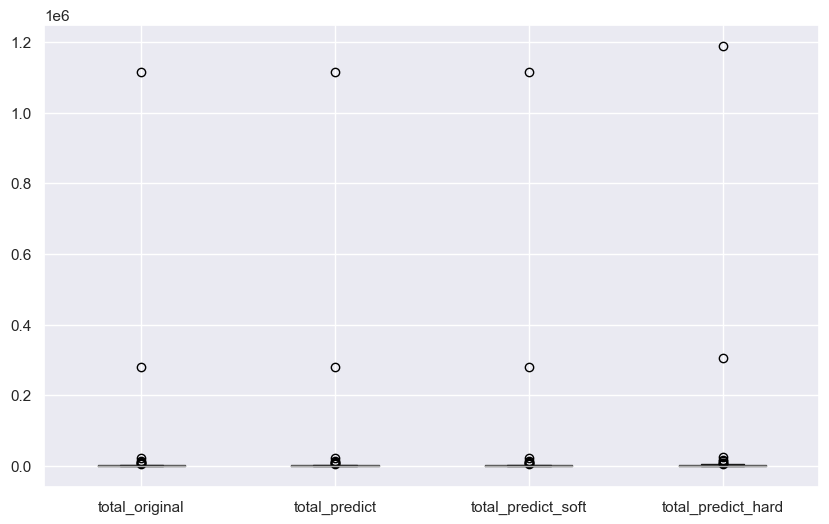

In [195]:
anova(
    df_catch_result_full[
        ["total_original", "total_predict", "total_predict_soft", "total_predict_hard"]
    ]
)

### Для более подробного исследования величины p-value между наборами данных использован тест Тьюки:

In [235]:
# преобразование структуры данных к виду, удобному для проведения теста Тьюки
df_tukeyhsd = pd.DataFrame()
columns_list = [
    "total_original",
    "total_predict",
    "total_predict_soft",
    "total_predict_hard",
]
for column in columns_list:
    df = pd.DataFrame(df_catch_result_full[column]).rename({column: "value"}, axis=1)
    df["predict_type"] = column
    if df_tukeyhsd.empty:
        df_tukeyhsd = df.copy()
    else:
        df_tukeyhsd = pd.concat([df_tukeyhsd, df])
df_tukeyhsd.reset_index(drop=True, inplace=True)
# те же данные в удобной для использования форме
df_tukeyhsd

,value,predict_type
0,2.3,total_original
1,225.7,total_original
2,6591.0,total_original
3,68.2,total_original
4,1871.0,total_original
...,...,...
155,130.4,total_predict_hard
156,21.3,total_predict_hard
157,0.0,total_predict_hard
158,0.0,total_predict_hard


In [236]:
# тест Тьюки для alpha = 0.1
tukey = pairwise_tukeyhsd(
    df_tukeyhsd["value"],
    groups=df_tukeyhsd["predict_type"],
    alpha=0.1,
)
print(tukey)

                 Multiple Comparison of Means - Tukey HSD, FWER=0.10                 
      group1             group2        meandiff  p-adj     lower      upper    reject
-------------------------------------------------------------------------------------
    total_original      total_predict     13.085    1.0 -94887.8447 94914.0147  False
    total_original total_predict_hard  2669.3125 0.9999 -92231.6172 97570.2422  False
    total_original total_predict_soft      28.03    1.0 -94872.8997 94928.9597  False
     total_predict total_predict_hard  2656.2275 0.9999 -92244.7022 97557.1572  False
     total_predict total_predict_soft     14.945    1.0 -94885.9847 94915.8747  False
total_predict_hard total_predict_soft -2641.2825 0.9999 -97542.2122 92259.6472  False
-------------------------------------------------------------------------------------


### **Таким образом, статистически значимых отличий между исходнами данными и результатами прогнозирования по всем вариантам алгоритма не установлено.** Наблюдается исчезающе малое отличие только в отношении результатов прогноза по hard-модели.

### 5.2.4. Статистический анализ отклонений результатов "soft" и "hard" моделей от прогноза на основании среднего значения

In [196]:
df_catch_result_full["soft_balance"] = (
    df_catch_result_full["total_predict_soft"] - df_catch_result_full["total_predict"]
)
df_catch_result_full["hard_balance"] = (
    df_catch_result_full["total_predict_hard"] - df_catch_result_full["total_predict"]
)

In [197]:
df_catch_result_full

,id_fish,fish,total_original,total_predict,total_predict_soft,total_predict_hard,soft_balance,hard_balance
0,15,палтусы,2.3,2.3,2.3,2.3,0.0,0.0
1,112,палтус белокорый,225.7,223.2,223.2,221.8,0.0,-1.4
2,113,палтус черный (синекорый),6591.0,6595.3,6595.3,6593.4,0.0,-1.9
3,114,палтус стрелозубый,68.2,69.3,69.3,68.7,0.0,-0.6
4,144,скаты,1871.0,1872.1,1872.1,1870.0,0.0,-2.1
...,...,...,...,...,...,...,...,...
35,880,шипощек,139.4,129.9,129.9,130.4,0.0,0.5
36,887,кальмар тихоокеанский,21.3,21.3,21.3,21.3,0.0,0.0
37,888,кальмар командорский,2.2,0.0,0.0,0.0,0.0,0.0
38,949,ламинарии,0.2,0.0,0.0,0.0,0.0,0.0


### Проверка данных на нормальность распределения не выполнялась в связи с очевидной бессмысленностью такой проверки.

In [199]:
# тест Манна-Уитни при уровне статистической значимости  alpha = 0.1 (обоснование величины alpha приведено выше)
stat, p = stats.mannwhitneyu(
    df_catch_result_full["soft_balance"],
    df_catch_result_full["hard_balance"],
    alternative="two-sided",
)
print("statistic=%.3f, p-value=%.3f" % (stat, p))
alpha = 0.1
if p > alpha:
    print("Отличия статистически не значимы")
else:
    print("Отличия статистически значимы")

statistic=843.000, p-value=0.641
Отличия статистически не значимы


### **Различия между отклонениями результатов тестирования по "soft" и "hard" моделям от результатов прогноза по среднему значению *для выбранного значения alpha* статистически не значимы**.

### 5.2.5. Сравнение абсолютных значений результатов прогнозирования с исходными данными оперативной промысловой отчётности

In [200]:
# создание копии набора данных
df_catch_result_full_abs = df_catch_result_full.copy()

In [201]:
# вычисление абсолютных отклонений
df_catch_result_full_abs["total_predict_balance"] = (
    df_catch_result_full_abs["total_predict"]
    - df_catch_result_full_abs["total_original"]
)
df_catch_result_full_abs["total_predict_soft_balance"] = (
    df_catch_result_full_abs["total_predict_soft"]
    - df_catch_result_full_abs["total_original"]
)
df_catch_result_full_abs["total_predict_hard_balance"] = (
    df_catch_result_full_abs["total_predict_hard"]
    - df_catch_result_full_abs["total_original"]
)

In [202]:
df_catch_result_full_abs

,id_fish,fish,total_original,total_predict,total_predict_soft,total_predict_hard,soft_balance,hard_balance,total_predict_balance,total_predict_soft_balance,total_predict_hard_balance
0,15,палтусы,2.3,2.3,2.3,2.3,0.0,0.0,0.0,0.0,0.0
1,112,палтус белокорый,225.7,223.2,223.2,221.8,0.0,-1.4,-2.5,-2.5,-3.9
2,113,палтус черный (синекорый),6591.0,6595.3,6595.3,6593.4,0.0,-1.9,4.3,4.3,2.4
3,114,палтус стрелозубый,68.2,69.3,69.3,68.7,0.0,-0.6,1.1,1.1,0.5
4,144,скаты,1871.0,1872.1,1872.1,1870.0,0.0,-2.1,1.1,1.1,-1.0
...,...,...,...,...,...,...,...,...,...,...,...
35,880,шипощек,139.4,129.9,129.9,130.4,0.0,0.5,-9.5,-9.5,-9.0
36,887,кальмар тихоокеанский,21.3,21.3,21.3,21.3,0.0,0.0,0.0,0.0,0.0
37,888,кальмар командорский,2.2,0.0,0.0,0.0,0.0,0.0,-2.2,-2.2,-2.2
38,949,ламинарии,0.2,0.0,0.0,0.0,0.0,0.0,-0.2,-0.2,-0.2


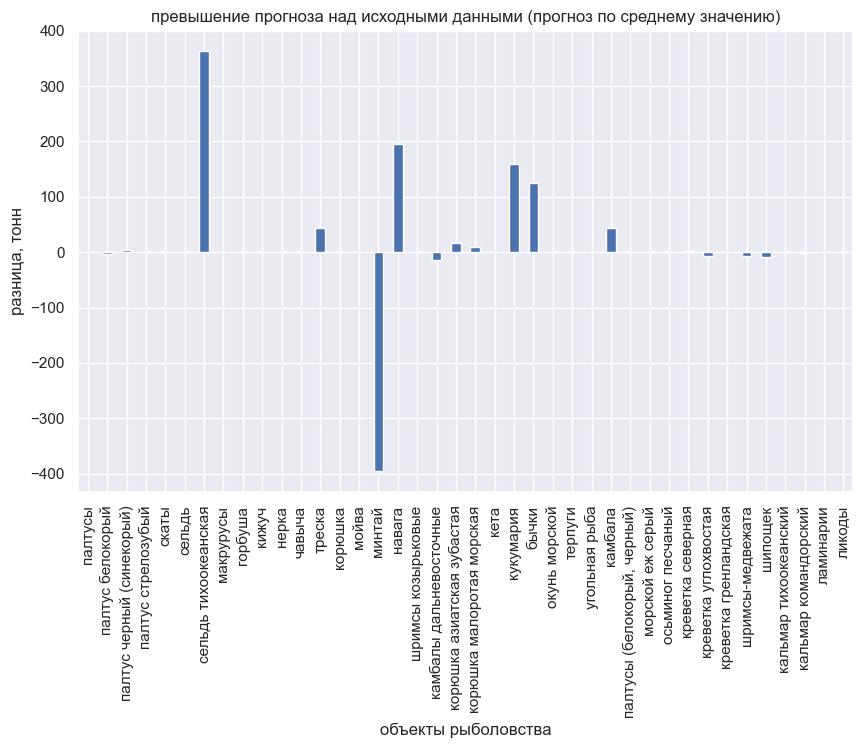

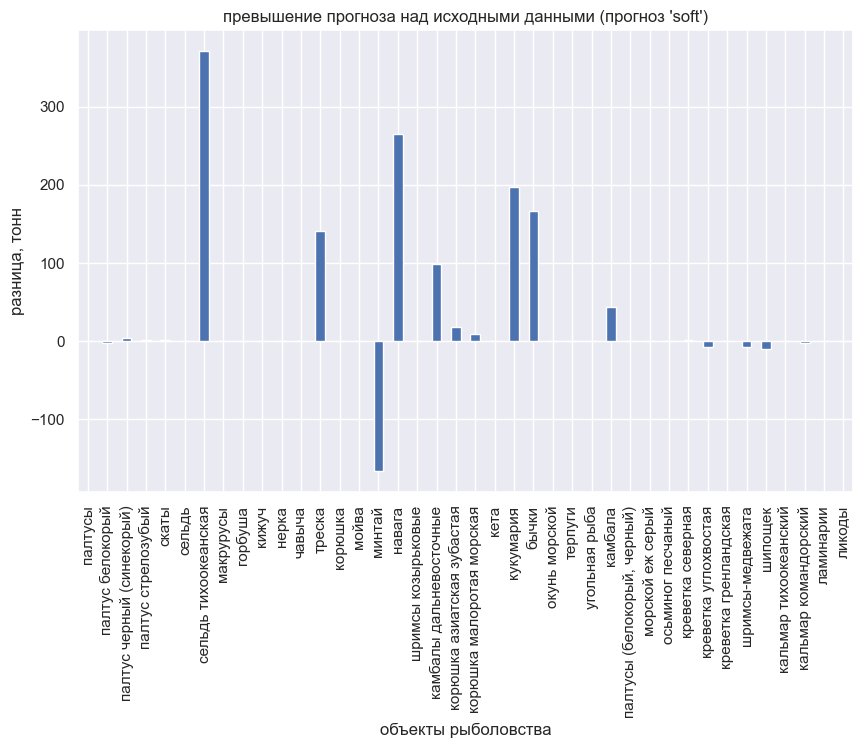

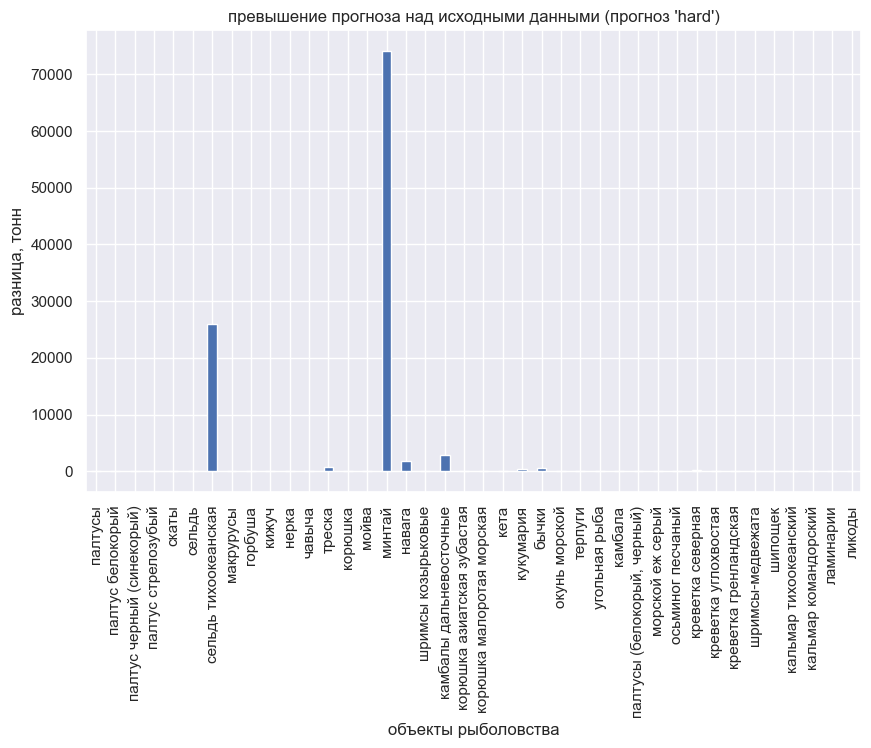

In [203]:
# различие между оригинальными данными и результатами прогнозов
rcParams["figure.figsize"] = 10, 6

df_catch_result_full_abs[["fish", "total_predict_balance"]].plot(
    x="fish",
    kind="bar",
    title="превышение прогноза над исходными данными (прогноз по среднему значению)",
    xlabel="объекты рыболовства",
    ylabel="разница, тонн",
    stacked=True,
    legend=False,
)

df_catch_result_full_abs[["fish", "total_predict_soft_balance"]].plot(
    x="fish",
    kind="bar",
    title="превышение прогноза над исходными данными (прогноз 'soft')",
    xlabel="объекты рыболовства",
    ylabel="разница, тонн",
    stacked=True,
    legend=False,
)

df_catch_result_full_abs[["fish", "total_predict_hard_balance"]].plot(
    x="fish",
    kind="bar",
    title="превышение прогноза над исходными данными (прогноз 'hard')",
    xlabel="объекты рыболовства",
    ylabel="разница, тонн",
    stacked=True,
    legend=False,
)
plt.show()

### - для визуализации полученных отклонений в едином масштабе данные стардартизированы данные таким образом, что все выборки имеют среднее значение, равное 0, и стандартное отклонение, равное 1

In [204]:
scaler = StandardScaler()
df_balanse_scaled = pd.DataFrame(
    scaler.fit_transform(df_catch_result_full[["soft_balance", "hard_balance"]])
).rename(columns={0: "soft_balance_scaled", 1: "hard_balance_scaled"})
df_balanse_scaled = df_balanse_scaled.merge(
    df_catch_result_full, left_index=True, right_index=True
)[["soft_balance_scaled", "hard_balance_scaled", "fish"]]

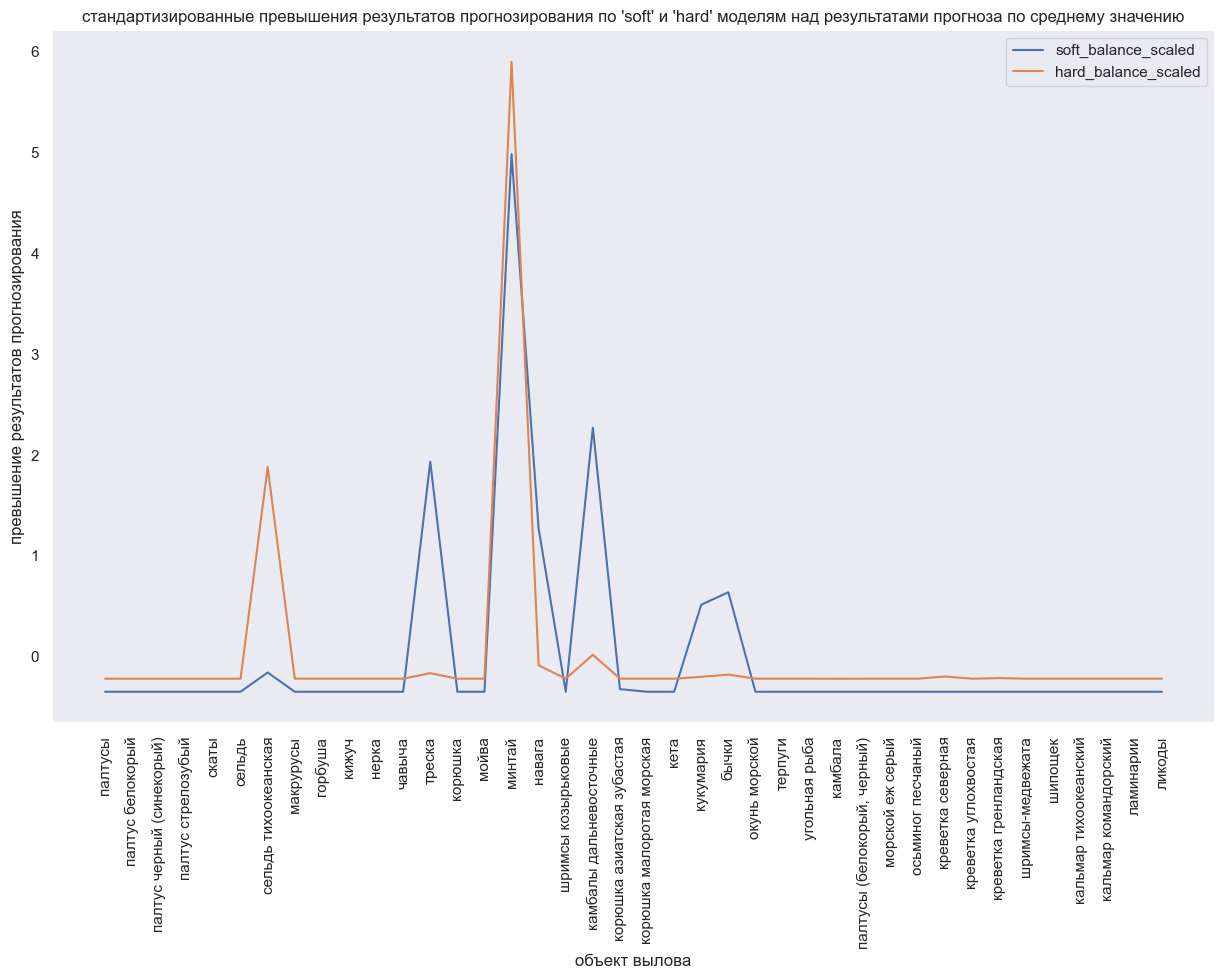

In [205]:
# визуализация результатов
rcParams["figure.figsize"] = 15, 9
plt.plot(df_balanse_scaled["fish"], df_balanse_scaled["soft_balance_scaled"])
plt.plot(df_balanse_scaled["fish"], df_balanse_scaled["hard_balance_scaled"])
plt.title(
    "стандартизированные превышения результатов прогнозирования по 'soft' и 'hard' моделям над результатами прогноза по среднему значению"
)
plt.xlabel("объект вылова")
plt.xticks(rotation=90)
plt.ylabel("превышение результатов прогнозирования")
plt.legend(df_balanse_scaled.columns)
plt.grid()
plt.show()

### 5.2.6. Визуализация отклонений результатов прогноза на основании среднего значения, а также "soft" и "hard" моделей от исходных данных

In [206]:
# расчёт величины превышения результатов прогнозирования над исходными данными
df_catch_result_full_viz = df_catch_result_full.drop(
    ["soft_balance", "hard_balance"], axis=1
)

df_catch_result_full_viz["balance_middle"] = (
    df_catch_result_full_viz["total_predict"]
    - df_catch_result_full_viz["total_original"]
)
df_catch_result_full_viz["balance_soft"] = (
    df_catch_result_full_viz["total_predict_soft"]
    - df_catch_result_full_viz["total_original"]
)
df_catch_result_full_viz["balance_hard"] = (
    df_catch_result_full_viz["total_predict_hard"]
    - df_catch_result_full_viz["total_original"]
)
df_catch_result_full_viz = df_catch_result_full_viz[
    ["fish", "balance_middle", "balance_soft", "balance_hard"]
]

In [207]:
# стандартизация данных
scaler = StandardScaler()
df_balanse_full_scaled = pd.DataFrame(
    scaler.fit_transform(
        df_catch_result_full_viz[["balance_middle", "balance_soft", "balance_hard"]]
    )
).rename(
    columns={
        0: "middle_balance_scaled",
        1: "soft_balance_scaled",
        2: "hard_balance_scaled",
    }
)
df_balanse_full_scaled = df_balanse_full_scaled.merge(
    df_catch_result_full, left_index=True, right_index=True
)[["middle_balance_scaled", "soft_balance_scaled", "hard_balance_scaled", "fish"]]

In [208]:
df_balanse_full_scaled

,middle_balance_scaled,soft_balance_scaled,hard_balance_scaled,fish
0,-0.136959,-0.322055,-0.220001,палтусы
1,-0.163126,-0.350779,-0.220323,палтус белокорый
2,-0.091951,-0.272650,-0.219804,палтус черный (синекорый)
3,-0.125445,-0.309416,-0.219960,палтус стрелозубый
4,-0.125445,-0.309416,-0.220084,скаты
...,...,...,...,...
35,-0.236394,-0.431207,-0.220743,шипощек
36,-0.136959,-0.322055,-0.220001,кальмар тихоокеанский
37,-0.159986,-0.347332,-0.220183,кальмар командорский
38,-0.139052,-0.324353,-0.220018,ламинарии


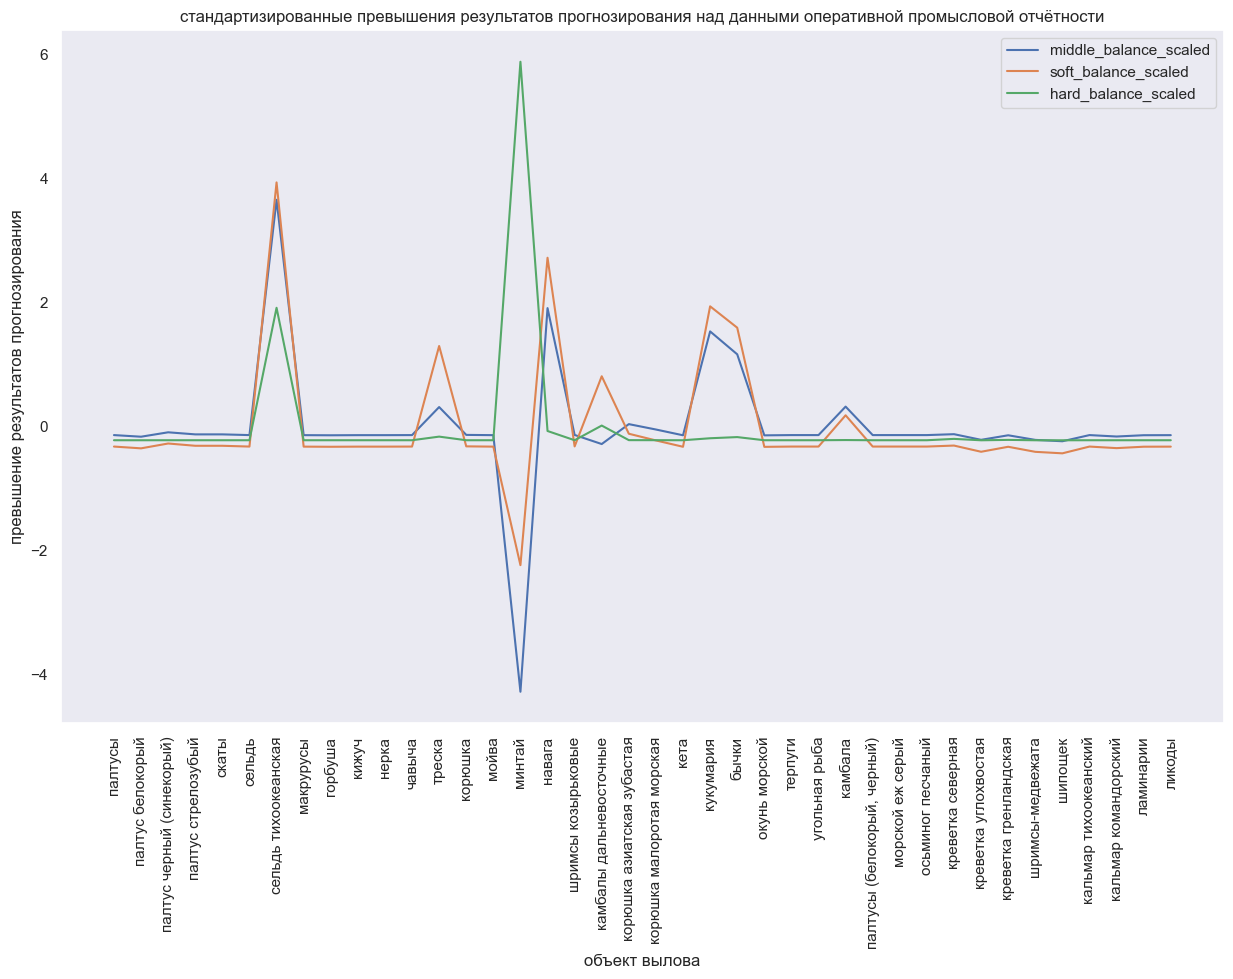

In [209]:
# визуализация результатов
rcParams["figure.figsize"] = 15, 9
plt.plot(
    df_balanse_full_scaled["fish"], df_balanse_full_scaled["middle_balance_scaled"]
)
plt.plot(df_balanse_full_scaled["fish"], df_balanse_full_scaled["soft_balance_scaled"])
plt.plot(df_balanse_full_scaled["fish"], df_balanse_full_scaled["hard_balance_scaled"])
plt.title(
    "стандартизированные превышения результатов прогнозирования над данными оперативной промысловой отчётности"
)
plt.xlabel("объект вылова")
plt.xticks(rotation=90)
plt.ylabel("превышение результатов прогнозирования")
plt.legend(df_balanse_full_scaled.columns)
plt.grid()
plt.show()

***
# **6. Выводы по результатам исследования**

## 1. В результате очистки, подготовки и восстановления данных с использованием наиболее целесообразных для каждого конкретного случая подходов получен качественный dataset, который может быть эффективно использован для анализа и оценки деятельности отдельных судов, прогнозирования видовых и объёмных показателей вылова отдельными судами и (или) по отдельным объектам (промысловым районам);

## 2. При классификации судов был применён комплексный подход, при  котором классификация осуществлялась по двум критериям: конструктивному типу судна и мощности ГЭУ. Результаты дальнейшего исследования показывают, что классификация по конструктивному типу, в контексте темы и предмета данной работы, возможно избыточна. Учёт конструктивного типа судна актуален при оценке результатов переработки (обработки), хранения и транспортировки уловов и произведённой из них продукции, но, вероятно, не оказывает существенного влияния на результаты добычи. Для оценки последних наиболее целесообразно исходить из мощности ГЭУ и используемого орудия лова, тип которого в этом случае может быть определён более детально.

## 3. Применённый при кластеризации судов подход в полной мере отвечает цели исследования. Построенные в результате его реализации уникальные кластеры обеспечивают однородность промысловой обстановки, в результате чего видовые и объёмные показатели вылова внутри каждого кластера не должны иметь существенных отличий. К направлению совершенствования подхода можно лишь отнести использование при определении кластера информации о горизонте траления. Вероятно, такое изменение методики кластеризации наиболее целесообразно применить при исключении из критериев классификации судов данных о конструктивном типе, о котором сказано в п. 2.

## 4. Прогнозирование видовых и объёмных показателей вылова осуществлялось с использованием трёх алгоритмов, различавшихся способом определения наиболее вероятного объёма добычи по каждому объекту внутри кластера, и суммированием полученных результатов в разрезе объектов добычи и промыслового района. Результаты прогнозирования представляют существенный интерес для продолжения исследований по рассматриваемой тематике. В настоящее время можно с достоверностью утверждать, что:
### - при представлении данных оперативной промысловой отчётности допускаются искажения, однако в масштабах промыслового года в акватории Охотского моря такие искажения не оказывают статистически значимого влияния на фиксируемые результаты рыболовства;
### - результаты прогноза целесообразно использовать для оценки деятельности конкретных участников рыболовства для определения приоритетных объектов воздействия контролирующих и фискальных органов.

## 5. Применяемый алгоритм прогнозирования результатов добычи представляет существенный практический интерес и должен стать предметом дальнейших исследований. В частности, установлено, что:
### - прогнозируемые видовые показатели вылова от применяемого алгоритма не зависят, что полностью согласуется с логикой применяемого в рамках исследования подхода;
### - результаты прогноза объёмных показателей вылова зависят от применяемого алгоритма весьма значимо. Оценка результатов прогнозирования позволяет сделать вывод, что наиболее существенно применяемый алгоритм оказывает влияние на прогноз объёмов добычи объектов, вылов которых изначально высок: минтая, сельди, камбал. Неожиданные результаты прогнозирования объёма уловов кукумарии и бычков могут быть объяснены тем, что значительное количество добытых бычков в промысловой отчётности не отражается, а их улов используется для производства рыбной муки вместо фактически уничтожаемых отходов переработки других видов рыб и этот факт вскрывается в результате прогноза. Кукумария же (донное беспозвоночное, не являющееся объектом традиционного тралового лова в промышленном масштабе), эпизодически добывается донным тралом; но при используемой методике такой эпизодический вылов отдельным судном применяется ко всему кластеру, что приводит к некоторому завышению прогноза. Таким образом, данными прогноза об объёмах добычи кукумарии целесообразно пренебречь.

## 6.Результаты прогнозирования объёмов добычи по hard и soft моделям алгоритма прогнозирования признаны не имеющими статистических различий для принятого на основании объёма выборки уровня значимости 0.1. Перспективным направлением продолжения исследования следует признать эмпирическое определение величины понижающего коэффициента для hard модели алгоритма прогнозирования. Имеются основания полагать, что hard модель алгоритма прогнозирования при удачно подобранном значении понижающего коэффициента (возможно, дифференцированного в разрезе объектов добычи) наиболее перспективна.

***